# Overview
Here I will describe what is done...


### Sources of code
- Going to grab code from here: https://bioc.ism.ac.jp/packages/3.3/bioc/vignettes/ggtree/inst/doc/treeAnnotation.html and here https://guangchuangyu.github.io/ggtree-book/chapter-ggtree.html.

- Good data here: https://github.com/YuLab-SMU/ggtree/issues/335


### To do list
- ~~**MUST CHECK THAT BOOTSTRAP VALUES ARE CORRECT (NOT AN ARTIFACT OF THE PLOTTING MECHANISM)**~~

- ~~**Must change a bit the cholor schemes of O2 and pH**~~
- ~~Get lighter colours for O2 in order to make them easy to see~~
- ~~**Must check Taxa, seems pretty weird**~~
- ~~Must plot with my own tree data~~
- ~~check that solid and aqueous are always opposite, complementary states~~
- ~~check that sample order is correct in heatmap with respect to tree~~ (I checked coherence between data and original table)
- ~~add key legend in x and order by factor~~
- ~~plot temperature? -> yes, and set my self the three categories. Should see how to deal with pH's temperature scale colours~~
- Must rename some Taxa ID's in order to be at some specific NCBI taxonomic level (as did Dr. David Moi in other figures) -> ask headquarters
- Make a try with habitat?
- ~~get rid of x scale~~
- get rid of NAs in legends
- ~~Circular plot maybe?~~

In [1347]:
library(repr) # tip from here https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
options(repr.plot.width=20, repr.plot.height=20)

In [1348]:
# running at OEG's scoville server, under conda environment <r_env_4>
# loading libraries
library(tidyverse)
library(glue)
library(magrittr)
library(ggtree)
library(readxl)

In [1418]:
# loading tree data (all the files)
# Martin's infered trees % FsxA_kosher_linsi.tree = treeio::read.tree('../data/trees/FsxAs_ECTOS_currcandidatesFeb-2021_posta_linsi_gt01.contree')
# Martin's infered trees % FsxA_kosher_promals.tree = treeio::read.tree('../data/trees/allkosherMdl_promalsEdlong.contree')
# Martin's infered trees % FsxA_kosher_tcoffee.tree = treeio::read.tree('../data/trees/allkosherTCOff_gt01.contree')

# file containing only FsxA ectodomains
#FsxA_kosher_linsi.tree = treeio::read.tree('../data/trees/infered_by_mauricio/FsxA_ectodomains/FsxA_ectodomains.contree')
# file for tree also containing HAP2 ectodomains
FsxA_kosher_linsi.previous.tree = treeio::read.tree('../data/trees/infered_by_mauricio/fsxA_and_hap2_ectodomains/fsxA_and_hap2_ectodomains.contree')

# for new subset
# without Halovivax # FsxA_kosher_linsi.tree = treeio::read.tree('../data/new_subset/NewSelEcoTree_iq2.contree')
# with Halovivax
FsxA_kosher_linsi.tree = treeio::read.tree('../data/new_subset/including_halovivax/NewSelEcoTree_iq2.contree')

In [1419]:
# modifying tip label to be compatible with code
FsxA_kosher_linsi.tree$tip.label %<>% 
                            str_split('/') %>% 
                            purrr::map_chr(1) %>% 
                            str_replace_all(., 'mc35926358\\|Representative_scaffold16196_4', 'mc35926358|Representative_scaffold16196_4/1624') %>%
                            str_replace_all(., 'mc1330463358\\|Representative_gi\\|984778642\\|gb\\|LFUF01005182.1\\|_1', 
                                               'mc1330463358|Representative_gi|984778642|gb|LFUF01005182.1|_1/1417') %>%
                            str_replace_all(., 'mc1328965482\\|Representative_gi\\|998585003\\|gb\\|LFCJ01001378.1\\|_8', 
                                               'mc1328965482|Representative_gi|998585003|gb|LFCJ01001378.1|_8/1661') 

In [1420]:
c('001179505.1', '000189635.1', '003719155.1', '000190715.1', '000313135.1', 'HAP2_Chlamy') %in% FsxA_kosher_linsi.tree$tip.label %>% table()

.
TRUE 
   6 

In [1421]:
# rooting to get clade of HAP2s as outgroups
FsxA_kosher_linsi.tree2 = ape::root(FsxA_kosher_linsi.tree, outgroup = c('HAP2_Chlamy', '001179505.1', '000189635.1', '003719155.1', '000190715.1', '000313135.1'), resolve.root = TRUE)
FsxA_kosher_linsi.tree = FsxA_kosher_linsi.tree2

# minor trick to get root visible: setting length of the edge of the root (by default in zero) to the value of the first edge (leading to study group)
FsxA_kosher_linsi.tree$edge.length[FsxA_kosher_linsi.tree$edge.length == 0] = FsxA_kosher_linsi.tree$edge.length[1]

# load ecological categorical data
## define column names
ecological_data_columns = c('HEADER','scaffold ID_ORF','scaffold ID_ORF (SPADES)','CONFIDENCE','METAGENOMICS PROJECT',
                               'TAXA','scaffold length','COMPLETE SEQUENCE','LENGTH','SIGNAL PEPTIDE?','TMs','ECTODOMAIN',
                               'ECTO LENGTH','C','Num CYS','ECTO Isoelectric point','COMMENTS','BIOSAMPLE','MG NAME',
                               'HABITAT_Detailed','Temperature_Detailed','elev mts','collec DATE','HABITAT','AUTHORS',
                               'CONTACT','PAPER DOI','ISOLATION','SOLID','AQUEOUS','SALT?','pH','T_Classified',
                               'ALT_DEPT (mts)','FILTER FRACTION','O2')

# old table code # ecological_data.tibble = readxl::read_xlsx('../data/metadata/modified_FsxAs-Kosher-Taxo-Abr-2021.xlsx',
# old table code #                                             col_names = ecological_data_columns, 
# old table code #                                             skip = 1)

#ecological_data.tibble = readxl::read_xlsx('../data/metadata/modified-FsxAs-Kosher-Taxo-23-Abr-2021.xlsx',
#                                            col_names = ecological_data_columns, 
#                                            skip = 1)

# old code ecological_data.tibble = readr::read_tsv('../data/metadata/modified-FsxAs-Kosher-Taxo-23-Abr-2021_Taxon_and_Kosher.tsv',
# old code                                            col_names = ecological_data_columns, 
# old code                                            skip = 1)

ecological_data.tibble = readr::read_tsv('../data/metadata/modified_FsxAs-Kosher-Taxo-26-Abr-2021_Taxon_and_Kosher.tsv',
                                           col_names = ecological_data_columns, 
                                           skip = 1)

# performiing a little change in a too-long-tip
ecological_data.tibble %<>% dplyr::mutate(HEADER = HEADER %>% str_replace_all(., ' \\(new.*\\)', '')) 


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  `scaffold length` = col_double(),
  LENGTH = col_double(),
  `SIGNAL PEPTIDE?` = col_double(),
  TMs = col_double(),
  `ECTO LENGTH` = col_double(),
  `Num CYS` = col_double(),
  `ECTO Isoelectric point` = col_double(),
  SOLID = col_double(),
  AQUEOUS = col_double(),
  `SALT?` = col_double(),
  pH = col_double(),
  T_Classified = col_double(),
  `ALT_DEPT (mts)` = col_double(),
  O2 = col_double()
)
ℹ Use `spec()` for the full column specifications.




In [1422]:
# checking that solid and aqueous are exclusive classifications
ecological_data.tibble %>% group_by(SOLID, AQUEOUS) %>% summarise(count = n())

`summarise()` has grouped output by 'SOLID'. You can override using the `.groups` argument.



SOLID AQUEOUS count
1  1     2      36   
2  2     1      58   
3 NA    NA       1

In [1423]:
ecological_data.tibble$HABITAT_Detailed %>% unique()

[1] "Aerobic enrichment media from sediment sample"                                                                                                                                                                                                                                                                                                                                                                                                                               
 [2] "landfill leachate"                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [3] "Groundwater microbial communities from an aquifer near a municipal landfill in Southern Ontario, Canada"                                                                                                                                                                                                                                                                                                                                                                     
 [4] "Permafrost microbial communities from Stordalen Mire, Sweden"                                                                                                                                                                                                                                                                                                                                                                                                                
 [5] "Groundwater, Aspo Hard Rock Laboratory (HRL) deep subsurface site, Sweden"                                                                                                                                                                                                                                                                                                                                                                                                   
 [6] "Peatland  at the Marcell Experimental Forest in Minnesota"                                                                                                                                                                                                                                                                                                                                                                                                                   
 [7] "Saline lake microbial communities from Ace Lake, Antarctica"                                                                                                                                                                                                                                                                                                                                                                                                                 
 [8] "hypersaline soda lake brines (LakeBitter-1(B1))"                                                                                                                                                                                                                                                                                                                                                                                                                             
 [9] "water collected from the Namib Desert Hosabes playa"                                                                                                                                                                                                       

In [1425]:
ecological_data.tibble %<>% 
    dplyr::mutate(`Habitat` = case_when(HABITAT_Detailed == 'Aerobic enrichment media from sediment sample' ~ 'Sediment sample',
                                        HABITAT_Detailed == 'landfill leachate' ~ 'Landfill leachate',
                                        HABITAT_Detailed == 'Groundwater microbial communities from an aquifer near a municipal landfill in Southern Ontario, Canada' ~ 'Groundwater',
                                        HABITAT_Detailed == 'Permafrost microbial communities from Stordalen Mire, Sweden' ~ 'Permafrost',
                                        HABITAT_Detailed == 'Groundwater, Aspo Hard Rock Laboratory (HRL) deep subsurface site, Sweden' ~ 'Groundwater',
                                        HABITAT_Detailed == 'Peatland  at the Marcell Experimental Forest in Minnesota' ~ 'Peatland',
                                        HABITAT_Detailed == 'Saline lake microbial communities from Ace Lake, Antarctica' ~ 'Saline lake',
                                        HABITAT_Detailed == 'hypersaline soda lake brines (LakeBitter-1(B1))' ~ 'Hypersaline soda lake',
                                        HABITAT_Detailed == 'water collected from the Namib Desert Hosabes playa' ~ 'Water sample',
                                        HABITAT_Detailed == 'Hot spring thermophilic microbial communities from Obsidian Pool, Yellowstone National Park, USA' ~ 'Hot spring',
                                        HABITAT_Detailed == 'Temperate Freshwater Wetland sediment, Old Woman Creek National Estuarine Research Reserve, Ohio' ~ 'Freshwater',
                                        HABITAT_Detailed == 'Soil microbial communities from Rifle, Colorado' ~ 'Soil sample',
                                        HABITAT_Detailed == 'The sample material (saline water (ENVO:00002010), including plankton (ENVO:xxxxxxxx)) was collected at a depth of 596-605 m, targeting a mesopelagic zone (ENVO:00000213) & marine oxygen minimum zone (ENVO:01000065) in the marine biome (ENVO:00000447). The sample was size-fractionated (0.1-0.22 micrometres), and stored at -20 degC for later detection of large DNA virus nucleic acid sequences by pyrosequencing methods, and for later metagenomics analysis.' ~ 'Marine sample',
                                        HABITAT_Detailed == 'Environmental > Aquatic > Marine > Oil-contaminated sediment' ~ 'Marine sample',
                                        HABITAT_Detailed == 'Environmental > Aquatic > Marine > subseafloor sediment' ~ 'Marine sample',
                                        HABITAT_Detailed == 'Environmental > Aquatic > Freshwater > Sediment' ~ 'Freshwater',
                                        HABITAT_Detailed == 'Environmental > Aquatic > Marine > Intertidal zone > Salt marsh' ~ 'Marine sample',
                                        HABITAT_Detailed == 'salt mine, China: Yunnan' ~ 'Salt mine',
                                        HABITAT_Detailed == 'salt lake (Ayakekum), Altun mountain' ~ 'Saline lake',
                                        HABITAT_Detailed == 'mixture of water from the Dead Sea and the Red Sea; Israel, Sedom' ~ 'Marine sample',
                                        HABITAT_Detailed == 'brine of Lake Bitter-1 , Russia: Kulunda steppe' ~ 'Lake',
                                        HABITAT_Detailed == 'Rifle groundwater metagenome at time 1 / A; 0.2 micron filter' ~ 'Groundwater',
                                        HABITAT_Detailed == 'marine hydrothermal sediment' ~ 'Hydrothermal sample',
                                        HABITAT_Detailed == 'marine hydrothermal sediment-HyVt-139' ~ 'Hydrothermal sample',
                                        HABITAT_Detailed == 'Great Boiling Spring, Nevada' ~ 'Hot spring',
                                        HABITAT_Detailed == 'Xinjiang salt lake sediment.' ~ 'Saline lake',
                                        HABITAT_Detailed == 'Xinjiang saline soil sample' ~ 'Soil sample',
                                        HABITAT_Detailed == 'Bioreactor' ~ 'Bioreactor',
                                        HABITAT_Detailed == 'Pacific Ocean: East Pacific Rise, deepsea hydrothermal sulfide chimney' ~ 'Hydrothermal sample',
                                        HABITAT_Detailed == 'Yellowstone National Park, Thermal springs, mud, sediment' ~ 'Hot spring',
                                        HABITAT_Detailed == 'Mid-Cayman Rise Vent Fluids, UWMA-0176' ~ 'Hydrothermal sample',
                                        HABITAT_Detailed == 'Solar saltern, India' ~ 'Solar saltern',
                                        TRUE ~ `HABITAT_Detailed`)
                 )

In [1426]:
# saving table to debate with Martin and Hector
ecological_data.tibble %>%
    dplyr::select(HEADER, HABITAT_Detailed, Habitat) %>%
    readr::write_tsv(., '../results/plots/FsxA_ecotree_samples_and_habitats_210712.tsv')

## MAFFT (L-INS-I)

In [1428]:
# adding line for Halovivax

FsxA_kosher_linsi.tree$tip.label

[1] "3300000868-JGI12330J12834-1000008-299010-8"                        
 [2] "3300014206-Ga0172377-10000119-870930-129"                          
 [3] "3300014208-Ga0172379-10001592-871560-40"                           
 [4] "3300014613-Ga0180008-1001212-875221-12"                            
 [5] "3300014208-Ga0172379-10000243-871512-158"                          
 [6] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold06785_2"       
 [7] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold17623_2"        
 [8] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold134102_1"      
 [9] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold29013_2"       
[10] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold72169_1"       
[11] "001179505.1"                                                       
[12] "000189635.1"                                                       
[13] "000313135.1"                                                       
[14] "HAP2_Chlamy"                                                       
[15] "003719155.1"                                                       
[16] "000190715.1"                                                       
[17] "Ace"                                                               
[18] "RLG94066.1"                                                        
[19] "MGYP000565992219"                                                  
[20] "SAMEA2619974_10776_4"                                              
[21] "MGYP000347782300"                                                  
[22] "RKX41251.1"                                                        
[23] "mc35926358|Representative_scaffold16196_4/1624"                    
[24] "AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold00511_6"       
[25] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold83478_1"        
[26] "AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold24857_2"       
[27] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold01114_5"       
[28] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold02562_2"       
[29] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold11370_2"       
[30] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold18285_3"        
[31] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold82302_1"       
[32] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold07707_5"        
[33] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold00557_40"       
[34] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold36732_2"       
[35] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold55385_1"       
[36] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold34113_4"        
[37] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold26691_1"       
[38] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold70733_1"        
[39] "MGYP000642661316"                                                  
[40] "MGYP000359581082"                                                  
[41] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold00851_7"        
[42] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold89608_1"        
[43] "MGYP000672152970"                                                  
[44] "RKZ11204.1"                                                        
[45] "AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold03294_14"      
[46] "AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold12674_2"       
[47] "AntAceMinimDraft_14_1070370.scaffolds.fasta_scaffold61386_1"       
[48] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold06919_8"       
[49] "AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold15402_2"       
[50] "AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold06212_4"       
[51] "AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold28048_2"        
[52] "PlaIllAssembly_1097288.scaffolds.fasta_scaffold00281_9"            
[53] "NOZ47386.1"                                                        
[54] "mc1330463358|Representative_gi|984778642|gb|LFUF01005182.1|_1/1417"
[55] 

In [1432]:
ecological_data.tibble %>% colnames()

tibble(HEADER = 'lcl|NZ_CP071597.1_prot_WP_207587115.1_2894') %>%
    dplyr::mutate(`scaffold ID_ORF` = 'NZ_CP071597.1',
                  `scaffold ID_ORF (SPADES)` = NA,
                  CONFIDENCE = NA,
                  `METAGENOMICS PROJECT` = NA,
                  `TAXA` = 'Halovivax sp. KZCA124',
                  `COMPLETE SEQUENCE` = '',
                  `LENGTH` = ,
                  `SIGNAL PEPTIDE?` = NA,
                  `TMs` = NA,
                   `ECTODOMAIN` = '',
                  )

[1] "HEADER"                   "scaffold ID_ORF"         
 [3] "scaffold ID_ORF (SPADES)" "CONFIDENCE"              
 [5] "METAGENOMICS PROJECT"     "TAXA"                    
 [7] "scaffold length"          "COMPLETE SEQUENCE"       
 [9] "LENGTH"                   "SIGNAL PEPTIDE?"         
[11] "TMs"                      "ECTODOMAIN"              
[13] "ECTO LENGTH"              "C"                       
[15] "Num CYS"                  "ECTO Isoelectric point"  
[17] "COMMENTS"                 "BIOSAMPLE"               
[19] "MG NAME"                  "HABITAT_Detailed"        
[21] "Temperature_Detailed"     "elev mts"                
[23] "collec DATE"              "HABITAT"                 
[25] "AUTHORS"                  "CONTACT"                 
[27] "PAPER DOI"                "ISOLATION"               
[29] "SOLID"                    "AQUEOUS"                 
[31] "SALT?"                    "pH"                      
[33] "T_Classified"             "ALT_DEPT (mts)"          
[35] "FILTER FRACTION"          "O2"                      
[37] "Habitat"

HEADER                                     scaffold ID_ORF
1 lcl|NZ_CP071597.1_prot_WP_207587115.1_2894 NA

In [1433]:
ecological_data.tibble

HEADER                                                      
1  3300000868-JGI12330J12834-1000008-299010-8                  
2  3300014206-Ga0172377-10000119-870930-129                    
3  3300014208-Ga0172379-10000243-871512-158                    
4  3300014208-Ga0172379-10001592-871560-40                     
5  3300014494-Ga0182017-10003408-872394-14                     
6  3300014613-Ga0180008-1001212-875221-12                      
7  3300018015-Ga0187866-1000629-915963-9                       
8  AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold00069_38
9  AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold00511_6 
10 AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold03294_14
11 AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold06212_4 
12 AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold12674_2 
13 AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold19757_2 
14 AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold24857_2 
15 AntAceMinimDraft_14_1070370.scaffolds.fasta_scaffold00694_11
16 AntAceMinimDraft_14_1070370.scaffolds.fasta_scaffold61386_1 
17 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold00713_2 
18 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold01114_5 
19 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold02562_2 
20 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold02754_4 
21 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold06785_2 
22 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold06919_8 
23 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold11370_2 
24 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold134102_1
25 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold13455_2 
26 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold15402_2 
27 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold20657_2 
28 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold26691_1 
29 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold29013_2 
30 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold31711_5 
⋮  ⋮                                                           
66 MGYP000597840497                                            
67 MGYP000559433360                                            
68 MGYP000353818161                                            
69 MGYP000005856144                                            
70 MGYP000141506420                                            
71 MGYP000648692434                                            
72 MGYP000103175163                                            
73 MGYP000598426430-1548                                       
74 WP_058826362.1                                              
75 WP_007110832.1 - WP_144240185.1                             
76 ELY83688.1 (JCM12890)                                       
77 WP_049937247.1 - WP_157573584.1                             
78 LKMP01000007_1                                              
79 MGYP000179698888-RLG58774.1                                 
80 RLI53188.1                                                  
81 RKX41251.1                                                  
82 RKZ11204.1                                                  
83 RLG94066.1                                                  
84 AJF63093.1                                                  
85 HDO79935.1  or  HEX32987.1                                  
86 HDD44259.1                                                  
87 HDI72891.1                                                  
88 HHR27186.1                                                  
89 WP_174701778.1                                              
90 WP_179268568.1                                              
91 NJD53946.1                                                  
92 NOZ47386.1                                                  
93 HGF63239.1                                                  
94 HID09282.1                                                  
95 WP_163487151.1                                              
   scaffold ID_ORF         scaffold

In [1357]:
# modify ecological data of Halobonum and Haloferax
ecological_data.tibble %<>%
    dplyr::mutate(T_Classified = case_when(str_detect(TAXA, 'Halobonum') ~ 2,
                                           str_detect(TAXA, 'Haloferax') ~ 2,
                                           TRUE ~ T_Classified)
                 )


In [1358]:
# filt
ecological_data_to_plot.tibble = ecological_data.tibble %>%
                                    dplyr::filter(HEADER != 'ASSIGNED TAXON:') %>%
                                    dplyr::select(HEADER, `CONFIDENCE`, `TAXA`, `HABITAT`, `Habitat`, `BIOSAMPLE`, `METAGENOMICS PROJECT`,`elev mts`, 
                                                  `ISOLATION`, `SOLID`, `AQUEOUS`, `SALT?`, `pH`, `T_Classified`,
                                                  `ALT_DEPT (mts)`, `FILTER FRACTION`, `O2`, `AUTHORS`, `PAPER DOI`) 

In [1359]:
ecological_data_to_plot.tibble %>% 
    dplyr::filter(str_detect(HEADER,'Lake'))

HEADER                                        CONFIDENCE TAXA HABITAT
1 Ace Lake-Antarctica -1402-Ga0222697_1002427_6 4          TBA  NA     
  Habitat     BIOSAMPLE    METAGENOMICS PROJECT elev mts
1 Saline lake SAMN09201407 3300022868           14      
  ISOLATION                                                   SOLID AQUEOUS
1 Saline lake microbial communities from Ace Lake, Antarctica 2     1      
  SALT? pH T_Classified ALT_DEPT (mts) FILTER FRACTION O2 AUTHORS         
1 2     3  1            -14            0.8–0.1 μm      3  Rick Cavicchioli
  PAPER DOI
1 NA

In [1360]:
# install bioseq library
#library(remotes)
#remotes::install_github("fkeck/bioseq")

In [1361]:
# must perform a minor trick in order to edit labels were a space was present (they were trimmed by IQTree when inferring phylogeny)

# load original sequences and their names, then create a table that relates them to their trimmed names
library(bioseq)
fsxa_ectodomain_sequences = bioseq::read_fasta('../data/sequences/FsxA_ectodomains.faa', type = 'AA')

missing_leaves = ecological_data_to_plot.tibble %>%
    dplyr::filter(!HEADER %in% FsxA_kosher_linsi.tree$tip.label) %>%
    .$HEADER %>% unique()

missing_leaves_correlation.tibble = tibble(original_names = names(fsxa_ectodomain_sequences)) %>%
    dplyr::mutate(trimmed_name = original_names %>% str_split(' ') %>% purrr::map_chr(1)) %>%
    # subsetting to those leafs that are missing, in order to restablish them
    dplyr::filter(original_names %in% missing_leaves) %>%
    # also, for names containing '='
    dplyr::mutate(trimmed_name = trimmed_name %>% str_replace_all(., '=', '_')) %>%
    # getting rid of a too long segment from a sequence
    dplyr::mutate(original_names = original_names %>% str_replace_all(., '\\(new.*\\)', '')) 

In [1362]:
#missing_leaves_correlation.tibble
missing_leaves_correlation.tibble

original_names                                                    
1  3300014494-Ga0182017-10003408-872394-14                           
2  3300018015-Ga0187866-1000629-915963-9                             
3  mc1328965482|Representative=gi|998585003|gb|LFCJ01001378.1|_8/1661
4  mc1330463358|Representative=gi|984778642|gb|LFUF01005182.1|_1/1417
5  mc20532409|Representative=scaffold68885_2/1553                    
6  mc35926358|Representative=scaffold16196_4/1624                    
7  Ace Lake-Antarctica -1402-Ga0222697_1002427_6                     
8  RifCSPhighO2_12_1023870.scaffolds.fasta_scaffold04391_3           
9  RifOxyB1_1023888.scaffolds.fasta_scaffold00046_11                 
10 RifOxyB1_1023888.scaffolds.fasta_scaffold05169_1                  
11 MGYP000597840497                                                  
12 MGYP000559433360                                                  
13 WP_007110832.1 - WP_144240185.1                                   
14 ELY83688.1 (JCM12890)                                             
15 WP_049937247.1 - WP_157573584.1                                   
16 HDO79935.1  or  HEX32987.1                                        
17 HDD44259.1                                                        
18 HDI72891.1                                                        
19 WP_174701778.1                                                    
20 NJD53946.1                                                        
21 HGF63239.1                                                        
   trimmed_name                                                      
1  3300014494-Ga0182017-10003408-872394-14                           
2  3300018015-Ga0187866-1000629-915963-9                             
3  mc1328965482|Representative_gi|998585003|gb|LFCJ01001378.1|_8/1661
4  mc1330463358|Representative_gi|984778642|gb|LFUF01005182.1|_1/1417
5  mc20532409|Representative_scaffold68885_2/1553                    
6  mc35926358|Representative_scaffold16196_4/1624                    
7  Ace                                                               
8  RifCSPhighO2_12_1023870.scaffolds.fasta_scaffold04391_3           
9  RifOxyB1_1023888.scaffolds.fasta_scaffold00046_11                 
10 RifOxyB1_1023888.scaffolds.fasta_scaffold05169_1                  
11 MGYP000597840497                                                  
12 MGYP000559433360                                                  
13 WP_007110832.1                                                    
14 ELY83688.1                                                        
15 WP_049937247.1                                                    
16 HDO79935.1                                                        
17 HDD44259.1                                                        
18 HDI72891.1                                                        
19 WP_174701778.1                                                    
20 NJD53946.1                                                        
21 HGF63239.1

In [1363]:
# see tree leaves for mc1330463358|... and others, as the error seems to be other here
tibble(leaves = FsxA_kosher_linsi.tree$tip.label) %>%
    dplyr::filter(str_detect(leaves, 'mc1330463358')) %>% # in these cases sign of equal is replaced by '_'
    .$leaves == 'mc1330463358|Representative_gi|984778642|gb|LFUF01005182.1|_1/1417' #indeed

[1] TRUE

In [1364]:
# checking that this is a univocate relationship (in order to avoid mistaging of leafs) # not doing, it is obvious from visual inspection

In [1365]:
# installing tidytidbits


In [1366]:
# performing leaf renaming in order to restablish original sequence names (and solved the trimming of the names)
# creating dictionary
library(tidytidbits)

missing_leaves_dict = missing_leaves_correlation.tibble$original_names
names(missing_leaves_dict) = missing_leaves_correlation.tibble$trimmed_name

FsxA_kosher_linsi.tree$tip.label %<>% tidytidbits::lookup_chr(., dict = missing_leaves_dict, default = identity)


In [1367]:
# making sense of the data in terms of labels and metadata
FsxA_kosher_linsi.tree$tip.label %in% ecological_data_to_plot.tibble$HEADER %>% table()
ecological_data_to_plot.tibble$HEADER %in% FsxA_kosher_linsi.tree$tip.label %>% table()

.
FALSE  TRUE 
    6    80 

.
FALSE  TRUE 
   15    80 

In [1368]:
#ecological_data_to_plot.tibble %>% dplyr::filter(!HEADER %in% FsxA_kosher_linsi.tree$tip.label) # it is missing because Pablo didn't put the sequence, I will get it and re do analysis

In [1369]:
# seeing what labels are missing and why (this shouldn't happen, as I created the tree with the sequences encoded in the table)
FsxA_kosher_linsi.tree$tip.label[!FsxA_kosher_linsi.tree$tip.label %in% ecological_data_to_plot.tibble$HEADER]

[1] "001179505.1" "000189635.1" "003719155.1" "000313135.1" "HAP2_Chlamy"
[6] "000190715.1"

In [1370]:
# see if I can track 'WP_049937247.1', which seems to be pretty easy to hunt
#ecological_data_to_plot.tibble %>%
#    dplyr::filter(str_detect(HEADER, 'WP_049937247.1')) # conclusion: there seems to be a problem with spaces, I guess


In [1371]:
ecological_data_to_plot.tibble %>%
    dplyr::filter(!HEADER %in% FsxA_kosher_linsi.tree$tip.label) %>%
    .$HEADER


[1] "3300014494-Ga0182017-10003408-872394-14"                
 [2] "3300018015-Ga0187866-1000629-915963-9"                  
 [3] "mc20532409|Representative=scaffold68885_2/1553"         
 [4] "RifCSPhighO2_12_1023870.scaffolds.fasta_scaffold04391_3"
 [5] "RifOxyB1_1023888.scaffolds.fasta_scaffold00046_11"      
 [6] "RifOxyB1_1023888.scaffolds.fasta_scaffold05169_1"       
 [7] "MGYP000597840497"                                       
 [8] "MGYP000559433360"                                       
 [9] "AJF63093.1"                                             
[10] "HDO79935.1  or  HEX32987.1"                             
[11] "HDD44259.1"                                             
[12] "HDI72891.1"                                             
[13] "WP_174701778.1"                                         
[14] "NJD53946.1"                                             
[15] "HGF63239.1"

In [1372]:
# lets see if this is the only 'Ace ' case (there are many Ace-something in the data)
#ecological_data_to_plot.tibble %>%
#    dplyr::filter(str_detect(HEADER, 'Ace ')) 

In [1373]:
# see some cases suspicious of wrongly loaded data also ----> not really!
#ecological_data_to_plot.tibble %>%
#    dplyr::filter(str_detect(HEADER, 'mc1330463358')) %>%
#    .$HEADER


In [1374]:
# filtering to keep taxons in tree and ordering them according to the phylogeny
ecological_data_to_plot.tibble %<>%
    dplyr::filter(HEADER %in% FsxA_kosher_linsi.tree$tip.label)

# completing for missing data with NAs
missing_taxa = FsxA_kosher_linsi.tree$tip.label[!FsxA_kosher_linsi.tree$tip.label %in% ecological_data_to_plot.tibble$HEADER]
ecological_data_to_plot.tibble %<>%
    bind_rows(tibble(HEADER = missing_taxa))

# ordering data according to tree tip.label order
ecological_data_to_plot.tibble$HEADER %<>% as.factor()
ecological_data_to_plot.tibble$HEADER %<>% forcats::fct_relevel(., FsxA_kosher_linsi.tree$tip.label)

ecological_data_to_plot.tibble %<>% dplyr::arrange(HEADER)

# repeating test to see if now all labels are present in both directions
FsxA_kosher_linsi.tree$tip.label %in% ecological_data_to_plot.tibble$HEADER %>% table()
ecological_data_to_plot.tibble$HEADER %in% FsxA_kosher_linsi.tree$tip.label %>% table()

.
TRUE 
  86 

.
TRUE 
  86 

In [1375]:
#FsxA_kosher_linsi.tree$tip.label

In [1376]:
# final check to see that dimensions are coherent
nrow(ecological_data_to_plot.tibble) == length(FsxA_kosher_linsi.tree$tip.label)

[1] TRUE

In [1377]:
#library(BiocManager)
#BiocManager::install('ggtree')
#sessionInfo()

In [1378]:
# getting rid and fixing some TAXA labels
ecological_data_to_plot.tibble %<>% dplyr::mutate(TAXA = TAXA %>% str_replace_all(., '^\\?$', '')) %>% naniar::replace_with_na(replace = list(TAXA = ''))
# modifying a tip label that is too large
ecological_data_to_plot.tibble %<>% dplyr::mutate(HEADER = HEADER %>% str_replace_all(., '\\(new.*\\)', '')) 

In [1379]:
ecological_data.tibble %>% dplyr::filter(str_detect(HEADER, 'HID09282.1'))

HEADER     scaffold ID_ORF scaffold ID_ORF (SPADES) CONFIDENCE
1 HID09282.1 DTWW01000349    NA                       3         
  METAGENOMICS PROJECT TAXA                              scaffold length
1 DTWW01000000         Candidatus Micrarchaeota archaeon 2662           
  COMPLETE SEQUENCE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1 MRGIQLTLKSLLTVLFLAAAVYLWSIDMWNYVPKTTPADYGMIGQMILSLDKVDLIDGSQAGLPWSGETWLVWLSVNPQEAESVVARLGYLEDVIPKEELADDGKQAQYDVKIRVKPIKQQCIYGPDESTMVYSAPLKVLYKEFDAGAGVVCPHANDWWEVFVEPELERLRSLYGDASAVCARVTDGGIPICRAYVMCVFGVSTVDPGRVGYAKLSLKSIYTRDKVTVSAGAKSASAEVSDEGYIGSVDVSKVLYYGSRPIGRIEFTGYLQAPRFCPTPNHVVFNNGQGWKLIPETQWEQFYTTWRQLDTGTLSMGACSGVGTGVIASCRDYLQAIADMLNGHLDSFNRTSPWIGNKPAARPDSPNYAAAYFFAVTPDRPVVYSTYRMYLKASWVGILVSTARPHITSVTPRTVTITGPETKNVTVVVENRGDEGGISVKVRCSNNFLVDGQQESSRSDTLAKGATRSFTYSISYGGSGDREASGTCTVTAVSTANPNIRDTATFTVQFTPKGVYPPNTTVCISRTTYARTDSHGNLIPGTEQRCPEDHYCEDTPSGAKCVKEVTPEPDRGSTPGQQSGETNWVLVGIIAAALVITLLIAIIV
  LENGTH SIGNAL PEPTIDE? ⋯ ISOLATION           SOLID AQUEOUS SALT? pH
1 603    1               ⋯ hydrothermal plumes 2     1       2     2 
  T_Classified ALT_DEPT (mts) FILTER FRACTION O2 Habitat            
1 3            NA             > 0.22um        NA Hydrothermal sample

In [1380]:
# renaming tip.labels in order to include taxa in the name
new_tip_label.tibble = FsxA_kosher_linsi.tree$tip.label %>%
    tibble(tip_label = .) %>%
    dplyr::left_join(x = .,
                     y = (ecological_data_to_plot.tibble %>% dplyr::select(HEADER, TAXA)),
                     by = c('tip_label' = 'HEADER')) %>%
    dplyr::mutate(new_tip_label = case_when(!is.na(TAXA) ~ glue('{tip_label} ({TAXA})') %>% as.character(),
                                            is.na(TAXA) ~ tip_label)
                 ) 

In [1381]:
FsxA_kosher_linsi.tree$tip.label %<>%
    tibble(tip_label = .) %>%
    dplyr::left_join(x = .,
                     y = new_tip_label.tibble, 
                     by = 'tip_label') %>%
    .$new_tip_label

In [1382]:
#FsxA_kosher_linsi.tree$tip.label

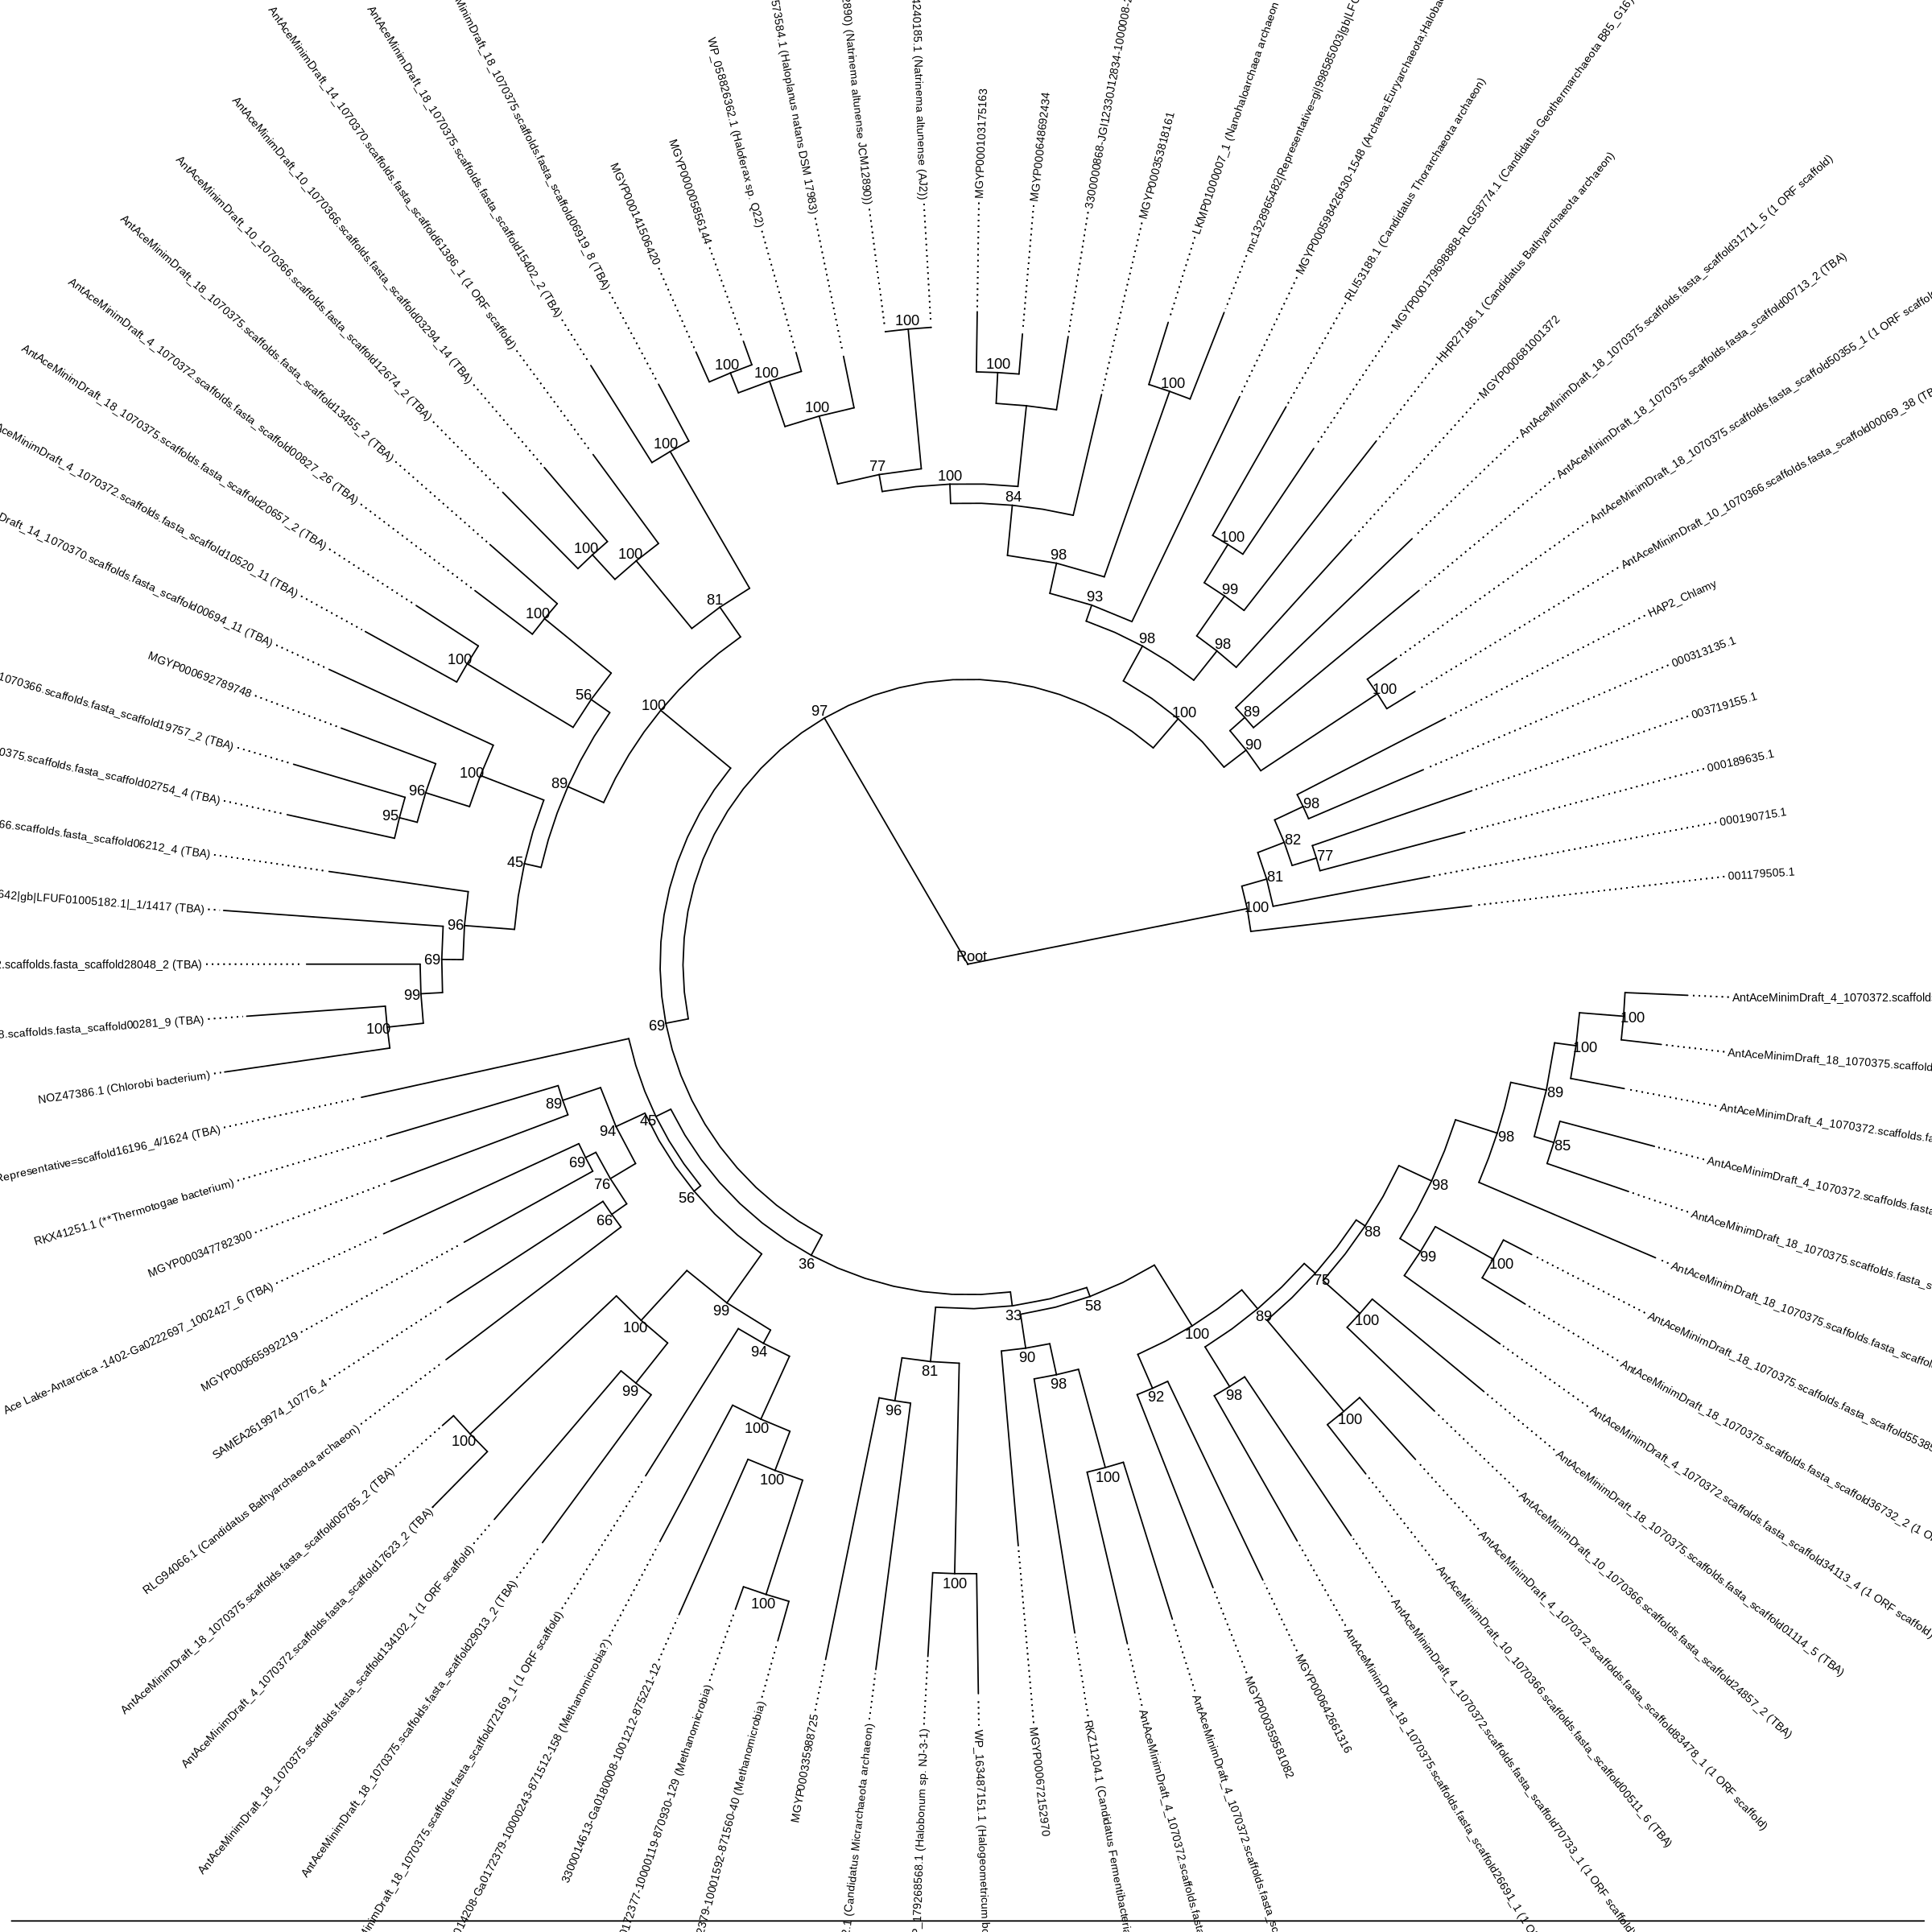

In [1383]:
# going to plot anyway and later on correct
treeplot_linsi_circular = ggtree(FsxA_kosher_linsi.tree, layout = 'circular') + 
                    geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) #+ 
                    #ggplot2::xlim(0, 6)#+ 
                    #theme(plot.margin = unit(c(14,8,14,8), "mm")) 

treeplot_linsi_circular = treeplot_linsi_circular %<+% ecological_data_to_plot.tibble + 
                                        geom_tiplab(size = 3, align = TRUE) + 
                                        theme_tree2(legend.position = "none",
                                                    axis.title.x = element_blank(),
                                                    axis.text.x = element_blank(),
                                                    axis.ticks.x = element_blank()) #+
                                        #scale_y_continuous(expand=c(0, 3)) +
                                        #geom_treescale(x=50, y=1) +
                                        #geom_tippoint(aes(size = SOLID), alpha=0.25) 

treeplot_linsi_circular 

# save tree in file
treeplot_linsi_circular %>% ggsave(filename = "../results/plots/FsxA_ecological_data_LINSI_circular_210709.pdf", 
                          plot = .,
                          width = 70, 
                          height = 50, 
                          units = "cm", 
                          limitsize = FALSE)

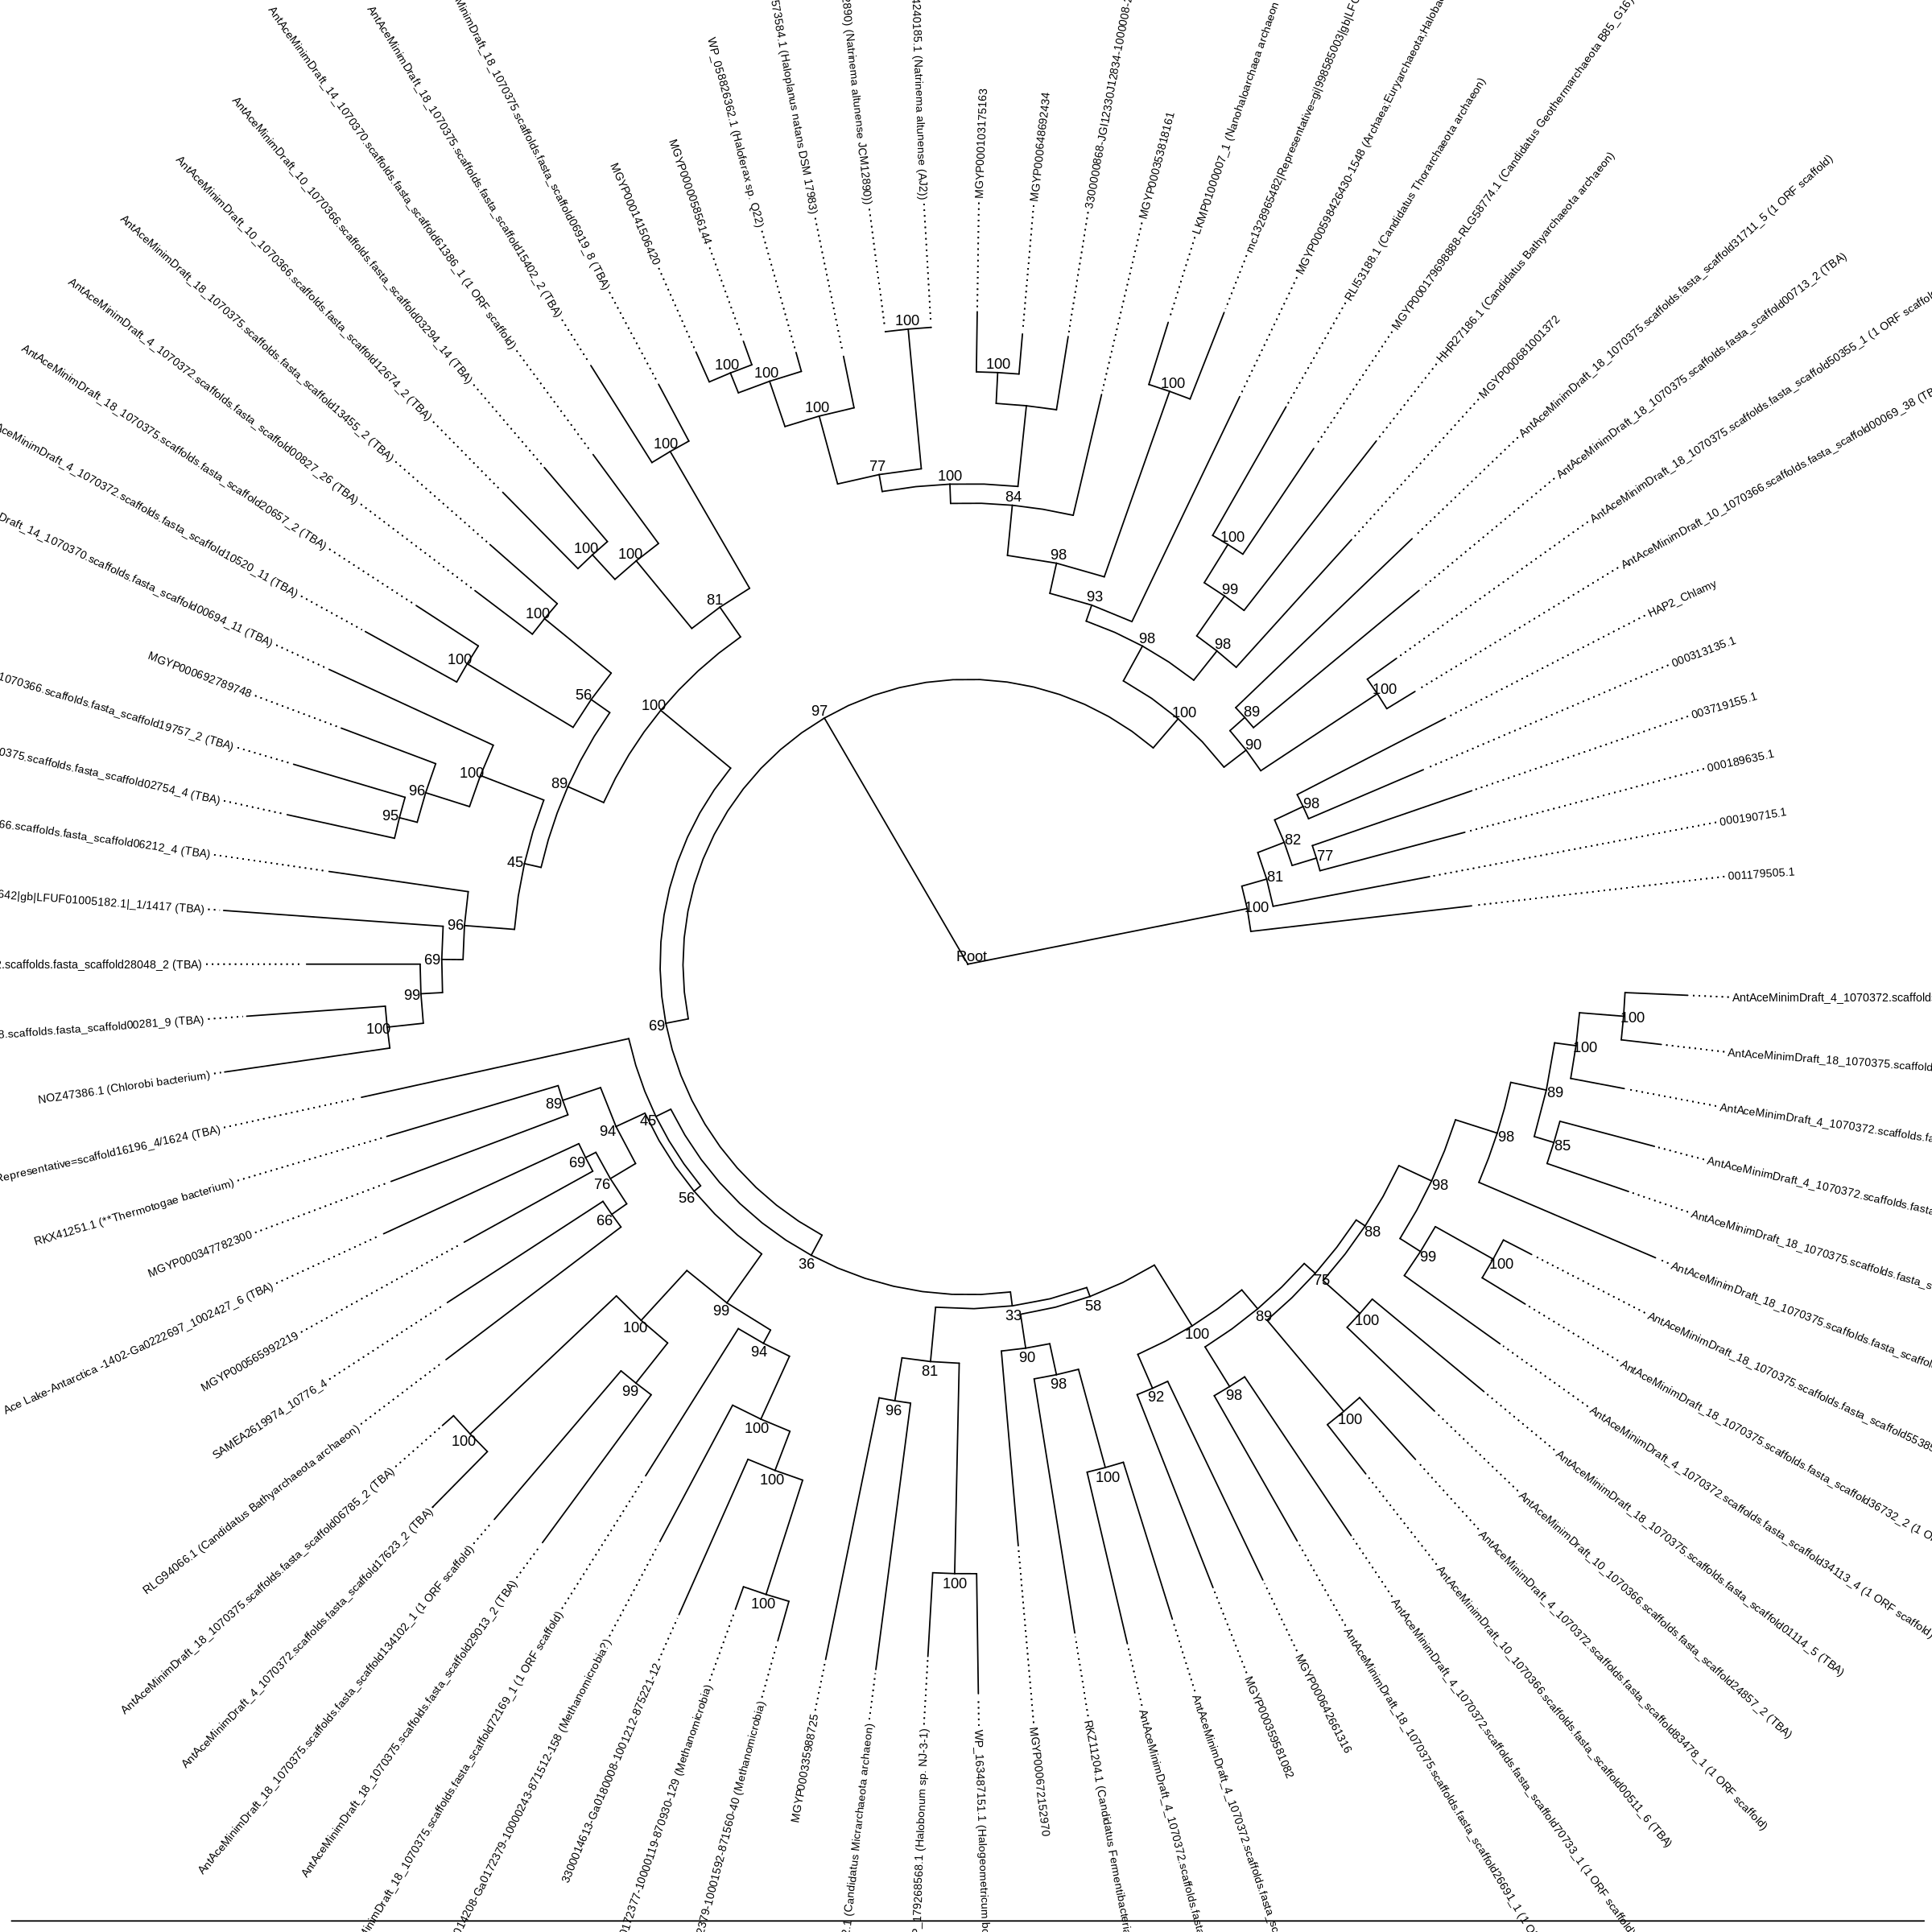

In [1384]:
treeplot_linsi_circular

In [1385]:
# going to plot anyway and later on correct
treeplot_linsi = ggtree(FsxA_kosher_linsi.tree) + 
                    geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) + 
                    ggplot2::xlim(0, 6.5) + 
                    geom_strip('003719155.1', '001179505.1', barsize=2, color='dodgerblue3', 
                             label = "HAP2s", offset.text=.1, offset = .25)#+ 
                    #theme(plot.margin = unit(c(14,8,14,8), "mm")) 

treeplot_linsi = treeplot_linsi %<+% ecological_data_to_plot.tibble + 
                                        geom_tiplab(size = 3, align = TRUE) + 
                                        theme_tree2(legend.position = "none",
                                                    axis.title.x = element_blank(),
                                                    axis.text.x = element_blank(),
                                                    axis.ticks.x = element_blank()) #+
                                        #scale_y_continuous(expand=c(0, 3)) +
                                        #geom_treescale(x=50, y=1) +
                                        #geom_tippoint(aes(size = SOLID), alpha=0.25) 

#treeplot_linsi 

# save tree in file
treeplot_linsi %>% ggsave(filename = "../results/plots/FsxA_ecological_data_LINSI_210709.pdf", 
                          plot = .,
                          width = 70, 
                          height = 50, 
                          units = "cm", 
                          limitsize = FALSE)

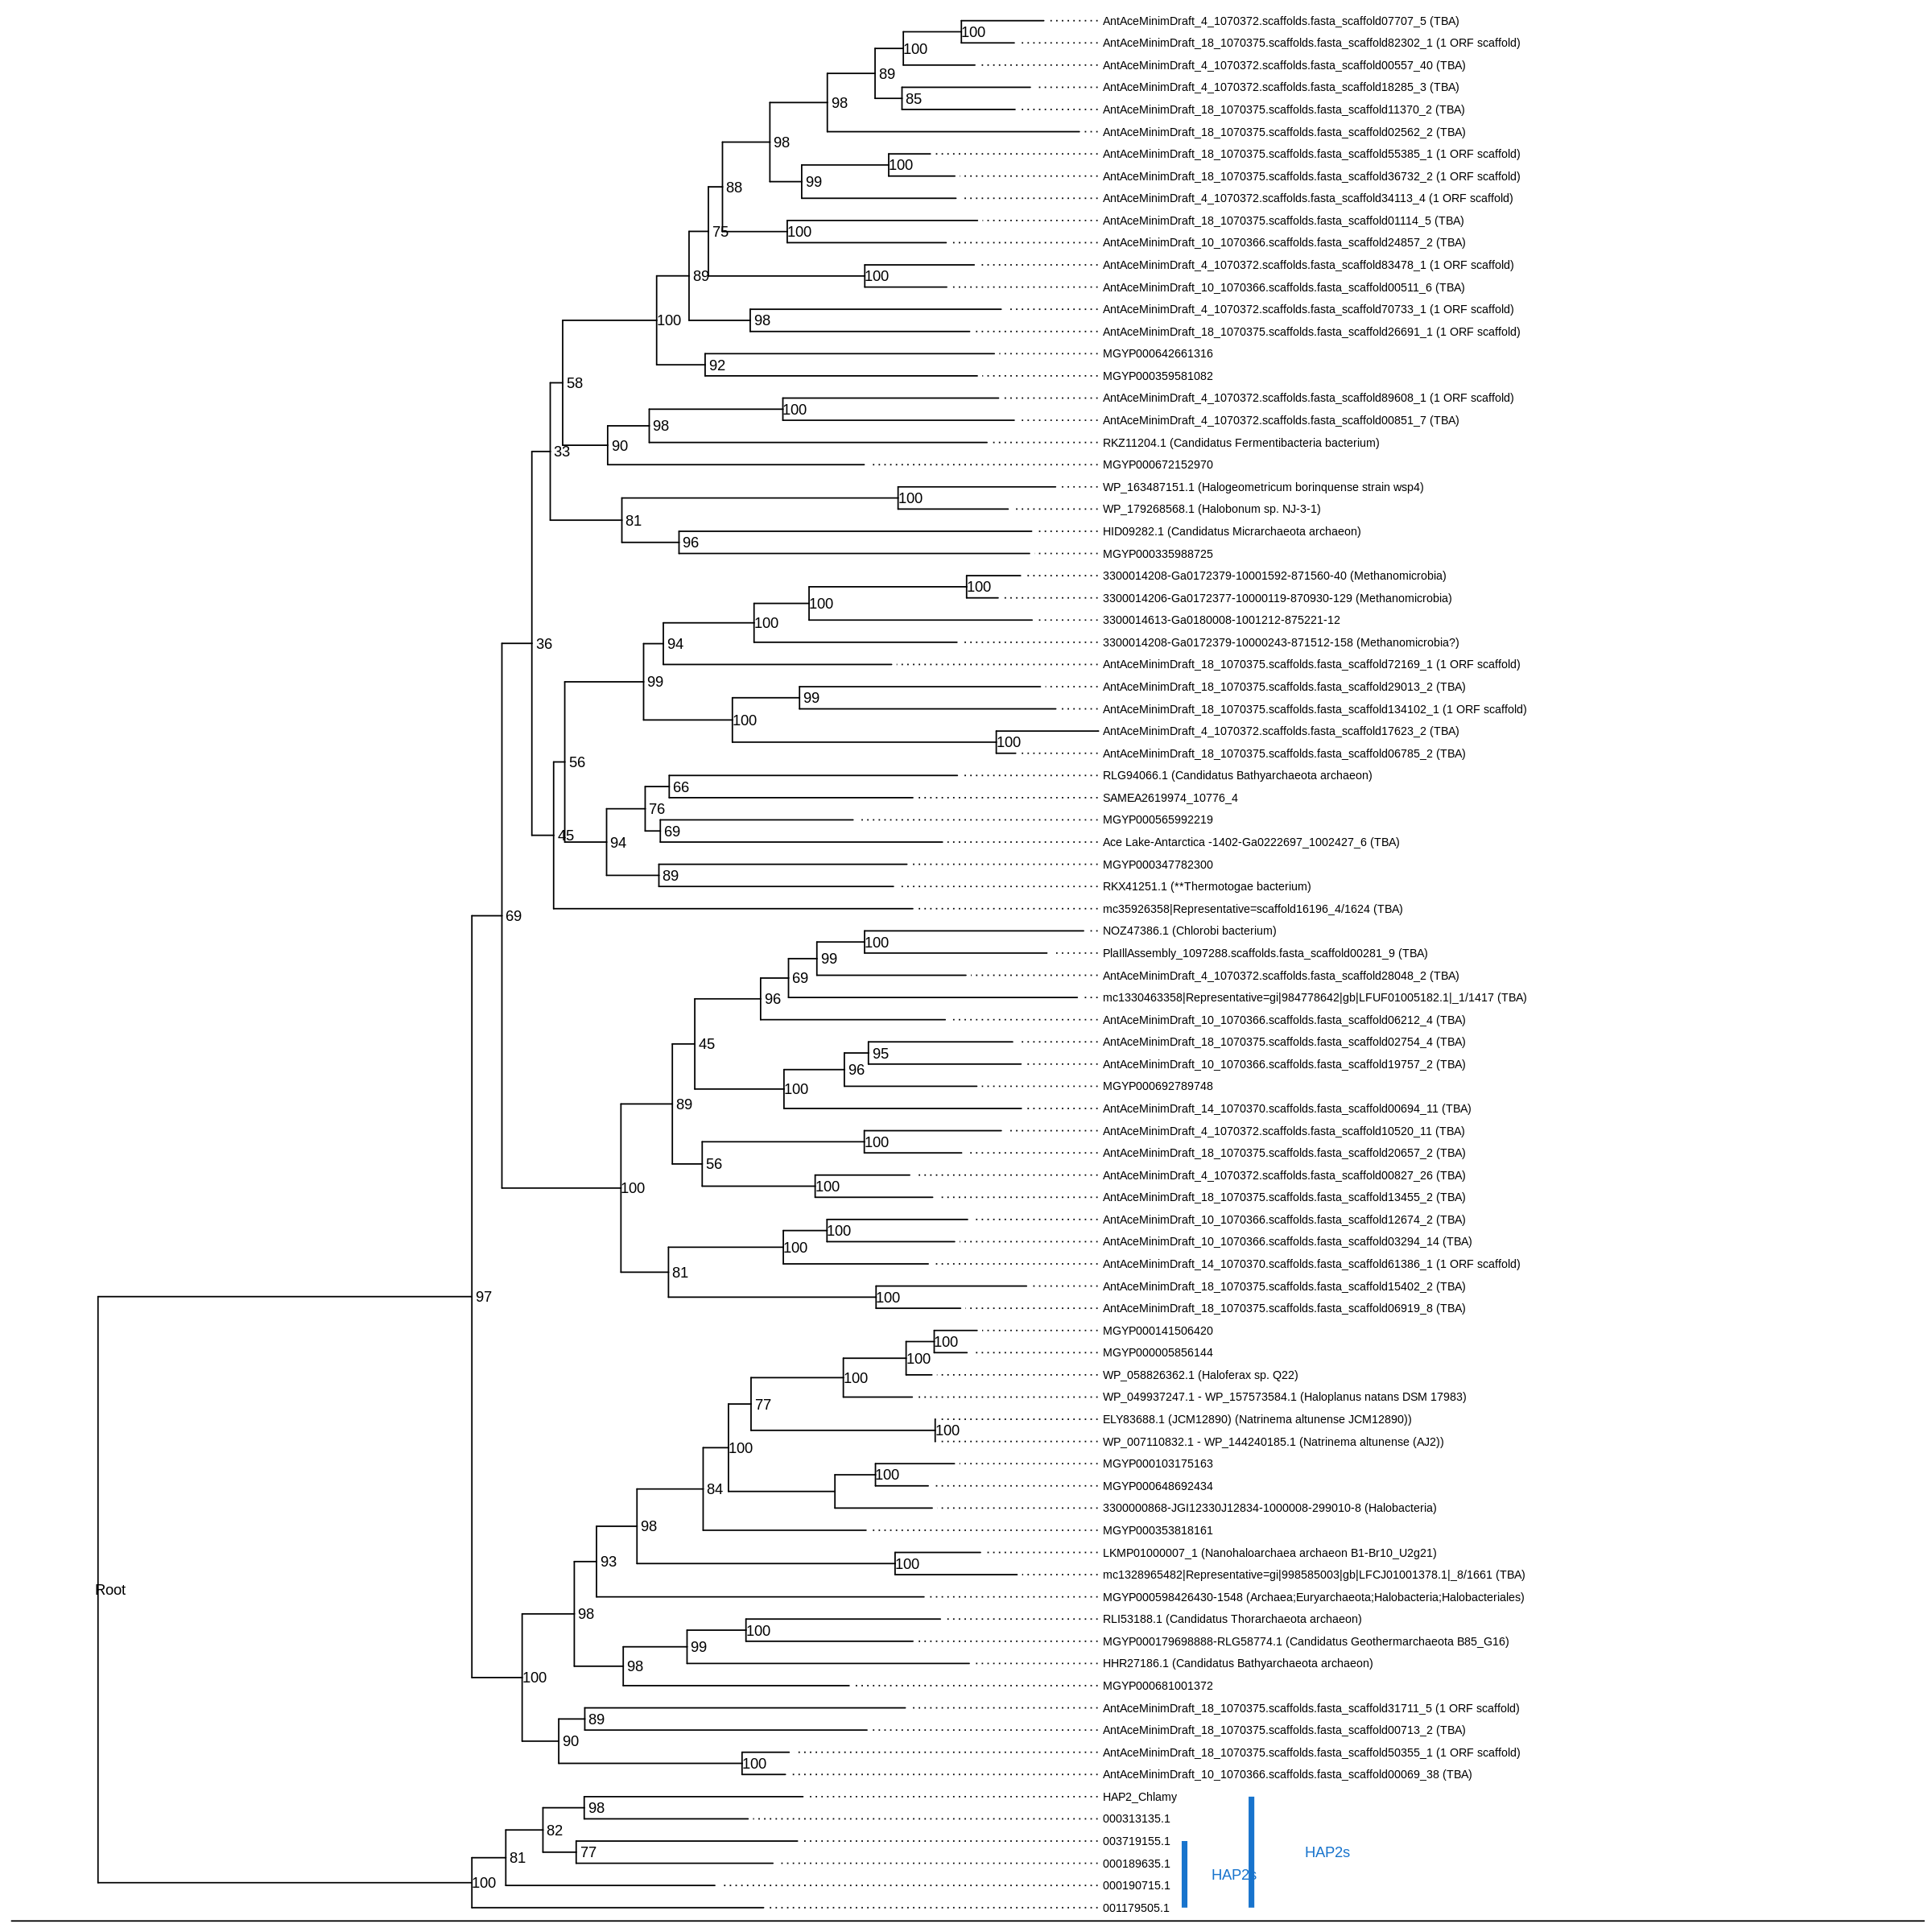

In [1386]:
treeplot_linsi + geom_strip('HAP2_Chlamy', '001179505.1', barsize=2, color='dodgerblue3', 
                             label = "HAP2s", offset.text=.2, offset = .5)

### Note of Pablo's key to each column
Columns of metadata were classified by Pablo and coded in the following way (as can be seen in the original XLSX, email communication)

**Keys**
- $O_2$:
    1. 1 = Aerobic
    2. 2 = Microaerophilic
    3. 3 = Anaerobic
    
- $T^o$:
    1. 1 = Cryophilic (Up to 15 Celsius)
    2. 2 = Mesophilic (16-40 Celsius)
    3. 3 - Thermophilic (More than 41 Celsius)

- SALT? -> Should create color code only to mark that organism is hypersaline
    1. Hypersaline: 1 = Yes
    2. Hypersaline: 2 = No
- Aqueous: -> should create color code only to show that sample is aqueous
    1. 1 = Yes
    2. 2 = No
- Solid: -> should create color code only to show that sample is solid
    1. 1 = Yes
    2. 2 = No
    
- pH:
    1. 1 = < 6.5
    2. 2 = 6.6 - 7.5
    3. 3 = > 7.6


### Color code philosophy
- Sample type: solid must be a color that resembles earth, and aqueous must be somehow blue
- pH: three different colors, one for acid, one for neutral (less bright, more vanilla) and one for basic (may be following code of comercial pH indicators)
    1. Acid = Red
    2. Neuter = Green
    3. Basic = Violet
- O2 
- Salt: Hypersaline equals gray, at it is somehow the color of salt grains


### Modifying table in order to make a meaningful plotting

In [1387]:
ecological_data_to_plot.tibble$`SALT?`

[1]  1  1  1  1  2  2  2  2  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2
[26]  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  2
[51]  2  2  2  2  2  2  3  2  1  2  2  2  2  2  2  2  2 NA NA NA NA NA NA  2  2
[76]  2  3  1  1  1  1  1  1  1  1  1

In [1388]:
library(naniar)
ecological_data_to_plot.tibble %<>%
    dplyr::left_join(x = .,
                     y = new_tip_label.tibble,
                     by = c('HEADER' = 'tip_label', 'TAXA' = 'TAXA')) %>%
    dplyr::mutate(., O2 = case_when(O2 == 1 ~ 'Aerobic', O2 == 2 ~ 'Microaerophilic', O2 == 3 ~ 'Anaerobic'),
                     T_Classified = case_when(T_Classified == 1 ~ 'Cryophilic', T_Classified == 2 ~ 'Mesophilic', T_Classified == 3 ~ 'Termophilic'),
                     AQUEOUS = case_when(AQUEOUS == 1 ~ 'Aqueous sample'),
                     pH = case_when(pH == 1 ~ '< 6.5', pH == 2 ~ '6.6 - 7.5', pH == 3 ~ '> 7.6'),
                     SOLID = case_when(SOLID == 1 ~ 'Solid sample'),
                     `SALT?` = case_when(`SALT?` == 1 ~ 'Extreme hypersaline (> 150 g/lt)', 
                                         `SALT?` == 2 ~ 'Moderate saline (30-150g/lt)', 
                                         `SALT?` == 3 ~ 'Freshwater (< 1g/lt)'),
                     `Sample type` = case_when(AQUEOUS == 'Aqueous sample' ~ 'Aqueous', SOLID == 'Solid sample' ~ 'Solid'))


In [1389]:
#ecological_data_to_plot.tibble

In [1390]:
ecological_data_to_plot.tibble$T_Classified %>% table()

.
 Cryophilic  Mesophilic Termophilic 
         55          22           3 

### Plotting

In [1391]:
# creating heatmaps with metadata
library(ggplot2)
library(ggnewscale)
# old code % #> Loading required package: ggnewscale
# old code % ecological_data_to_plot.tibble$`Sample type` %<>% as.factor()
# old code % ecological_data_to_plot.tibble$`Sample type` %<>% forcats::fct_relevel(., c('Solid', 'Aqueous'))
# old code % ecological_data_to_plot.tibble$O2 %<>% as.factor()
# old code % ecological_data_to_plot.tibble$O2 %<>% forcats::fct_relevel(., c('Anaerobic', 'Microaerophilic', 'Aerobic'))
# old code % ecological_data_to_plot.tibble$pH %<>% as.factor()
# old code % ecological_data_to_plot.tibble$pH %<>% forcats::fct_recode(., `< 6.5` = '1', `6.6 - 7.5` = '2', `> 7.6` = '3')
# old code % #ecological_data_to_plot.tibble$pH %<>% forcats::fct_relevel(., c('< 6.5', '6.6 - 7.5', '> 7.6'))
# old code % ecological_data_to_plot.tibble$`SALT?` %<>% as.factor()
# old code % ecological_data_to_plot.tibble$`SALT?` %<>% forcats::fct_relevel(., c('Freshwater (< 1g/lt)', 'Moderate saline (30-150g/lt)', 'Extreme hypersaline (> 150 g/lt)'))
# old code % ecological_data_to_plot.tibble$T_Classified %<>% as.factor()
# old code % ecological_data_to_plot.tibble$T_Classified %<>% forcats::fct_relevel(., c('Cryophilic', 'Mesophilic', 'Termophilic'))
# old code % 
# old code % #DBFF33 = acid
# old code % 
# old code % 
# old code % 
# old code % 
# old code % p_eco = ggplot(data = ecological_data_to_plot.tibble) + geom_tile(height = 1, width = .025, aes(x = 0, y = HEADER, fill = `Sample type`))
# old code % p_eco = p_eco + scale_fill_manual(values = c("#B46600", "708D81"))
# old code % p_eco = p_eco + new_scale_fill() 
# old code % 
# old code % p_eco = p_eco + geom_tile(height = 1, width = .025, aes(x=0.025, y=HEADER, fill=`SALT?`), data=ecological_data_to_plot.tibble) + 
# old code %             scale_fill_manual(values = c('#73C6B6', '#D7DBDD', '#AAB7B8')) +
# old code %             coord_cartesian(clip = "off")
# old code % 
# old code % p_eco = p_eco + new_scale_fill()  
# old code % 
# old code % p_eco = p_eco + geom_tile(height = 1, width = .025, aes(x=0.05, y=HEADER, fill=`O2`), data=ecological_data_to_plot.tibble) + 
# old code %             scale_fill_manual(values = c('#7b2cbf', '#3c096c', '#5f0f40')) +
# old code %             coord_cartesian(clip = "off")
# old code % 
# old code % p_eco = p_eco + new_scale_fill()  
# old code % 
# old code % # should force presence of three factors, somehow, in this one
# old code % 
# old code % p_eco = p_eco + geom_tile(height = 1, width = .025, aes(x=0.075, y=HEADER, fill=`pH`), data=ecological_data_to_plot.tibble) + 
# old code %             scale_fill_manual(values = c('#C70039', '#DAF7A6', '#A033FF')) + 
# old code %             coord_cartesian(clip = "off")
# old code % 
# old code % p_eco = p_eco + geom_tile(height = 1, width = .025, aes(x=0.1, y=HEADER, fill=`T_Classified`), data=ecological_data_to_plot.tibble) + 
# old code % #            scale_fill_manual(values = c('#5DADE2', '#FFC300', '#C70040')) + 
# old code %             scale_fill_viridis_d(option = 'magma') +
# old code %             coord_cartesian(clip = "off")
# old code % 
# old code % p_eco + theme_void()
# old code % 


In [1392]:
# creating specific datafrmes for each ecological variable to plot
df_habitat = ecological_data_to_plot.tibble %>% 
            dplyr::select(new_tip_label, `Habitat`) %>% 
            dplyr::mutate(`Habitat` = `Habitat` %>% as.factor()) %>%
            column_to_rownames('new_tip_label')

df_metagenomics_project = ecological_data_to_plot.tibble %>% 
            dplyr::select(new_tip_label, `METAGENOMICS PROJECT`) %>% 
            dplyr::mutate(`METAGENOMICS PROJECT` = `METAGENOMICS PROJECT` %>% as.factor()) %>%
            dplyr::rename(`Project` = 'METAGENOMICS PROJECT') %>%
            column_to_rownames('new_tip_label')

df_salt = ecological_data_to_plot.tibble %>% 
            dplyr::select(new_tip_label, `SALT?`) %>% 
            dplyr::mutate(`SALT?` = `SALT?` %>% as.factor() %>% forcats::fct_relevel(., c('Freshwater (< 1g/lt)', 'Moderate saline (30-150g/lt)', 'Extreme hypersaline (> 150 g/lt)'))) %>%
            dplyr::rename(Salinity = 'SALT?') %>% column_to_rownames('new_tip_label')

df_o2 = ecological_data_to_plot.tibble %>% 
            dplyr::select(new_tip_label, `O2`) %>% 
            dplyr::mutate(O2 = O2 %>% as.factor() %>% forcats::fct_relevel(., c('Anaerobic', 'Microaerophilic', 'Aerobic'))) %>%
            column_to_rownames('new_tip_label')


df_sampletype = ecological_data_to_plot.tibble %>% 
                    dplyr::select(new_tip_label, `Sample type`) %>% 
                    dplyr::mutate(`Sample type` = `Sample type` %>% as.factor() %>% forcats::fct_relevel(., c('Solid', 'Aqueous'))) %>%
                    column_to_rownames('new_tip_label') 

df_pH = ecological_data_to_plot.tibble %>% 
            dplyr::select(new_tip_label, `pH`) %>% 
            dplyr::mutate(pH = pH %>% as.factor() %>% forcats::fct_recode(., `< 6.5` = '1', `6.6 - 7.5` = '2', `> 7.6` = '3')) %>%
            column_to_rownames('new_tip_label') 

df_temperature = ecological_data_to_plot.tibble %>% 
                    dplyr::select(new_tip_label, `T_Classified`) %>% 
                    dplyr::mutate(`T_Classified` = `T_Classified` %>% as.factor() %>% forcats::fct_relevel(., c('Cryophilic', 'Mesophilic', 'Termophilic'))) %>%
                    dplyr::rename(Temperature = 'T_Classified') %>% 
                    column_to_rownames('new_tip_label') 

Warning message:
“Unknown levels in `f`: 1, 2, 3”


In [1393]:
levels(df_temperature$Temperature)

[1] "Cryophilic"  "Mesophilic"  "Termophilic"

In [1394]:
help(gheatmap)

gheatmap                package:ggtree                 R Documentation

_g_h_e_a_t_m_a_p

_D_e_s_c_r_i_p_t_i_o_n:

     append a heatmap of a matrix to right side of phylogenetic tree

_U_s_a_g_e:

     gheatmap(
       p,
       data,
       offset = 0,
       width = 1,
       low = "green",
       high = "red",
       color = "white",
       colnames = TRUE,
       colnames_position = "bottom",
       colnames_angle = 0,
       colnames_level = NULL,
       colnames_offset_x = 0,
       colnames_offset_y = 0,
       font.size = 4,
       family = "",
       hjust = 0.5,
       legend_title = "value"
     )
     
_A_r_g_u_m_e_n_t_s:

       p: tree view

    data: matrix or data.frame

  offset: offset of heatmap to tree

   width: total width of heatmap, compare to width of tree

     low: color of lowest value

    high: color of highest value

   color: color of heatmap cell border

colnames: logical, add matrix colnames or not

colnames_position: one of 'bottom' or 'top'

colnames_angle: angle of column names

colnames_level: levels of colnames

colnames_offset_x: x offset for column names

colnames_offset_y: y offset for column names

font.size: font size of matrix colnames

  family: font of matrix colnames

   hjust: hjust for column names (0: align left, 0.5: align center, 1:
          align righ)

legend_title: title of fill legend

_V_a_l_u_e:

     tree view

_A_u_t_h_o_r(_s):

     Guangchuang Yu

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



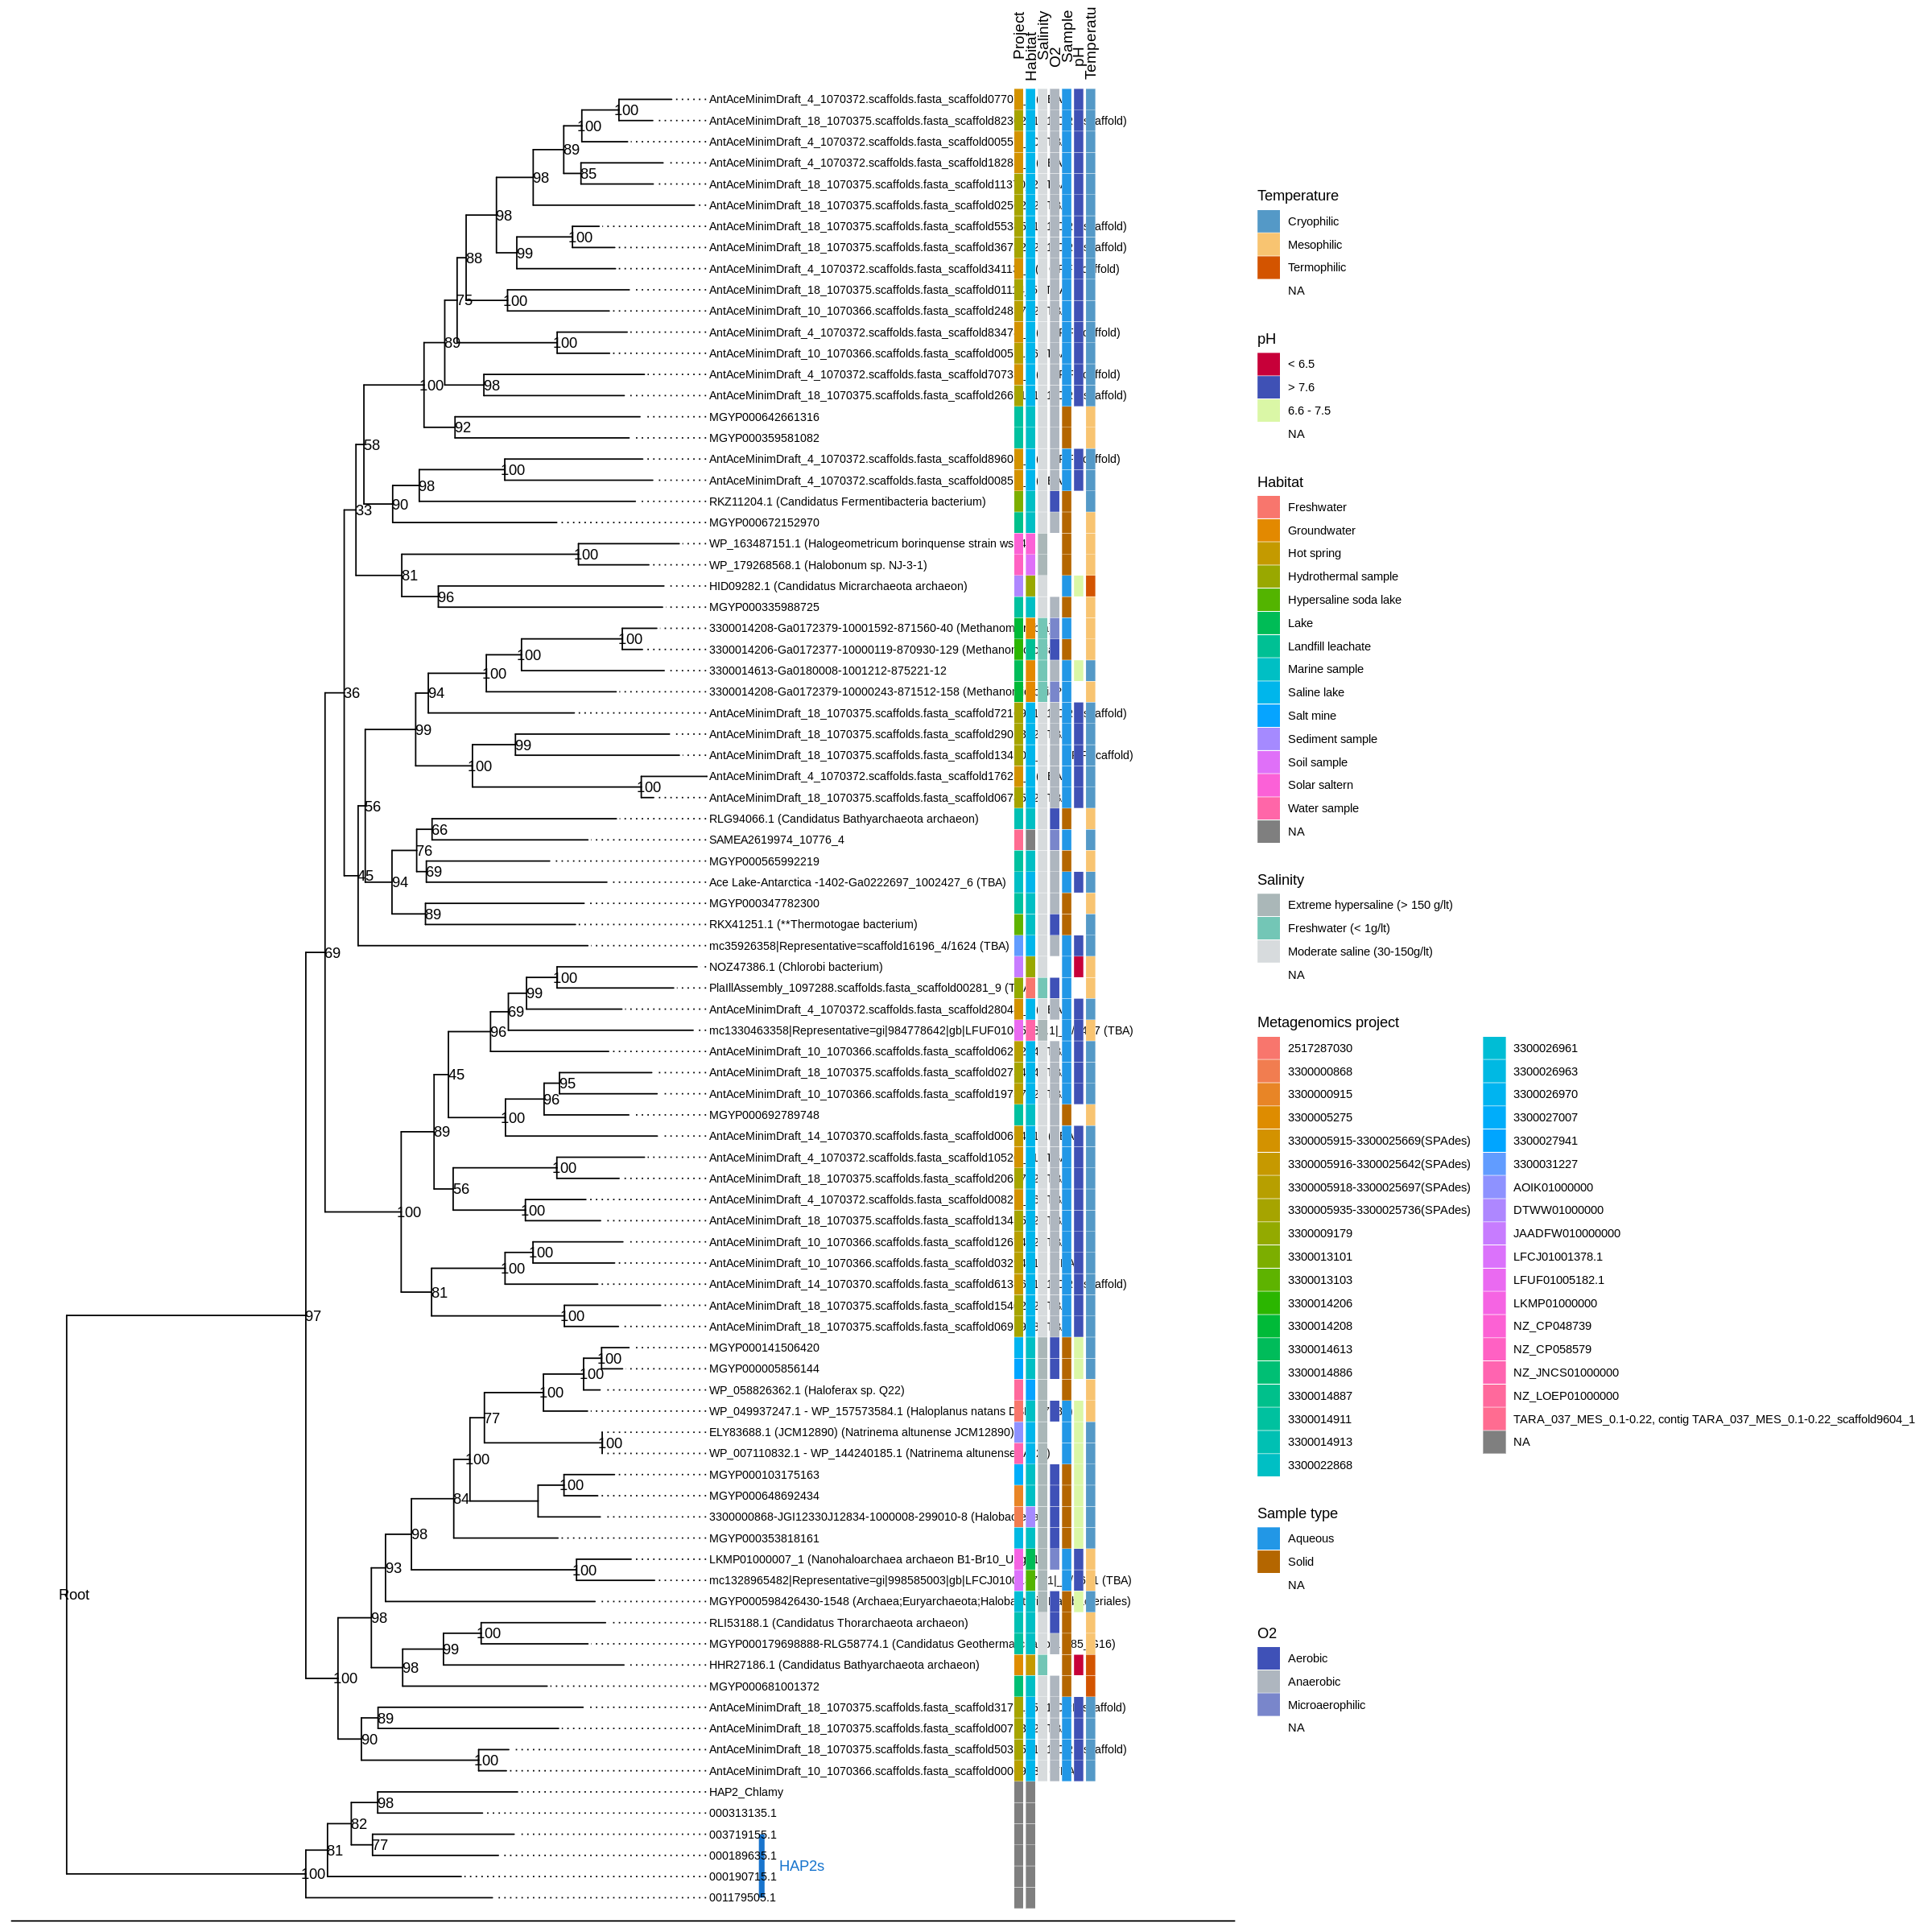

In [1395]:
# plotting tree with heatmap data (using gheatmap)
p01 <- gheatmap(treeplot_linsi, df_metagenomics_project, offset= (1.77 + 0.0), width=.015, colnames_position = 'top',
               colnames_angle=90, colnames_offset_y = 2) + scale_fill_discrete(name = 'Metagenomics project')

p02 <- p01 + new_scale_fill() + scale_fill_manual(name = 'Metagenomics project')

p02 = gheatmap(p02, df_habitat, offset=(1.77  + 0.07*1), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         theme(legend.position="bottom") + scale_fill_discrete(name = 'Habitat')

p1 <- p02 + new_scale_fill() 

p1 <- gheatmap(p1, df_salt, offset= (1.77  + 0.07*2), width=.015, colnames_position = 'top',
               colnames_angle=90, colnames_offset_y = 2) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

p2 <- p1 + new_scale_fill()
p2 = gheatmap(p2, df_o2, offset=(1.77  + 0.07*3), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#7986CB', 
                                                   'Aerobic' = '#3F51B7')) +  
         theme(legend.position="bottom")

p3 = p2 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(1.77  + 0.07*4), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2.75) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(1.77  + 0.07*5), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5')) +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(1.77  + 0.07*6), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

p5 %>% ggsave(filename = "../results/plots/FsxA_ecological_data_preliminar_210525_colores.pdf", 
                          plot = .,
                          width = 70, 
                          height = 50, 
                          units = "cm", 
                          limitsize = FALSE)

p5

### Annotating Metagenomics Project and Habitat as letters in the branches

In [1396]:
# creating dictionary
number_of_metagenome_projects = ecological_data_to_plot.tibble %>% dplyr::filter(!is.na(`BIOSAMPLE`)) %>% .$`BIOSAMPLE` %>% unique() %>% length()
tags_metagenome_projects = glue('MP {1:number_of_metagenome_projects}')
metagenome_projects.dict = tags_metagenome_projects 
names(metagenome_projects.dict) = ecological_data_to_plot.tibble %>% dplyr::filter(!is.na(`BIOSAMPLE`)) %>% .$`BIOSAMPLE` %>% unique()

In [1397]:
# creating aliases for Metagenome Project IDs
# create dictionary assigning

ecological_data_to_plot.tibble %>% 
                    dplyr::select(new_tip_label, `BIOSAMPLE`) %>%
                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                    dplyr::arrange(`Metagenome Project ID`)

# save this correlation table
ecological_data_to_plot.tibble %>% 
                    dplyr::select(new_tip_label, `BIOSAMPLE`) %>%
                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                    dplyr::arrange(`Metagenome Project ID`) %>%
                    readr::write_tsv('../results/metagenome_project_ID_tips_and_biosample_corr_table.tsv')

new_tip_label                                                                
1  3300000868-JGI12330J12834-1000008-299010-8 (Halobacteria)                    
2  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold17623_2 (TBA)             
3  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold83478_1 (1 ORF scaffold)  
4  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold18285_3 (TBA)             
5  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold07707_5 (TBA)             
6  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold00557_40 (TBA)            
7  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold34113_4 (1 ORF scaffold)  
8  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold70733_1 (1 ORF scaffold)  
9  AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold00851_7 (TBA)             
10 AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold89608_1 (1 ORF scaffold)  
11 AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold28048_2 (TBA)             
12 AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold00827_26 (TBA)            
13 AntAceMinimDraft_4_1070372.scaffolds.fasta_scaffold10520_11 (TBA)            
14 Ace Lake-Antarctica -1402-Ga0222697_1002427_6 (TBA)                          
15 MGYP000565992219                                                             
16 MGYP000347782300                                                             
17 MGYP000359581082                                                             
18 MGYP000642661316                                                             
19 MGYP000335988725                                                             
20 MGYP000692789748                                                             
21 SAMEA2619974_10776_4                                                         
22 RLG94066.1 (Candidatus Bathyarchaeota archaeon)                              
23 RLI53188.1 (Candidatus Thorarchaeota archaeon)                               
24 RKX41251.1 (**Thermotogae bacterium)                                         
25 mc35926358|Representative=scaffold16196_4/1624 (TBA)                         
26 RKZ11204.1 (Candidatus Fermentibacteria bacterium)                           
27 MGYP000672152970                                                             
28 HID09282.1 (Candidatus Micrarchaeota archaeon)                               
29 MGYP000648692434                                                             
30 WP_179268568.1 (Halobonum sp. NJ-3-1)                                        
⋮  ⋮                                                                            
57 AntAceMinimDraft_10_1070366.scaffolds.fasta_scaffold19757_2 (TBA)            
58 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold50355_1 (1 ORF scaffold) 
59 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold00713_2 (TBA)            
60 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold31711_5 (1 ORF scaffold) 
61 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold72169_1 (1 ORF scaffold) 
62 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold06785_2 (TBA)            
63 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold134102_1 (1 ORF scaffold)
64 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold29013_2 (TBA)            
65 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold01114_5 (TBA)            
66 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold11370_2 (TBA)            
67 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold82302_1 (1 ORF scaffold) 
68 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold02562_2 (TBA)            
69 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold36732_2 (1 ORF scaffold) 
70 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold55385_1 (1 ORF scaffold) 
71 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold26691_1 (1 ORF scaffold) 
72 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold06919_8 (TBA)            
73 AntAceMinimDraft_18_1070375.scaffolds.fasta_scaffold15402_2 (TBA)            
74 AntAceMinimDraft_18_1070375.sca

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Removed 91 rows containing missing values (geom_text).”
Warning message:
“Removed 92 rows containing missing values (geom_text).”
Warning message:
“Removed 91 rows containing missing values (geom_text).”
Warning message:
“Removed 92 rows containing missing values (geom_text).”


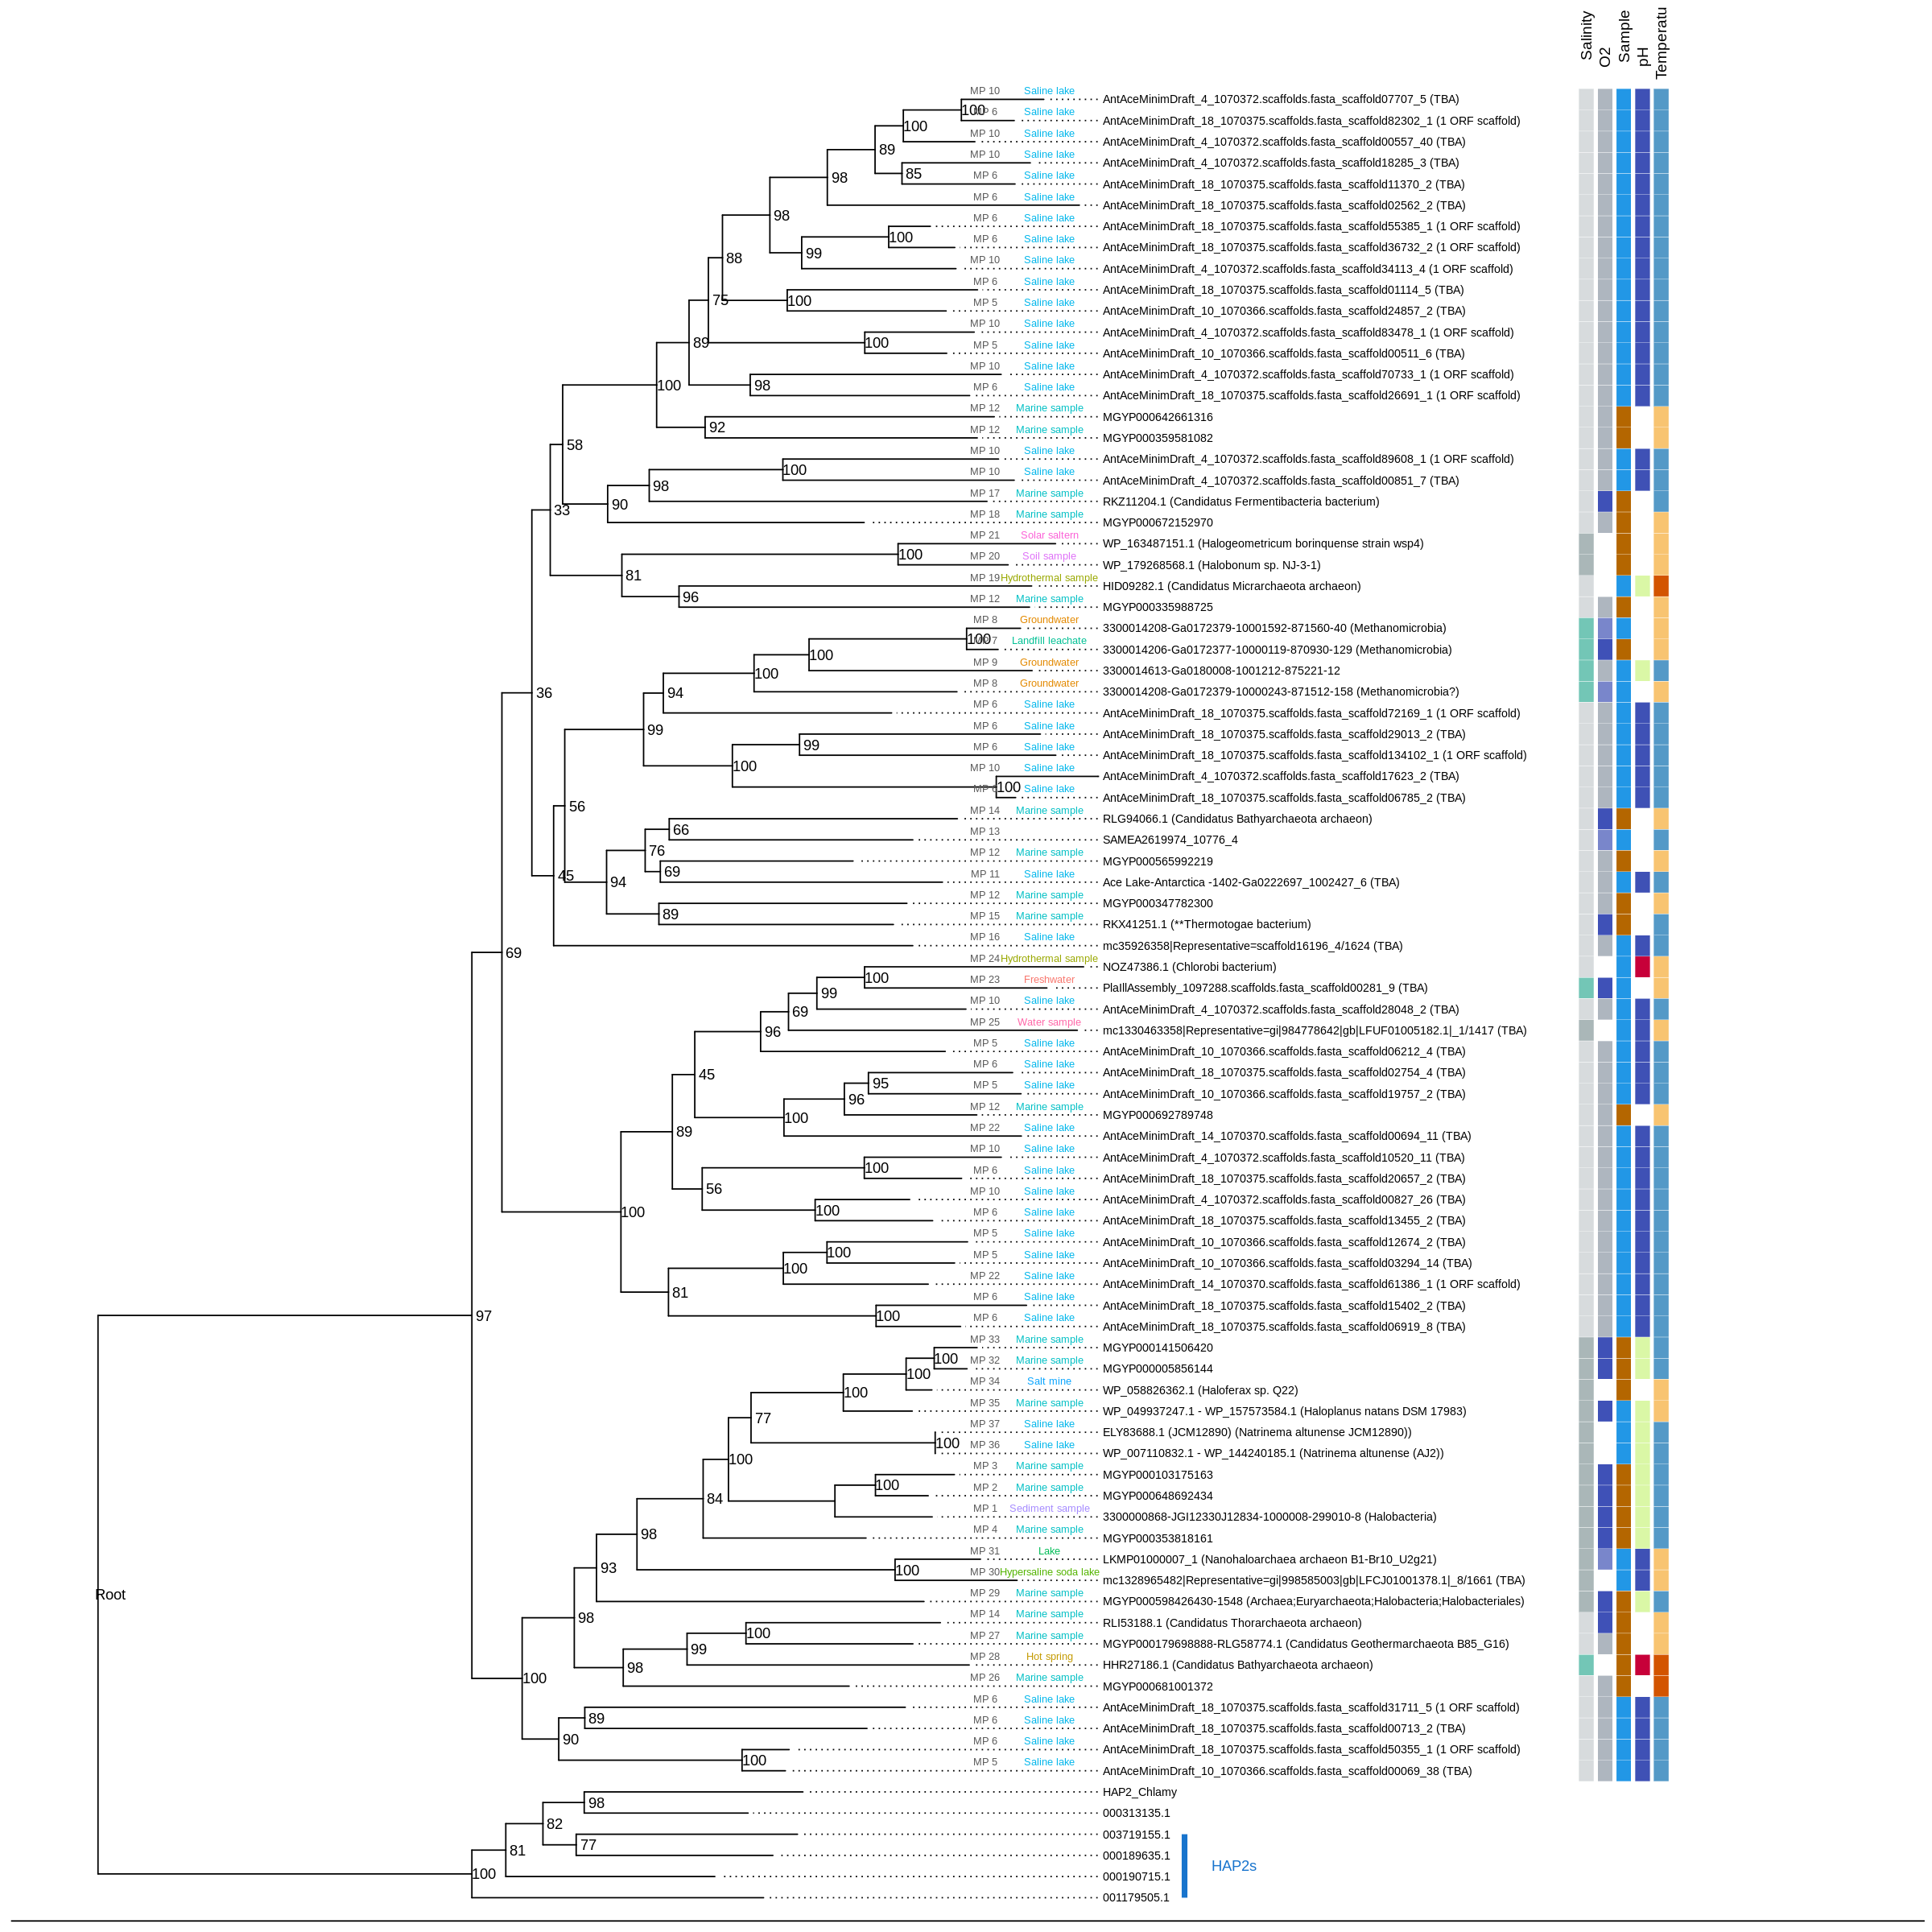

In [1398]:
# first creating a data frame for that purpose
ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `BIOSAMPLE`, `Habitat`) %>%
                                                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                                                    dplyr::rename(`Project` = 'Metagenome Project ID') %>%
                                                    as.data.frame()

ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    

# loading library and creating a phylo4d object
#library(phylobase)

#treeplot_linsi = treeplot_linsi %<+% ecodata_metagenomics_projects_and_habitats_df + geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2)
#treeplot_linsi

# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (1.77  + 0.07*0), width=.015, colnames_position = 'top',
               colnames_angle=90, colnames_offset_y = 2) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

p2 <- p1 + new_scale_fill()
p2 = gheatmap(p2, df_o2, offset=(1.77  + 0.07*1), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#7986CB', 
                                                   'Aerobic' = '#3F51B7')) +  
         theme(legend.position="bottom")

p3 = p2 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(1.77  + 0.07*2), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2.75) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(1.77  + 0.07*3), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5')) +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(1.77  + 0.07*4), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

#p5 = p5 %<+% ecodata_metagenomics_projects_and_habitats_df + 
#                       geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2) 

p5 = p5 %<+% ecodata_metagenomics_projects_df + 
                       geom_text(color = 'gray35', aes(label=`Project`, x = 3.20 + 0.115), vjust=-0.7, size=2.7) +
                       theme(legend.position = 'none')

p5 = p5 %<+% ecodata_habitats_df + 
                       geom_text(aes(color=`Habitat`, label=`Habitat`, x = 3.44 + 0.115), vjust=-0.7, size=2.7) +
                       theme(legend.position = 'none')

p5 %>% ggsave(filename = "../results/plots/FsxA_ecological_data_preliminar_210526_labels.pdf", 
                          plot = .,
                          width = 70, 
                          height = 50, 
                          units = "cm", 
                          limitsize = FALSE)

p5


### With circular layout

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



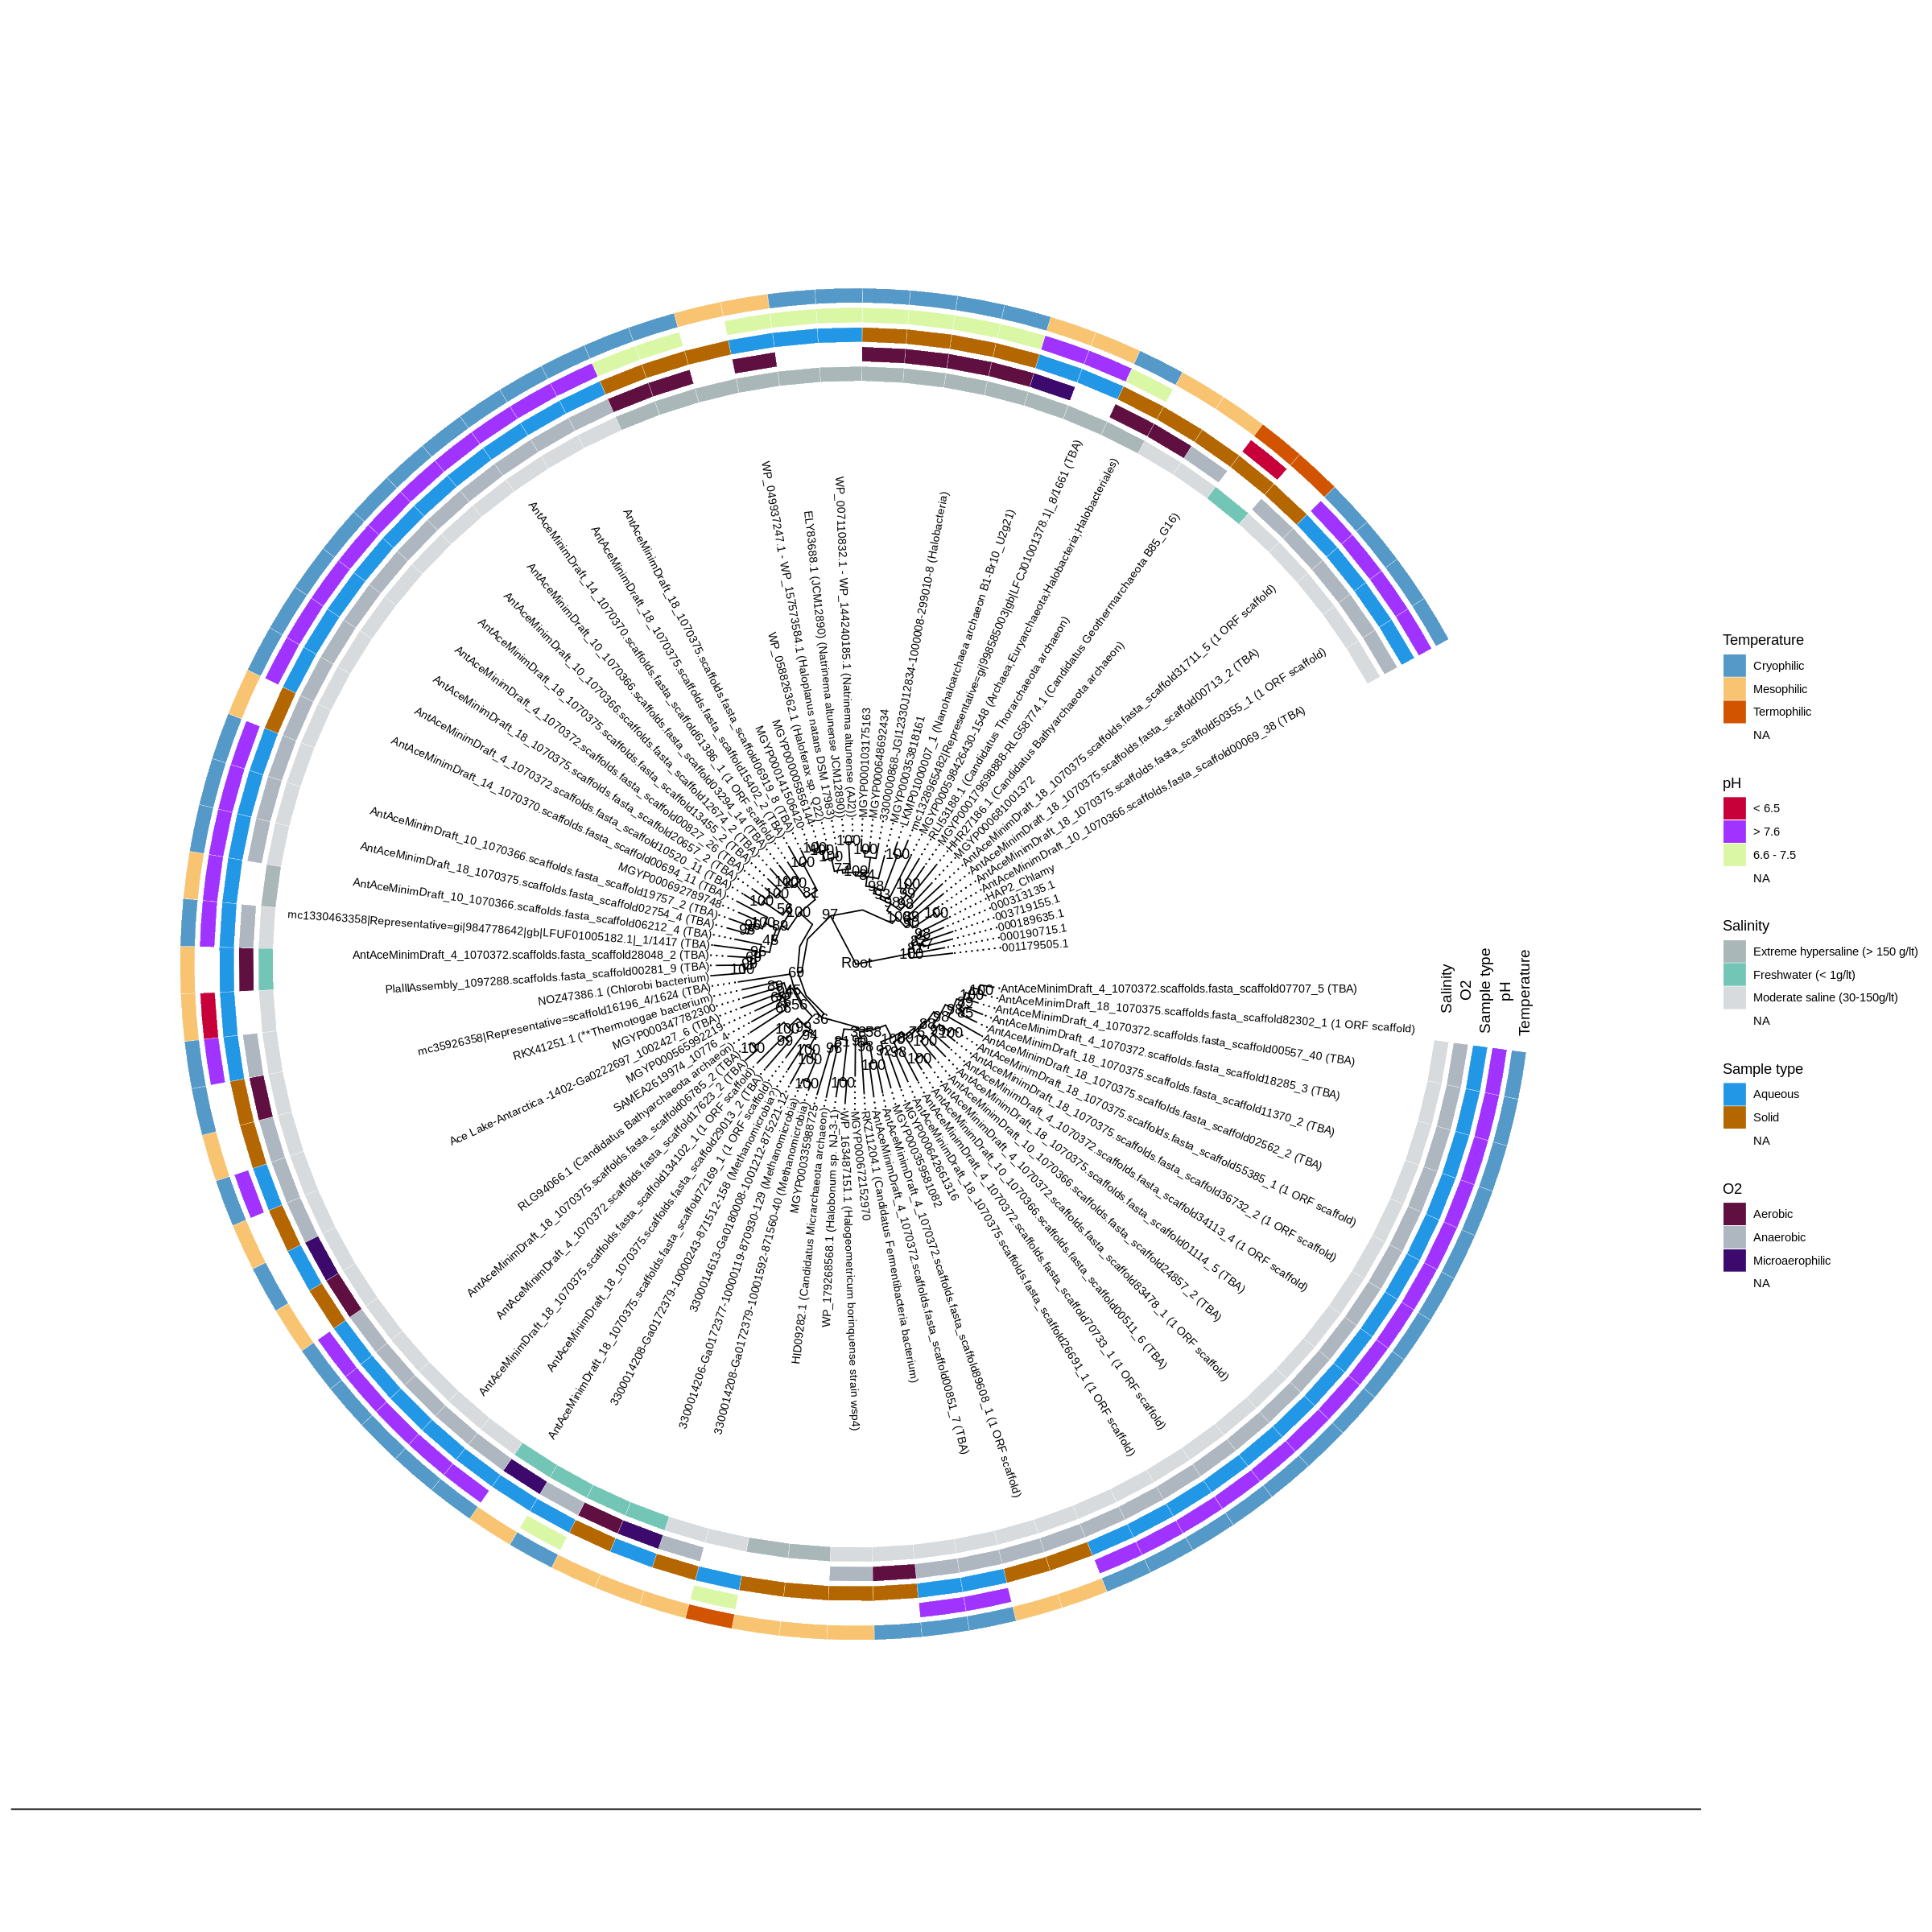

In [1399]:
# plotting tree with heatmap data (using gheatmap)
p1c <- gheatmap(treeplot_linsi_circular, df_salt, offset= 11, width=0.1, colnames_position = 'top',
               colnames_angle=90, colnames_offset_y = 0.75, font.size = 4) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

p2c <- p1c + new_scale_fill()
p2c = gheatmap(p2c, df_o2, offset=11.5, width=0.1, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 0.75, font.size = 4) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#3c096c', 
                                                   'Aerobic' = '#5f0f40')) +  
         theme(legend.position="bottom")

p3c = p2c + new_scale_fill()
p3c = gheatmap(p3c, df_sampletype, offset=12, width=0.1, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 0.75, font.size = 4) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4c = p3c + new_scale_fill()
p4c = gheatmap(p4c, df_pH, offset=12.5, width=0.1, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 0.75, font.size = 4) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#A033FF')) +  
         theme(legend.position="bottom")

p5c = p4c + new_scale_fill()

p5c = gheatmap(p5c, df_temperature, offset=13, width=0.1, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 0.75, font.size = 4) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

p5c %>% ggsave(filename = "../results/plots/FsxA_ecological_data_circular_pruebaborrar_210709.pdf", 
                          plot = .,
                          width = 70, 
                          height = 70, 
                          units = "cm", 
                          limitsize = FALSE)

#p2
p5c

In [1400]:
# plotting tree with heatmap data
# old code# library(aplot)
# old code# library(lemon)
# old code# 
# old code# p_eco_modif = p_eco + theme(axis.title.y = element_blank(),
# old code#                                 axis.text.y = element_blank(),
# old code#                                 axis.ticks.y = element_blank(),
# old code#                                 legend.position = 'bottom') +
# old code#                           theme_void()
# old code# 
# old code# #prueba = p_eco_modif %>%
# old code# #          aplot::insert_left(treeplot_linsi, width = 5) 
# old code# 
# old code# prueba = 
# old code# 
# old code# prueba
# old code# 
# old code# prueba %>% ggsave(filename = "../results/plots/FsxA_ecological_data_pruebaborrar.pdf", 
# old code#                           plot = .,
# old code#                           width = 70, 
# old code#                           height = 50, 
# old code#                           units = "cm", 
# old code#                           limitsize = FALSE)
# old code# 


# Alternative plots

Loading geographical relevant data to incoporate

In [1401]:
geodata.tibble = readr::read_tsv('../results/geodata_table.tsv', col_names = TRUE)


── Column specification ────────────────────────────────────────────────────────
cols(
  `BioSample ID` = col_character(),
  `Geographical location` = col_character(),
  Latitude = col_character(),
  Longitude = col_character(),
  `Isolation source` = col_character(),
  Title = col_character(),
  `Taxa ID` = col_character(),
  Organism = col_character()
)




In [1402]:
head(geodata.tibble)

BioSample ID Geographical location Latitude    Longitude   
1 SAMN06268799 USA:Emeryville, CA    37.840854 N 122.289843 W
2 SAMN07630777 Canada: Ontario       43.4420 N   80.5770 W   
3 SAMN07630779 Canada: Ontario       43.4420 N   80.5770 W   
4 SAMN07630779 Canada: Ontario       43.4420 N   80.5770 W   
5 SAMN07631793 Sweden: Stordalen     68.3500 N   19.0500 E   
6 SAMN07630784 Sweden: Oskarshamn    57.4344 N   16.6600 E   
  Isolation source                                    
1 Eden Landing Ponds, San Francisco, CA, USA          
2 composite cistern                                   
3 aquifer                                             
4 aquifer                                             
5 Mire fen                                            
6 Aspo Hard Rock Laboratory (HRL) deep subsurface site
  Title                                                                                                                                 
1 Aerobic enrichment media from Eden Landing Ponds, California, USA - A23 E1                                                            
2 Leachate microbial communities from a municipal landfill in Southern Ontario, Canada - Pumphouse #3 metaG                             
3 Groundwater microbial communities from an aquifer near a municipal landfill in Southern Ontario, Canada - Groundwater well OW334 metaG
4 Groundwater microbial communities from an aquifer near a municipal landfill in Southern Ontario, Canada - Groundwater well OW334 metaG
5 Permafrost microbial communities from Stordalen Mire, Sweden - 712E3D metaG                                                           
6 Groundwater microbial communities from the Aspo Hard Rock Laboratory (HRL) deep subsurface site, Sweden - MM_PW_MetaG                 
  Taxa ID Organism              
1 655179  air metagenome        
2 1817679 landfill metagenome   
3 717931  groundwater metagenome
4 717931  groundwater metagenome
5 1082480 permafrost metagenome 
6 717931  groundwater metagenome

## Rectangular plot

In [1403]:
# first creating a data frame for that purpose
# ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
#                                                     dplyr::select(new_tip_label, `BIOSAMPLE`, `Habitat`) %>%
#                                                     dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
#                                                     dplyr::rename(`Project` = 'Metagenome Project ID') %>%
#                                                     as.data.frame()
# 
# ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
#                                                     dplyr::select(new_tip_label, `Habitat`) %>%
#                                                     dplyr::rename(`Habitat` = 'Habitat') %>%
#                                                     as.data.frame()
#                                                     
# ecodata_geodata_df = ecological_data_to_plot.tibble %>%
#                             dplyr::select(new_tip_label, BIOSAMPLE) %>%
#                             dplyr::left_join(x = .,
#                                              y = geodata.tibble,
#                                              by = c('BIOSAMPLE' = 'BioSample ID')) %>%
#                             as.data.frame()
# 
# d2 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label, BIOSAMPLE) %>% dplyr::rename(label = 'new_tip_label', newlab = 'BIOSAMPLE')
# 
# d2 %<>% 
#     dplyr::mutate(newlab = newlab %>% str_replace_all(., ' y ', '+')) %>%
#     dplyr::mutate(newlab = case_when(is.na(newlab) ~ label,
#                                      TRUE ~ newlab))
# 
# # rename tree
# library(treeio)
# tr3 = treeio::rename_taxa(FsxA_kosher_linsi.tree, d2, label, newlab)
# FsxA_kosher_linsi.tree = tr3
# 
# # replotting tree with BioSample ID as tip label
# # going to plot anyway and later on correct
# treeplot_linsi = ggtree(FsxA_kosher_linsi.tree) + 
#                     geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) + 
#                     ggplot2::xlim(0, 6.5) + 
#                     geom_strip('003719155.1', '001179505.1', barsize=2, color='dodgerblue3', 
#                              label = "HAP2s", offset.text=.1, offset = .25)#+ 
#                     #theme(plot.margin = unit(c(14,8,14,8), "mm")) 
# 
# 
# 
# treeplot_linsi = treeplot_linsi %<+% ecological_data_to_plot.tibble + 
#                                         geom_tiplab(size = 3, align = TRUE) + 
#                                         theme_tree2(legend.position = "none",
#                                                     axis.title.x = element_blank(),
#                                                     axis.text.x = element_blank(),
#                                                     axis.ticks.x = element_blank()) #+
#                                         #scale_y_continuous(expand=c(0, 3)) +
#                                         #geom_treescale(x=50, y=1) +
#                                         #geom_tippoint(aes(size = SOLID), alpha=0.25) 
# treeplot_linsi

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



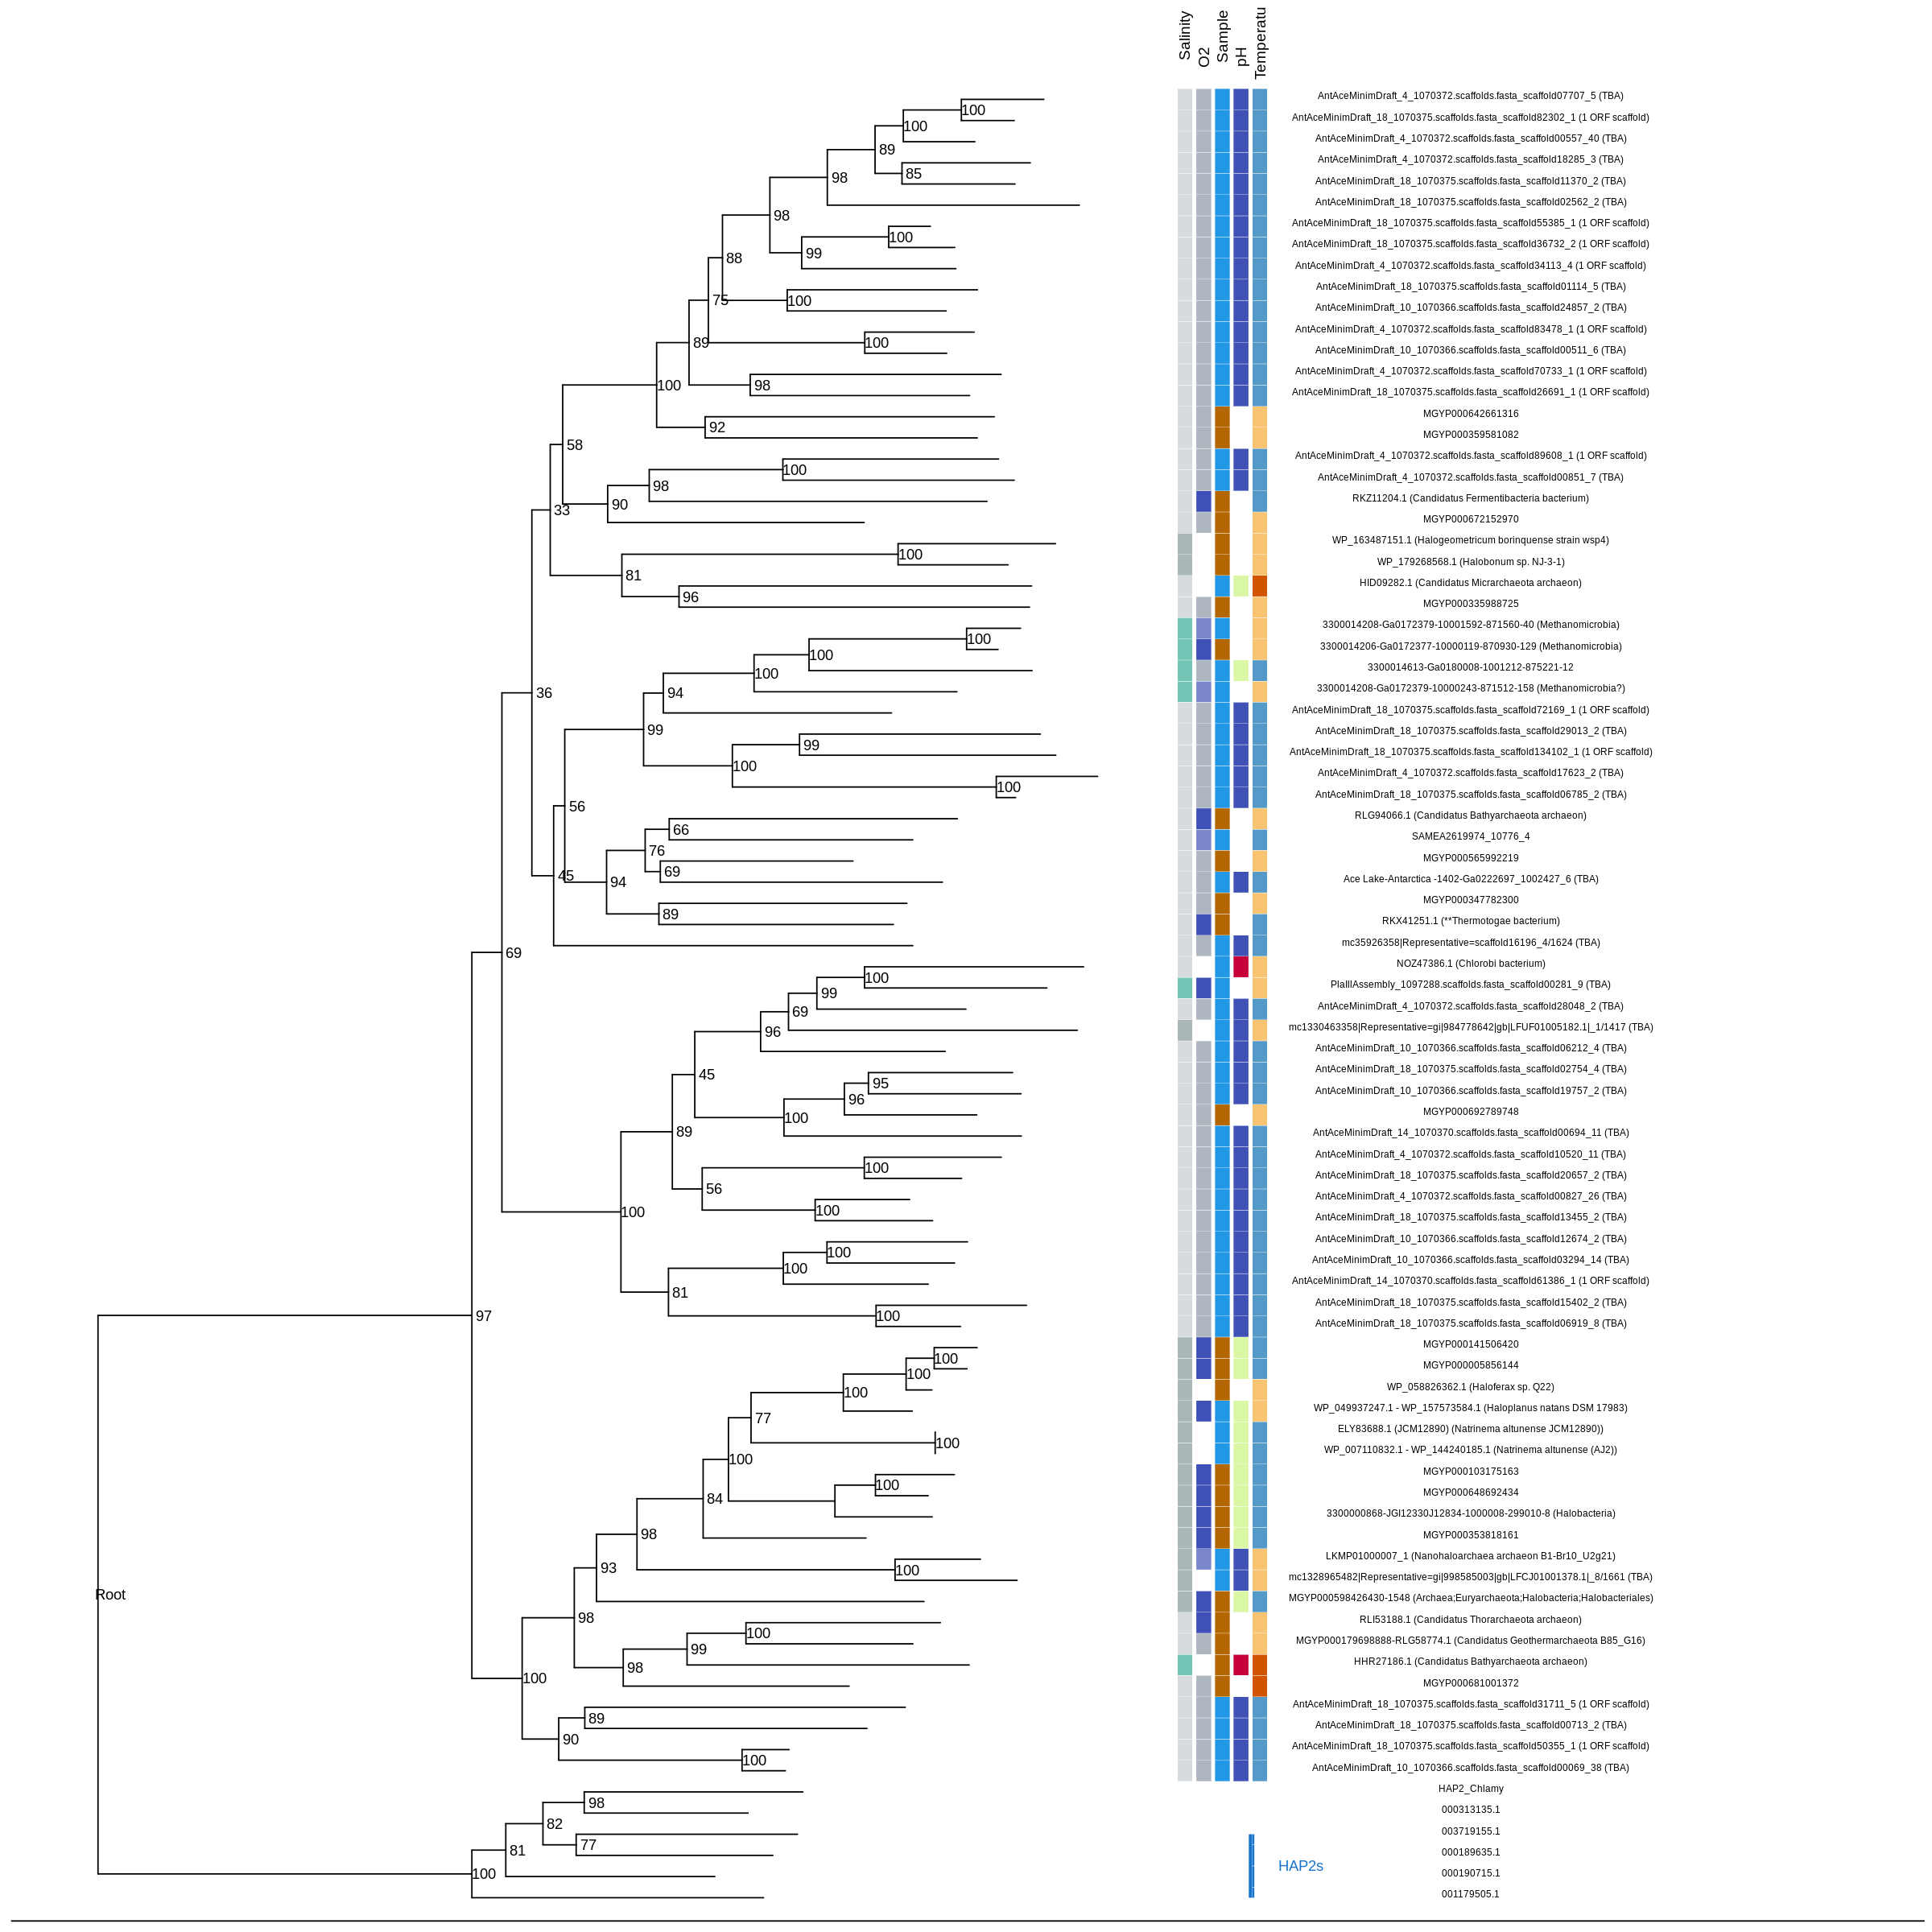

In [1404]:
# first creating a data frame for that purpose
ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `BIOSAMPLE`, `Habitat`) %>%
                                                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                                                    dplyr::rename(`Project` = 'Metagenome Project ID') %>%
                                                    as.data.frame()

ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    
ecodata_geodata_df = ecological_data_to_plot.tibble %>%
                            dplyr::select(new_tip_label, BIOSAMPLE) %>%
                            dplyr::left_join(x = .,
                                             y = geodata.tibble,
                                             by = c('BIOSAMPLE' = 'BioSample ID')) %>%
                            as.data.frame()

# loading library and creating a phylo4d object
#library(phylobase)

#treeplot_linsi = treeplot_linsi %<+% ecodata_metagenomics_projects_and_habitats_df + geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2)
#treeplot_linsi

d2 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label, BIOSAMPLE) %>% dplyr::rename(label = 'new_tip_label', newlab = 'BIOSAMPLE')

d2 %<>% 
    dplyr::mutate(newlab = newlab %>% str_replace_all(., ' y ', '+')) %>%
    dplyr::mutate(newlab = case_when(is.na(newlab) ~ label,
                                     TRUE ~ newlab)) %>%
    as.data.frame()


treeplot_linsi = ggtree(FsxA_kosher_linsi.tree) + 
                    geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) + 
                    ggplot2::xlim(0, 6.5) + 
                    geom_strip('003719155.1', '001179505.1', barsize=2, color='dodgerblue3', 
                             label = "HAP2s", offset.text=.1, offset = .5)#+ 
                    #theme(plot.margin = unit(c(14,8,14,8), "mm")) 



treeplot_linsi = treeplot_linsi %<+% ecological_data_to_plot.tibble + 
                                        #geom_tiplab(size = 3, align = TRUE) + 
                                        theme_tree2(legend.position = "none",
                                                    axis.title.x = element_blank(),
                                                    axis.text.x = element_blank(),
                                                    axis.ticks.x = element_blank()) #+
                                        #scale_y_continuous(expand=c(0, 3)) +
                                        #geom_treescale(x=50, y=1) +
                                        #geom_tippoint(aes(size = SOLID), alpha=0.25) 


# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (1.77  + 0.07*0 -1.5), width=.015, colnames_position = 'top',
               colnames_angle=90, colnames_offset_y = 2) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

p2 <- p1 + new_scale_fill()
p2 = gheatmap(p2, df_o2, offset=(1.77  + 0.07*1 -1.5), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#7986CB', 
                                                   'Aerobic' = '#3F51B7')) +  
         theme(legend.position="bottom")

p3 = p2 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(1.77  + 0.07*2 -1.5), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2.75) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(1.77  + 0.07*3 -1.5), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5')) +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(1.77  + 0.07*4 -1.5), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

#p5 = p5 %<+% ecodata_metagenomics_projects_and_habitats_df + 
#                       geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2) 

# p5 = p5 %<+% ecodata_metagenomics_projects_df + 
#                        geom_text(color = 'gray35', aes(label=`Project`, x = 3.20-0.30 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')
# 
# p5 = p5 %<+% ecodata_habitats_df + 
#                        geom_text(aes(color=`Habitat`, label=`Habitat`, x = 3.44 + 0.075 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')

p5 = p5 %<+% d2 + 
                       geom_text2(aes(subset = isTip, label=`label`, x = 4.44 + 0.075 + 0.115  + 0.5), vjust=0, size=2.5) +
                       theme(legend.position = 'none')

#p5 = p5 %<+% ecodata_geodata_df + 
#                       geom_text(aes(color=`Geographical location`, label=`Geographical location`, x = 3.20 + 0.01 + 0.115), vjust=-0.7, size=2.7) +
#                       theme(legend.position = 'none')

p5 %>% ggsave(filename = "../results/plots/FsxA_ecological_data_preliminar_210709_labels_con_sample_location.pdf", 
                          plot = .,
                          width = 70, 
                          height = 50, 
                          units = "cm", 
                          limitsize = FALSE)

p5


## Circular plot

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



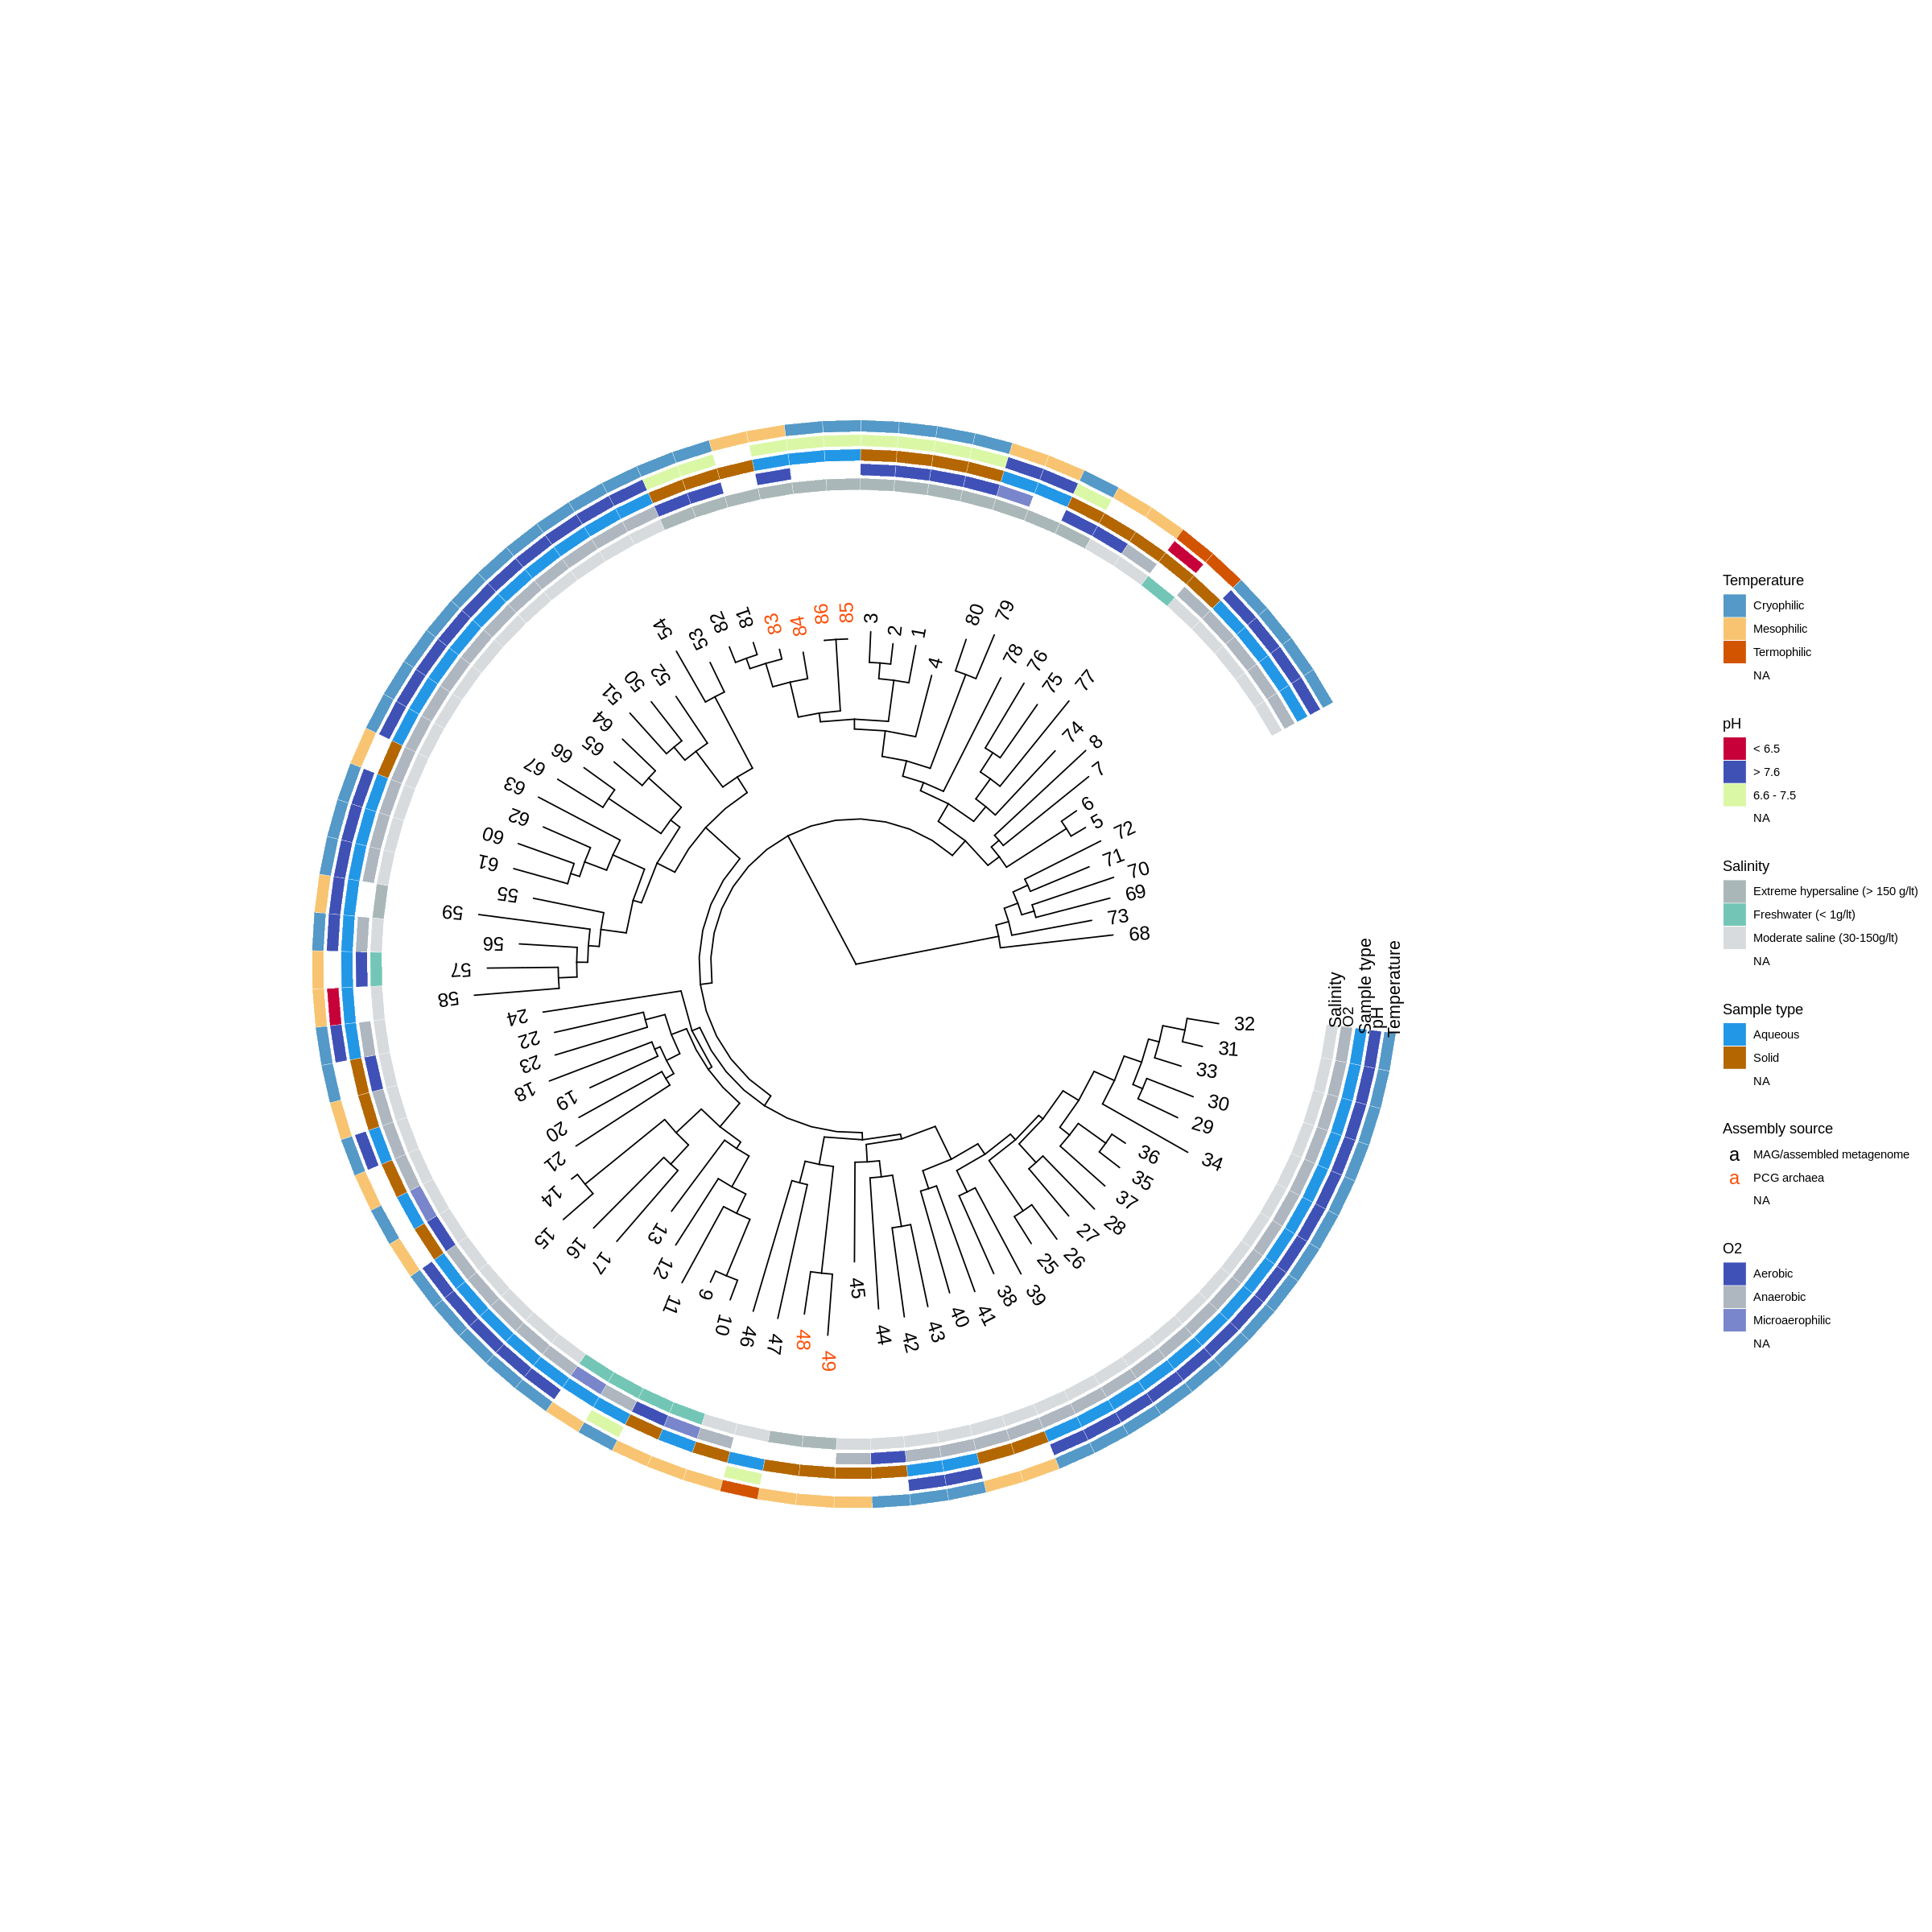

In [1405]:
# first creating a data frame for that purpose
ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `BIOSAMPLE`, `Habitat`) %>%
                                                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                                                    dplyr::rename(`Project` = 'Metagenome Project ID') %>%
                                                    as.data.frame()

ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    
ecodata_geodata_df = ecological_data_to_plot.tibble %>%
                            dplyr::select(new_tip_label, BIOSAMPLE) %>%
                            dplyr::left_join(x = .,
                                             y = geodata.tibble,
                                             by = c('BIOSAMPLE' = 'BioSample ID')) %>%
                            as.data.frame()

# loading library and creating a phylo4d object
#library(phylobase)

#treeplot_linsi = treeplot_linsi %<+% ecodata_metagenomics_projects_and_habitats_df + geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2)
#treeplot_linsi

d2 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label, BIOSAMPLE) %>% dplyr::rename(label = 'new_tip_label', newlab = 'BIOSAMPLE')

d2 %<>% 
    dplyr::mutate(newlab = newlab %>% str_replace_all(., ' y ', '+')) %>%
    dplyr::mutate(newlab = case_when(is.na(newlab) ~ label,
                                     TRUE ~ newlab)) %>%
    as.data.frame()


d3 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label) %>% dplyr::mutate(newlab = 1:nrow(.)) %>% as.data.frame()

# save d3
d3 %>% readr::write_tsv(., '../results/seqid2simple_code_ecotree_subseteado_210709.tsv', col_names = TRUE)


treeplot_linsi = ggtree(FsxA_kosher_linsi.tree, layout = 'circular') + 
                    #geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) + 
                    ggplot2::xlim(0, 6.5) #+ 
                    #geom_strip('HAP2_Chlamy', '001179505.1', barsize=2, color='dodgerblue3', 
                    #         label = "HAP2s", offset.text=.1, offset = .5)#+ 
                    #theme(plot.margin = unit(c(14,8,14,8), "mm")) 



# treeplot_linsi = treeplot_linsi %<+% ecological_data_to_plot.tibble + 
#                                         #geom_tiplab(aes(angle=angle), hjust = 0, size = 3, align = FALSE, linesize = 0) + 
#                                         theme_tree2(legend.position = "none",
#                                                     axis.title.x = element_blank(),
#                                                     axis.text.x = element_blank(),
#                                                     axis.ticks.x = element_blank()) #+
#                                         #scale_y_continuous(expand=c(0, 3)) +
#                                         #geom_treescale(x=50, y=1) +
#                                         #geom_tippoint(aes(size = SOLID), alpha=0.25) 
# 

# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (0.75 + 1.77  + 0.07*2*0 -1.75), width=.030, colnames_position = 'top',
               colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

p2 <- p1 + new_scale_fill()
p2 = gheatmap(p2, df_o2, offset=(0.75 + 1.77  + 0.07*2*1 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 0.25 - 0.45) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#7986CB', 
                                                   'Aerobic' = '#3F51B7')) +  
         theme(legend.position="bottom")


p3 = p2 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(0.75 + 1.77  + 0.07*2*2 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 + 0.45) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(0.75 + 1.77  + 0.07*2*3 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 - 0.4) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5')) +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(0.75 + 1.77  + 0.07*2*4 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 + 0.4) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

#p5 = p5 %<+% ecodata_metagenomics_projects_and_habitats_df + 
#                       geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2) 

# p5 = p5 %<+% ecodata_metagenomics_projects_df + 
#                        geom_text(color = 'gray35', aes(label=`Project`, x = 3.20-0.30 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')
# 
# p5 = p5 %<+% ecodata_habitats_df + 
#                        geom_text(aes(color=`Habitat`, label=`Habitat`, x = 3.44 + 0.075 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')

# modify d3 to annotate PCG archaea with a different colour
d3 %<>%
    dplyr::mutate(`Assembly source` = case_when(newlab %in% c(48, 49, 83, 84, 85, 86) ~ 'PCG archaea',
                                       TRUE ~ 'MAG/assembled metagenome'))

p5 = p5 %<+% d3 + 
                       geom_text2(aes(label=`newlab`, color = `Assembly source`, angle=angle), hjust=-.75, na.rm = T, vjust=0.5, size=5) +
                       theme(legend.position = 'right') +
                       scale_color_manual(values = c(`PCG archaea` = '#FC4E07',
                                                     `MAG/assembled metagenome`= '#000000'))

#p5 = p5 %<+% ecodata_geodata_df + 
#                       geom_text(aes(color=`Geographical location`, label=`Geographical location`, x = 3.20 + 0.01 + 0.115), vjust=-0.7, size=2.7) +
#                       theme(legend.position = 'none')

p5 %>% ggsave(filename = "../results/plots/FsxA_ecological_data_preliminar_210712_labels_con_sample_location_circular.pdf", 
                          plot = .,
                          width = 60, 
                          height = 60, 
                          units = 'cm',
                          limitsize = FALSE)

p5

In [1406]:
# saving label code
d3 %>% as_tibble() %>% readr::write_tsv('../results/plots/FsxA_ecological_data_preliminar_210709_labels_con_sample_location_circular_code.tsv', col_names = T)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



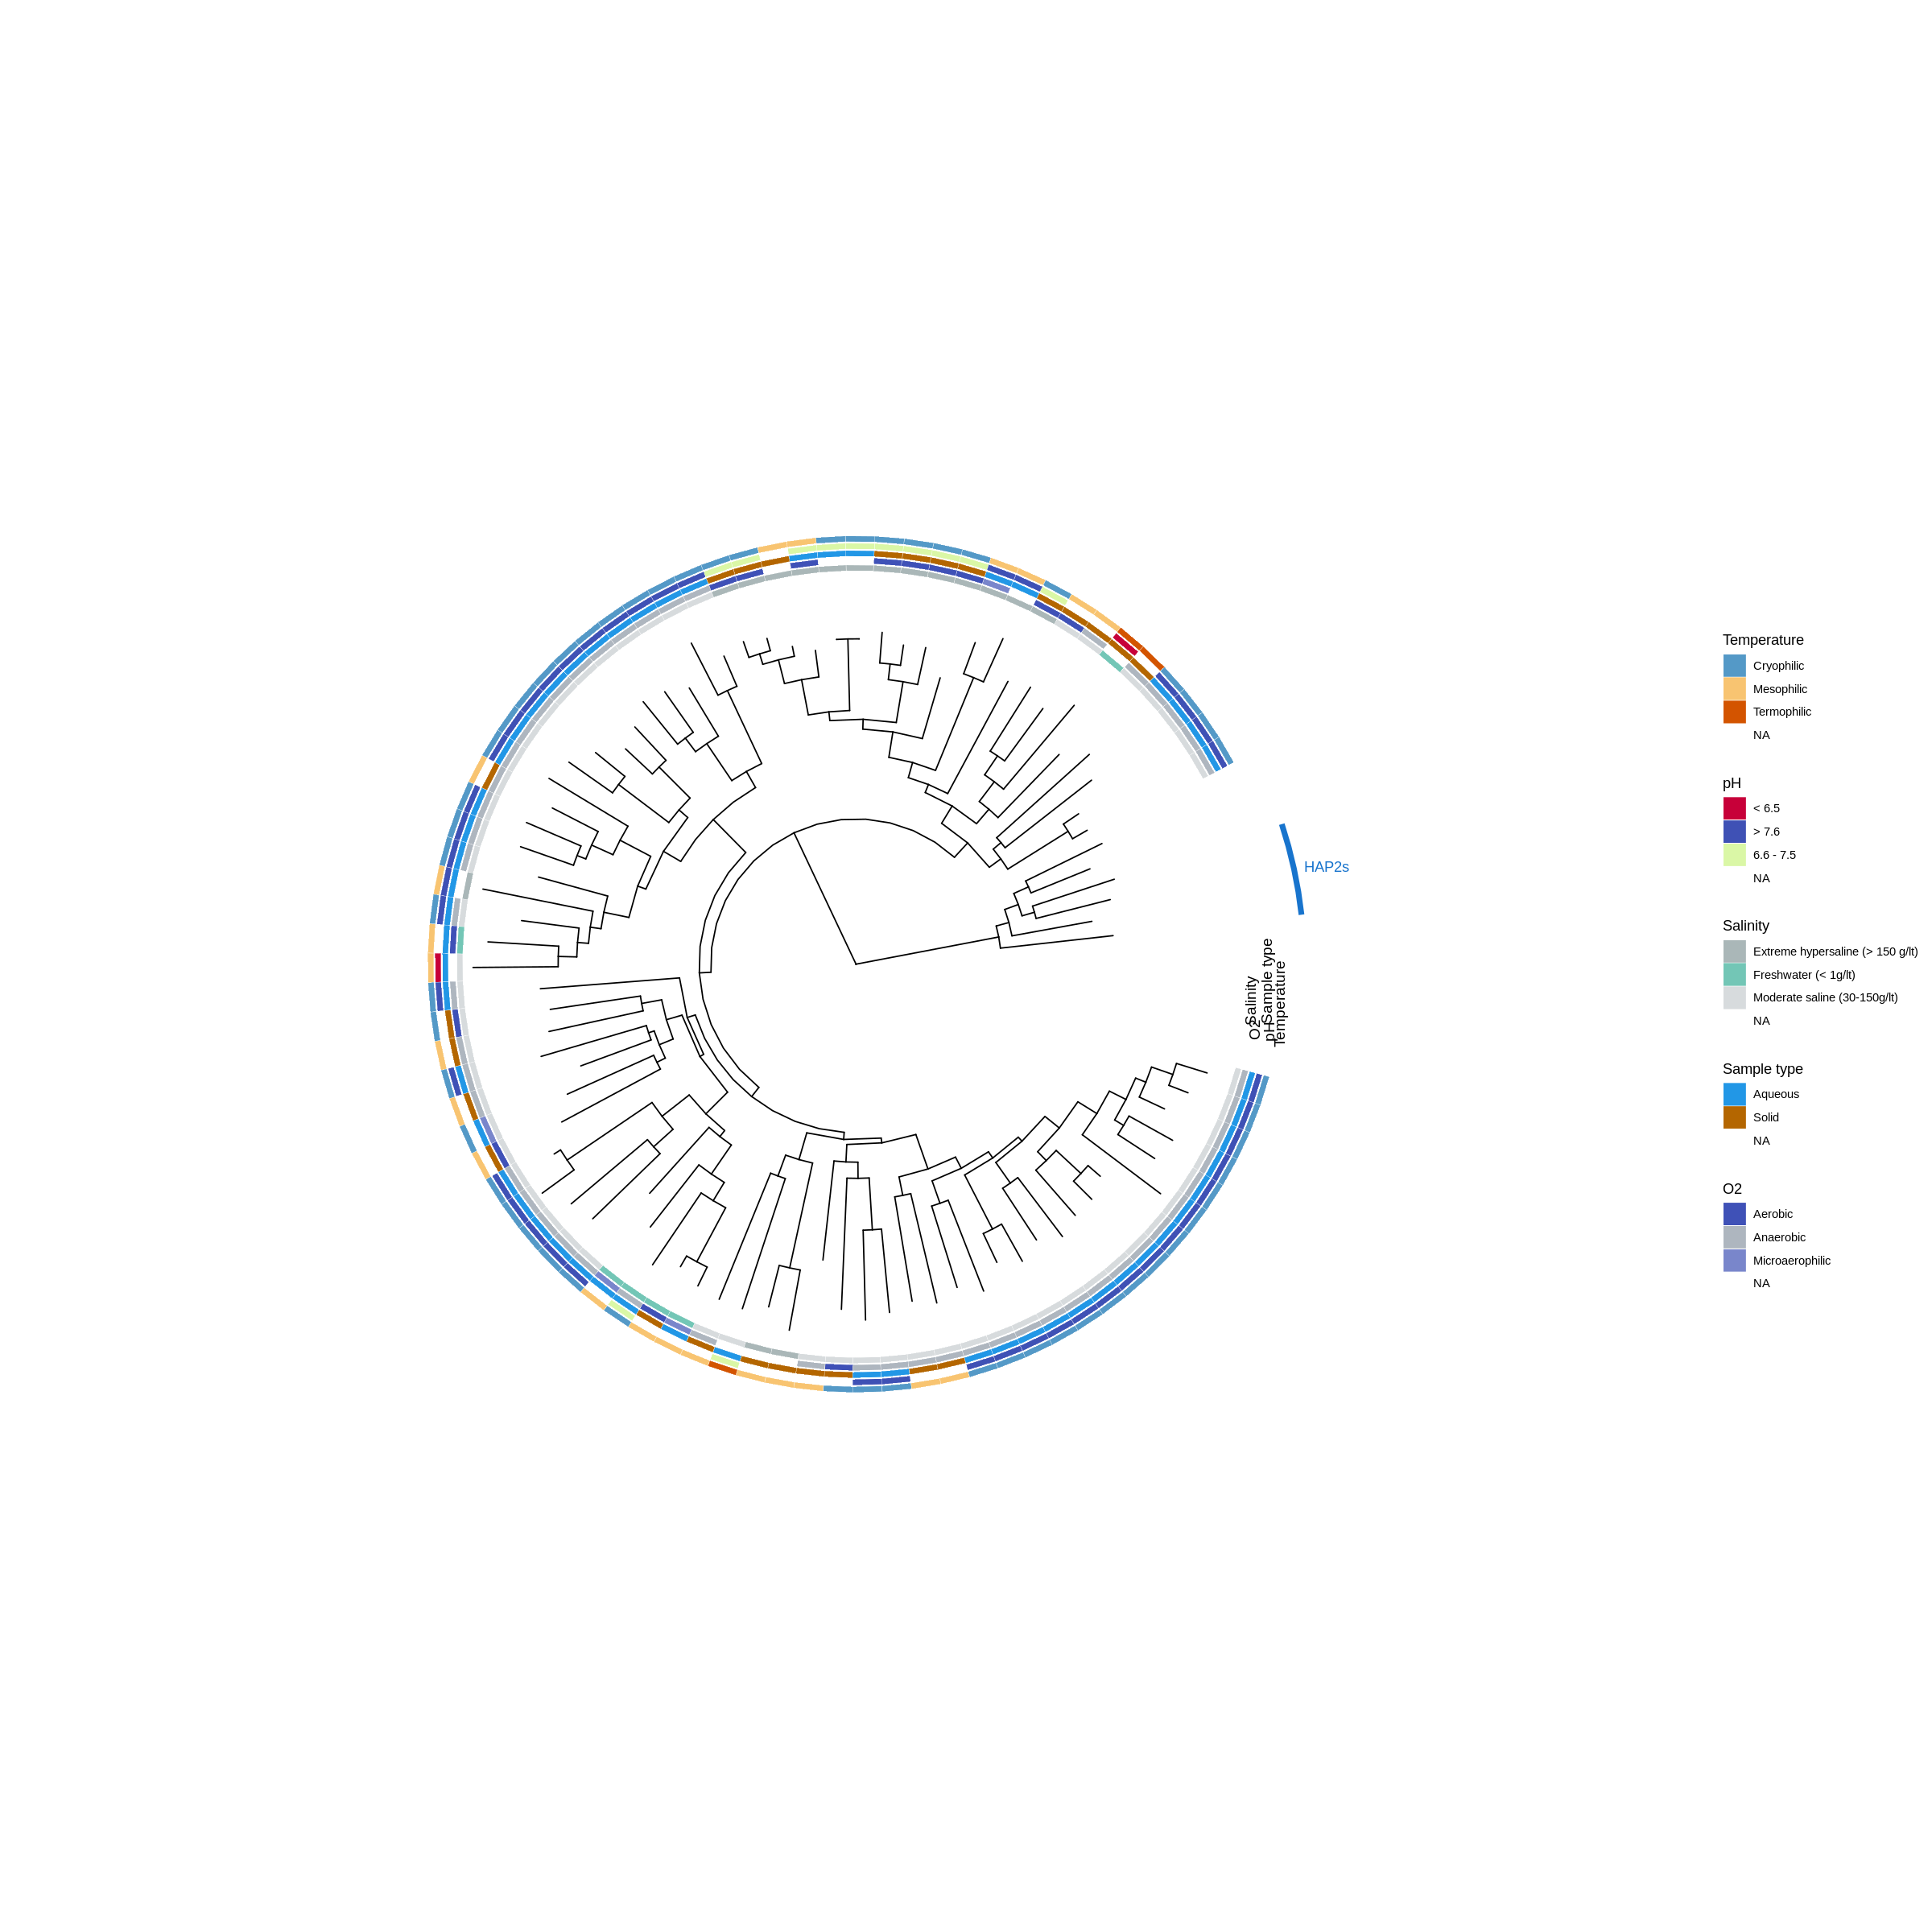

In [1407]:
# first creating a data frame for that purpose
ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `BIOSAMPLE`, `Habitat`) %>%
                                                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                                                    dplyr::rename(`Project` = 'Metagenome Project ID') %>%
                                                    as.data.frame()

ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    
ecodata_geodata_df = ecological_data_to_plot.tibble %>%
                            dplyr::select(new_tip_label, BIOSAMPLE) %>%
                            dplyr::left_join(x = .,
                                             y = geodata.tibble,
                                             by = c('BIOSAMPLE' = 'BioSample ID')) %>%
                            as.data.frame()

# loading library and creating a phylo4d object
#library(phylobase)

#treeplot_linsi = treeplot_linsi %<+% ecodata_metagenomics_projects_and_habitats_df + geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2)
#treeplot_linsi

d2 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label, BIOSAMPLE) %>% dplyr::rename(label = 'new_tip_label', newlab = 'BIOSAMPLE')

d2 %<>% 
    dplyr::mutate(newlab = newlab %>% str_replace_all(., ' y ', '+')) %>%
    dplyr::mutate(newlab = case_when(is.na(newlab) ~ label,
                                     TRUE ~ newlab)) %>%
    as.data.frame()


treeplot_linsi = ggtree(FsxA_kosher_linsi.tree, layout = 'circular') + 
                    #geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) + 
                    ggplot2::xlim(0, 6.5) + 
                    geom_strip('003719155.1', '001179505.1', barsize=2, color='dodgerblue3', 
                             label = "HAP2s", offset.text=.1, offset = .5)#+ 
                    #theme(plot.margin = unit(c(14,8,14,8), "mm")) 



#treeplot_linsi = treeplot_linsi %<+% ecological_data_to_plot.tibble + 
#                                        geom_tiplab(aes(angle=angle), hjust = 0, size = 3, align = FALSE, linesize = 0) + 
#                                        theme_tree2(legend.position = "none",
#                                                    axis.title.x = element_blank(),
#                                                    axis.text.x = element_blank(),
#                                                    axis.ticks.x = element_blank()) #+
#                                        #scale_y_continuous(expand=c(0, 3)) +
#                                        #geom_treescale(x=50, y=1) +
#                                        #geom_tippoint(aes(size = SOLID), alpha=0.25) 
## 

# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (1.77  + 0.07*0 -1.75), width=.015, colnames_position = 'top',
               colnames_angle=90, colnames_offset_y = 2) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

p2 <- p1 + new_scale_fill()
p2 = gheatmap(p2, df_o2, offset=(1.77  + 0.07*1 -1.75), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#7986CB', 
                                                   'Aerobic' = '#3F51B7')) +  
         theme(legend.position="bottom")

p3 = p2 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(1.77  + 0.07*2 -1.75), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2.75) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(1.77  + 0.07*3 -1.75), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 1) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5')) +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(1.77  + 0.07*4 -1.75), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = 2) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

#p5 = p5 %<+% ecodata_metagenomics_projects_and_habitats_df + 
#                       geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2) 

# p5 = p5 %<+% ecodata_metagenomics_projects_df + 
#                        geom_text(color = 'gray35', aes(label=`Project`, x = 3.20-0.30 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')
# 
# p5 = p5 %<+% ecodata_habitats_df + 
#                        geom_text(aes(color=`Habitat`, label=`Habitat`, x = 3.44 + 0.075 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')

#p5 = p5 %<+% d2 + 
#                       geom_text2(aes(label=`label`, angle=angle), hjust=0, na.rm = T, vjust=0, size=2) +
#                       theme(legend.position = 'none')

#p5 = p5 %<+% ecodata_geodata_df + 
#                       geom_text(aes(color=`Geographical location`, label=`Geographical location`, x = 3.20 + 0.01 + 0.115), vjust=-0.7, size=2.7) +
#                       theme(legend.position = 'none')

p5 %>% ggsave(filename = "../results/plots/FsxA_ecological_data_preliminar_210709_circular_sin_labels.pdf", 
                          plot = .,
                          width = 70, 
                          height = 50, 
                          units = "cm", 
                          limitsize = FALSE)

p5

## Circular plot without O2 metadata

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



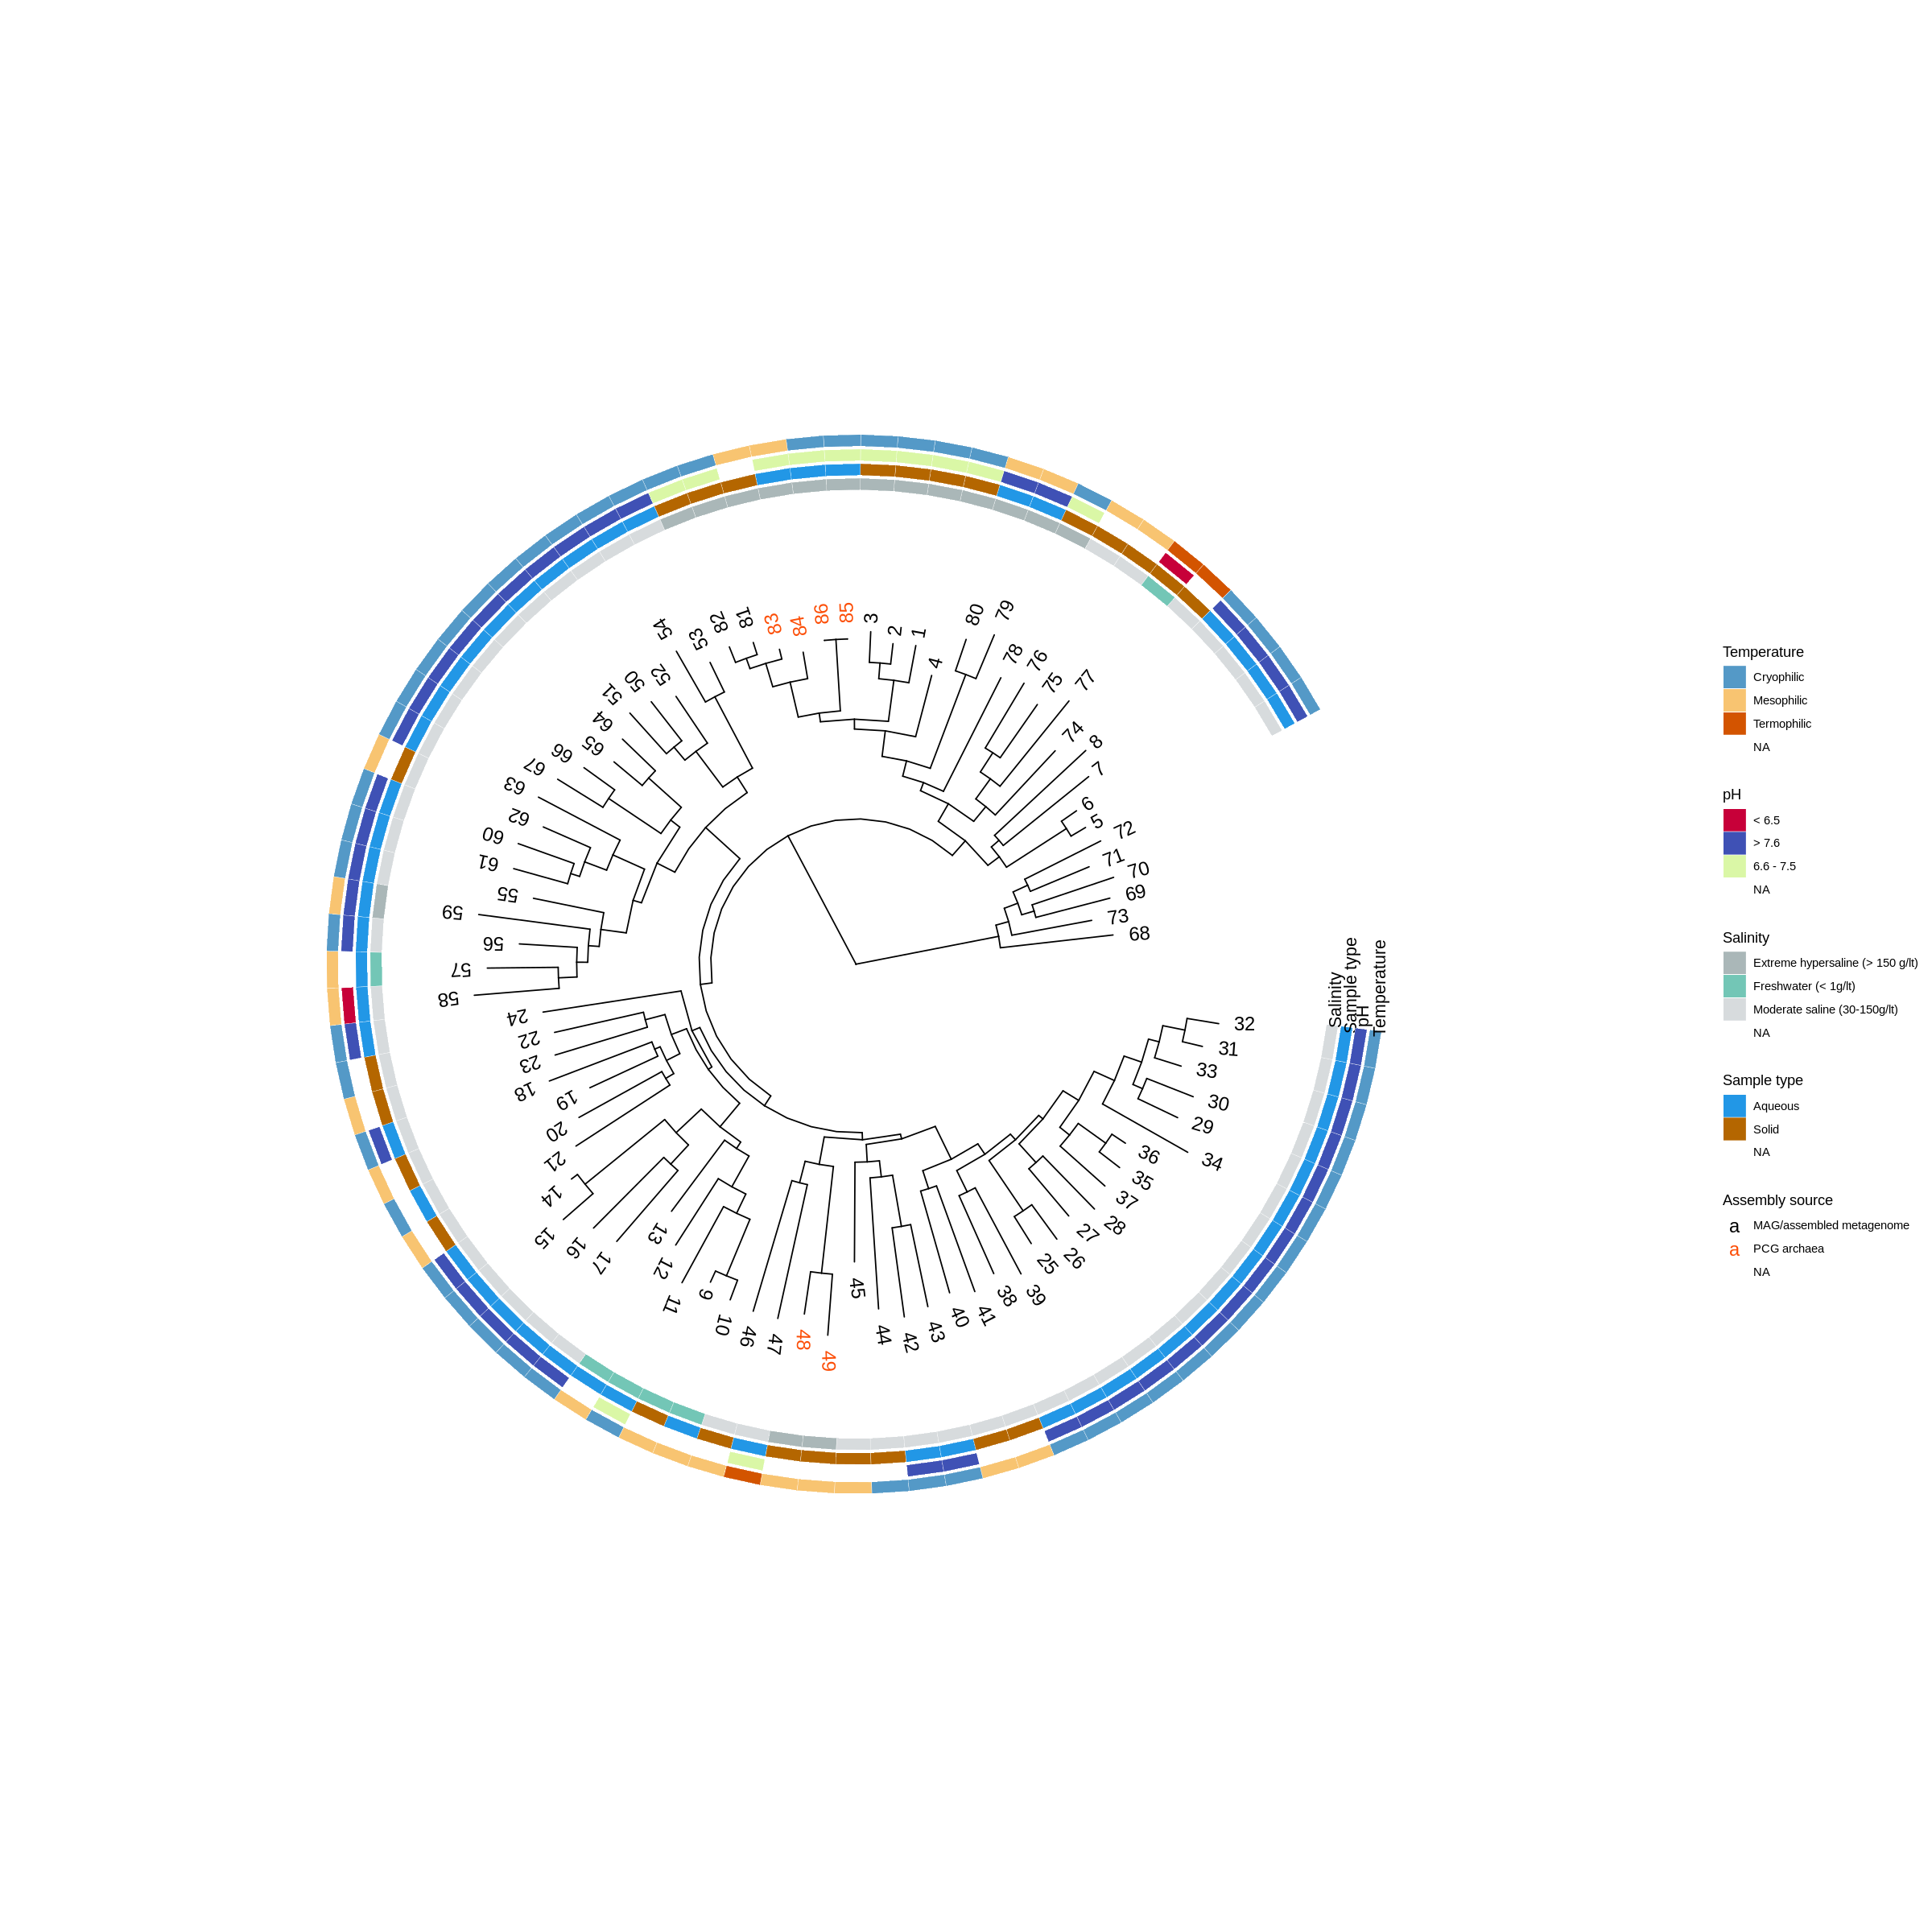

In [1408]:
# first creating a data frame for that purpose
ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `BIOSAMPLE`, `Habitat`) %>%
                                                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                                                    dplyr::rename(`Project` = 'Metagenome Project ID') %>%
                                                    as.data.frame()

ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(new_tip_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    
ecodata_geodata_df = ecological_data_to_plot.tibble %>%
                            dplyr::select(new_tip_label, BIOSAMPLE) %>%
                            dplyr::left_join(x = .,
                                             y = geodata.tibble,
                                             by = c('BIOSAMPLE' = 'BioSample ID')) %>%
                            as.data.frame()

# loading library and creating a phylo4d object
#library(phylobase)

#treeplot_linsi = treeplot_linsi %<+% ecodata_metagenomics_projects_and_habitats_df + geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2)
#treeplot_linsi

d2 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label, BIOSAMPLE) %>% dplyr::rename(label = 'new_tip_label', newlab = 'BIOSAMPLE')

d2 %<>% 
    dplyr::mutate(newlab = newlab %>% str_replace_all(., ' y ', '+')) %>%
    dplyr::mutate(newlab = case_when(is.na(newlab) ~ label,
                                     TRUE ~ newlab)) %>%
    as.data.frame()


d3 = ecological_data_to_plot.tibble %>% as_tibble() %>% dplyr::select(new_tip_label) %>% dplyr::mutate(newlab = 1:nrow(.)) %>% as.data.frame()

# save d3
d3 %>% readr::write_tsv(., '../results/seqid2simple_code_ecotree_subseteado_210709.tsv', col_names = TRUE)


treeplot_linsi = ggtree(FsxA_kosher_linsi.tree, layout = 'circular') + 
                    #geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) + 
                    ggplot2::xlim(0, 6.5) #+ 
                    #geom_strip('HAP2_Chlamy', '001179505.1', barsize=2, color='dodgerblue3', 
                    #         label = "HAP2s", offset.text=.1, offset = .5)#+ 
                    #theme(plot.margin = unit(c(14,8,14,8), "mm")) 



# treeplot_linsi = treeplot_linsi %<+% ecological_data_to_plot.tibble + 
#                                         #geom_tiplab(aes(angle=angle), hjust = 0, size = 3, align = FALSE, linesize = 0) + 
#                                         theme_tree2(legend.position = "none",
#                                                     axis.title.x = element_blank(),
#                                                     axis.text.x = element_blank(),
#                                                     axis.ticks.x = element_blank()) #+
#                                         #scale_y_continuous(expand=c(0, 3)) +
#                                         #geom_treescale(x=50, y=1) +
#                                         #geom_tippoint(aes(size = SOLID), alpha=0.25) 
# 

# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (0.75 + 1.77  + 0.07*2*0 -1.75), width=.030, colnames_position = 'top',
               colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

# getting rid of this # p2 <- p1 + new_scale_fill()
# getting rid of this # p2 = gheatmap(p2, df_o2, offset=(1.77  + 0.07*1 -1.75), width=.015, colnames_position = 'top',
# getting rid of this #          colnames_angle=90, colnames_offset_y = 1) +
# getting rid of this #          #colnames_angle=45, colnames_offset_y = 0) +
# getting rid of this #          scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
# getting rid of this #                                                    'Microaerophilic' = '#7986CB', 
# getting rid of this #                                                    'Aerobic' = '#3F51B7')) +  
# getting rid of this #          theme(legend.position="bottom")


p3 = p1 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(0.75 + 1.77  + 0.07*2*1 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 + 0.45) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(0.75 + 1.77  + 0.07*2*2 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 - 0.4) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5')) +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(0.75 + 1.77  + 0.07*2*3 -1.75), width=.030, colnames_position = 'top',
         colnames_angle=90, font.size = 4.5, colnames_offset_y = 0.25 + 0.4) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

#p5 = p5 %<+% ecodata_metagenomics_projects_and_habitats_df + 
#                       geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2) 

# p5 = p5 %<+% ecodata_metagenomics_projects_df + 
#                        geom_text(color = 'gray35', aes(label=`Project`, x = 3.20-0.30 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')
# 
# p5 = p5 %<+% ecodata_habitats_df + 
#                        geom_text(aes(color=`Habitat`, label=`Habitat`, x = 3.44 + 0.075 + 0.115), vjust=-0.7, size=2.7) +
#                        theme(legend.position = 'none')

# modify d3 to annotate PCG archaea with a different colour
d3 %<>%
    dplyr::mutate(`Assembly source` = case_when(newlab %in% c(48, 49, 83, 84, 85, 86) ~ 'PCG archaea',
                                       TRUE ~ 'MAG/assembled metagenome'))

p5 = p5 %<+% d3 + 
                       geom_text2(aes(label=`newlab`, color = `Assembly source`, angle=angle), hjust=-.75, na.rm = T, vjust=0.5, size=5) +
                       theme(legend.position = 'right') +
                       scale_color_manual(values = c(`PCG archaea` = '#FC4E07',
                                                     `MAG/assembled metagenome`= '#000000'))

#p5 = p5 %<+% ecodata_geodata_df + 
#                       geom_text(aes(color=`Geographical location`, label=`Geographical location`, x = 3.20 + 0.01 + 0.115), vjust=-0.7, size=2.7) +
#                       theme(legend.position = 'none')

p5 %>% ggsave(filename = "../results/plots/FsxA_ecological_data_preliminar_210712_labels_con_sample_location_circular_no_02.pdf", 
                          plot = .,
                          width = 60, 
                          height = 60, 
                          units = 'cm',
                          limitsize = FALSE)

p5

## Rectangular plot with simplified labels and plotting locations

In [1409]:
# create unique label ID composed of BioSample and metagenomic project
metagenome_project_ID_tips_and_biosample_corr_table = readr::read_tsv('../results/metagenome_project_ID_tips_and_biosample_corr_table.tsv')


── Column specification ────────────────────────────────────────────────────────
cols(
  new_tip_label = col_character(),
  BIOSAMPLE = col_character(),
  `Metagenome Project ID` = col_character()
)




In [1410]:
# create unique label name
metagenome_project_ID_tips_and_biosample_corr_table %<>%
    dplyr::group_split(BIOSAMPLE) %>%
    purrr::map_dfr(., ~{
        # allocate table in a variable
        table = .x
        
        # if there is more than one row, label them
        nrows_table = nrow(table)
        nrow_vec = 1:nrows_table
        
        table %>%
            dplyr::mutate(nrows_table = nrows_table) %>%
            dplyr::mutate(biosample_uid = case_when(nrows_table == 1 ~ BIOSAMPLE,
                                                   nrows_table > 1 ~ glue('{BIOSAMPLE}-{nrow_vec}') %>% as.character())) %>%
            dplyr::mutate(simplified_label = glue('{biosample_uid} ({`Metagenome Project ID`})') %>% as.character())
        
    }) %>%
    dplyr::select(-c(`nrows_table`, `biosample_uid`)) %>%
    dplyr::mutate(simplified_label = case_when(is.na(BIOSAMPLE) ~ new_tip_label, TRUE ~ simplified_label)) %>%
    dplyr::mutate(simplified_label = simplified_label %>% str_replace_all(., ' y ', '+'))

metagenome_project_ID_tips_and_biosample_corr_table %>% readr::write_tsv(., '../results/sequences_biosample-uids_and_simplified_lables_annotation_210709.tsv')

In [1411]:
metagenome_project_ID_tips_and_biosample_corr_table %>%
    dplyr::filter(is.na(`BIOSAMPLE`))

new_tip_label BIOSAMPLE Metagenome Project ID simplified_label
1 001179505.1   NA        NA                    001179505.1     
2 000189635.1   NA        NA                    000189635.1     
3 003719155.1   NA        NA                    003719155.1     
4 000313135.1   NA        NA                    000313135.1     
5 HAP2_Chlamy   NA        NA                    HAP2_Chlamy     
6 000190715.1   NA        NA                    000190715.1

Warning message:
“Unknown levels in `f`: 1, 2, 3”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Removed 91 rows containing missing values (geom_text).”
Warning message:
“Removed 92 rows containing missing values (geom_text).”
Warning message:
“Removed 98 rows containing missing values (geom_text).”
Warning message:
“Removed 85 rows containing missing values (geom_text).”
Warning message:
“Removed 91 rows containing missing values (geom_text).”
Warning message:
“Removed 92 r

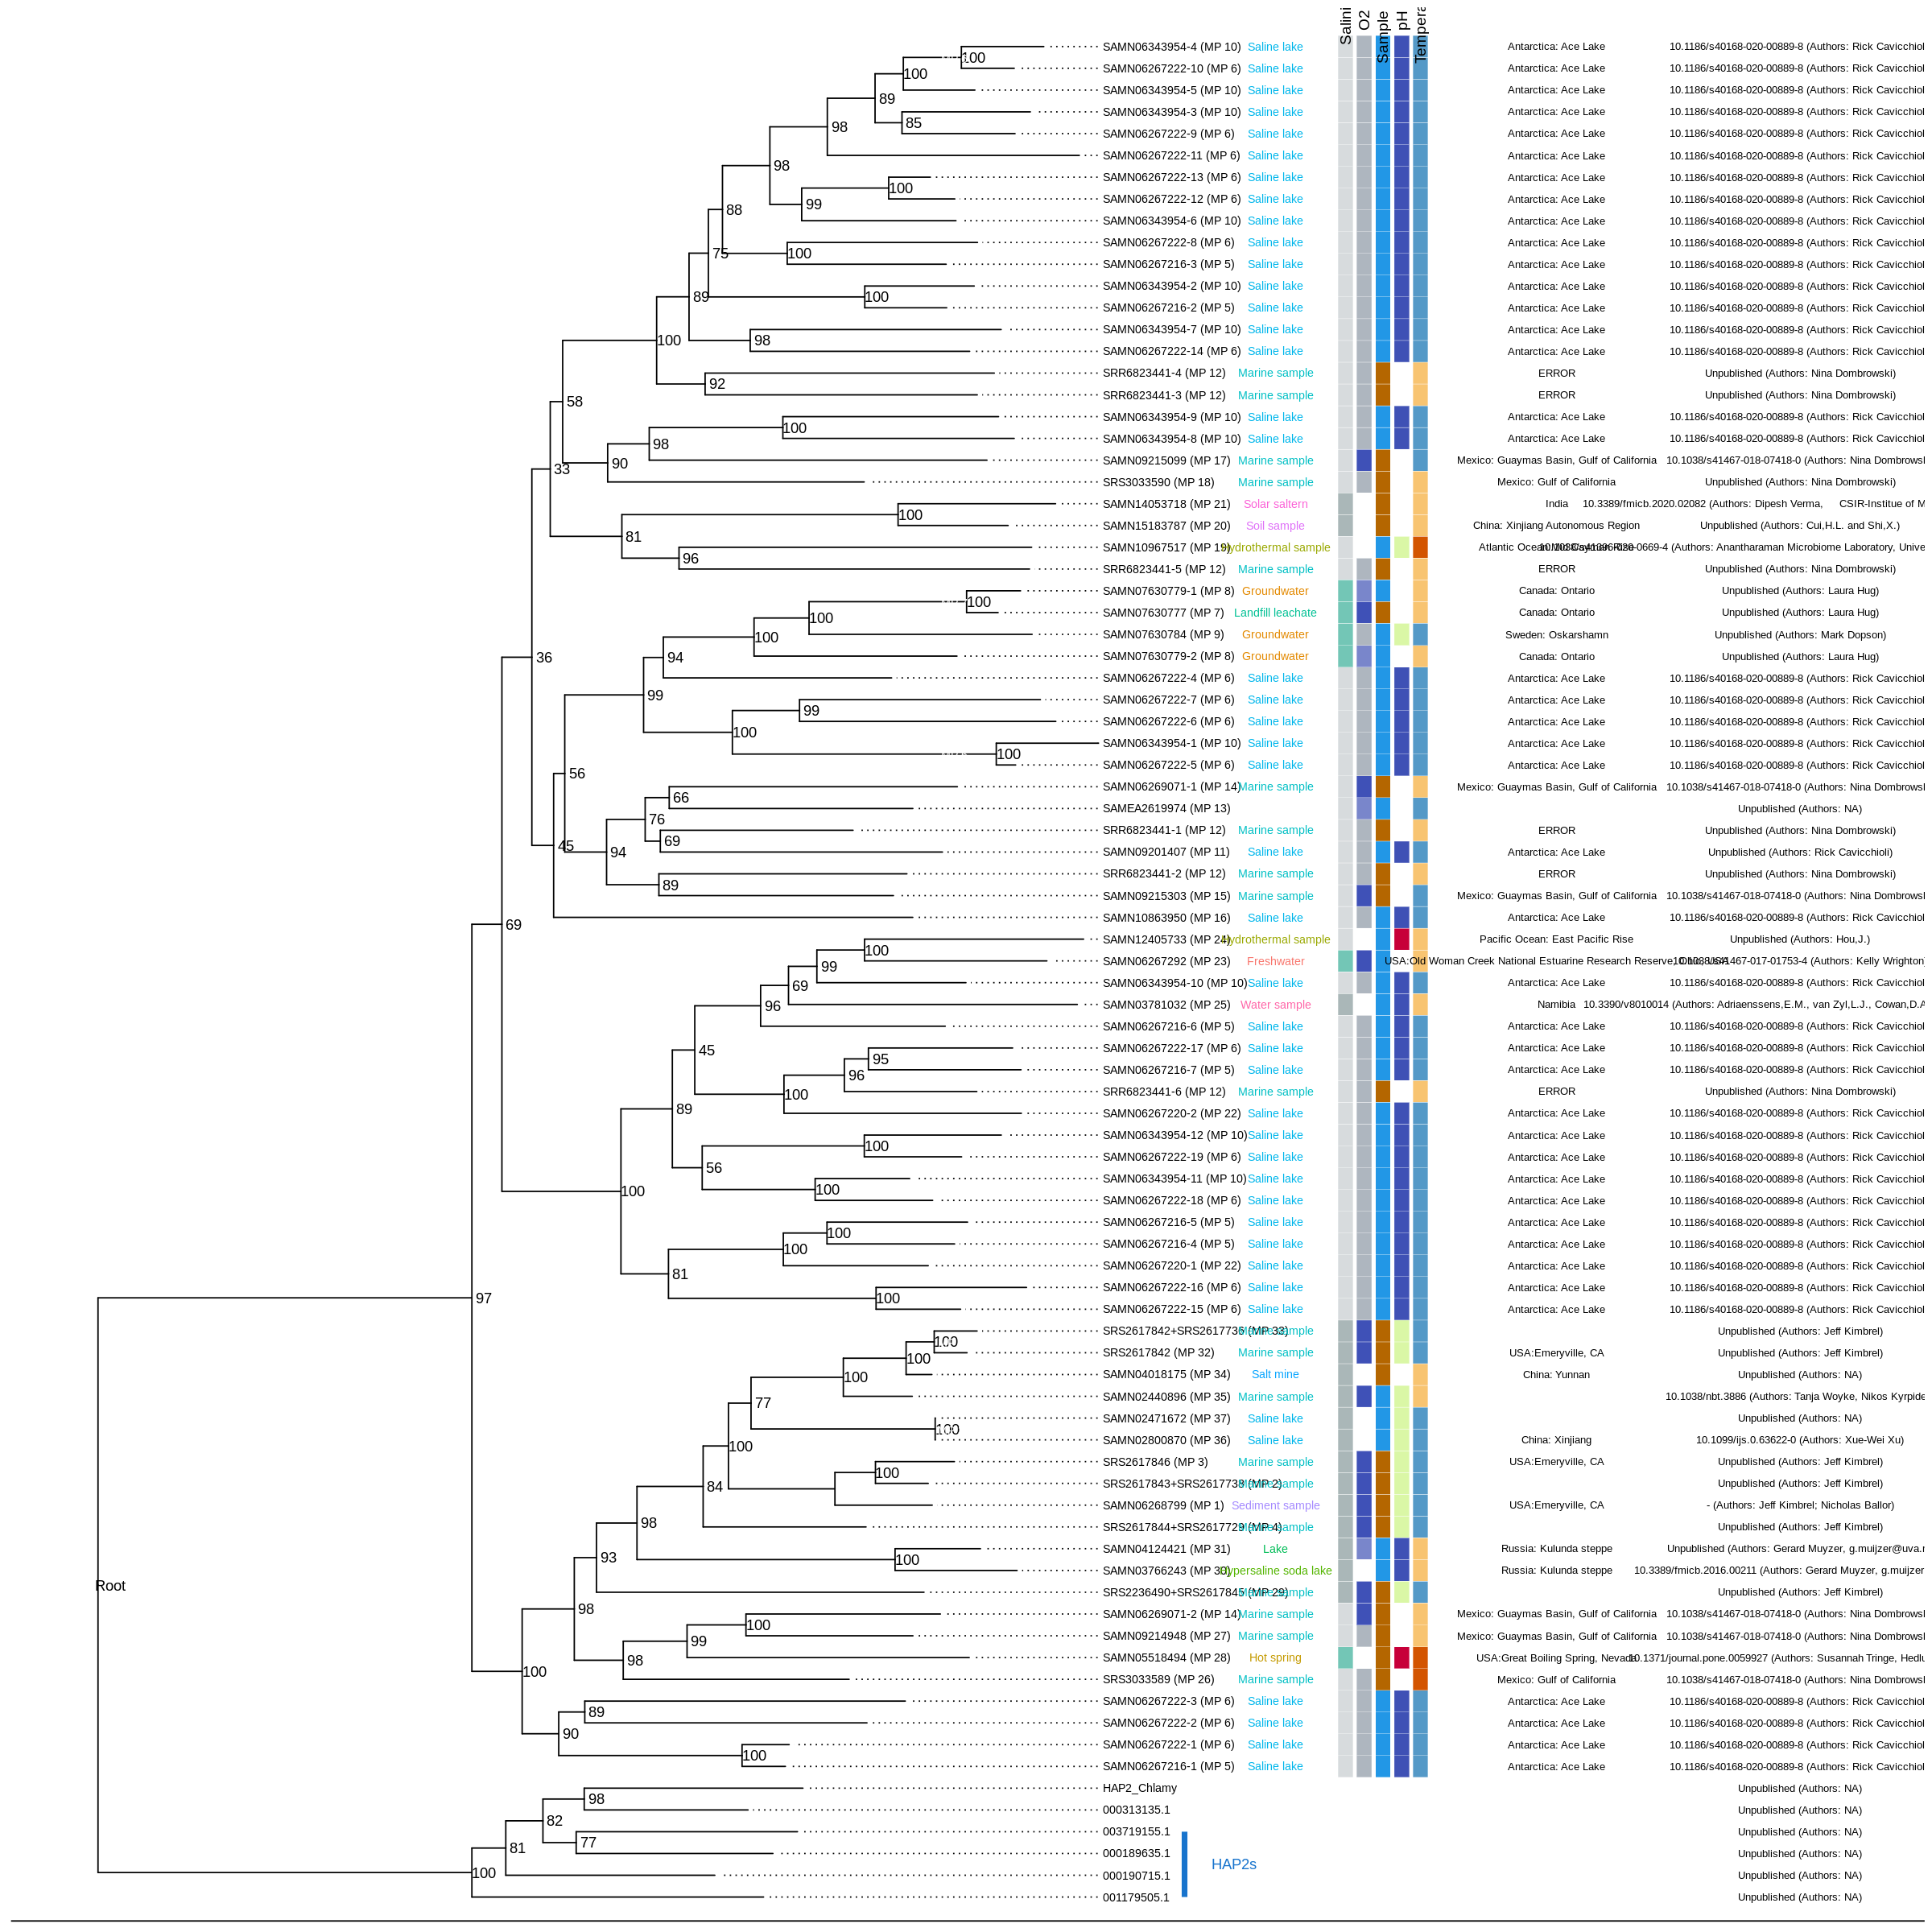

In [1412]:
# rename labels based on new simplified IDs
d2 = metagenome_project_ID_tips_and_biosample_corr_table %>% as.data.frame()

library(treeio)
tr3 = treeio::rename_taxa(FsxA_kosher_linsi.tree, d2, new_tip_label, simplified_label)
FsxA_kosher_linsi.tree = tr3

# merge <ecological_data_to_plot.tibble> with this data
ecological_data_to_plot.tibble %<>%
    dplyr::left_join(x = .,
                     y = (metagenome_project_ID_tips_and_biosample_corr_table %>% dplyr::select(new_tip_label, simplified_label)),
                     by = 'new_tip_label')  

ecodata_geodata_df = ecological_data_to_plot.tibble %>%
                            dplyr::select(simplified_label, BIOSAMPLE) %>%
                            dplyr::left_join(x = .,
                                             y = geodata.tibble,
                                             by = c('BIOSAMPLE' = 'BioSample ID')) %>%
                            as.data.frame()

cites_df = ecological_data_to_plot.tibble %>%
    dplyr::select(simplified_label, AUTHORS, `PAPER DOI`) %>%
    dplyr::mutate(cite = glue('{`PAPER DOI`} (Authors: {`AUTHORS`})') %>% as.character()) %>%
    dplyr::mutate(cite = case_when(is.na(`PAPER DOI`) ~ glue('Unpublished (Authors: {AUTHORS})') %>% as.character(),
                                   TRUE ~ cite)) %>%
    as.data.frame()

# create treeplot
treeplot_linsi = ggtree(FsxA_kosher_linsi.tree) + 
                    geom_text2(aes(subset = !isTip, label=label), nudge_x = 0.045) + 
                    ggplot2::xlim(0, 6.5) + 
                    geom_strip('003719155.1', '001179505.1', barsize=2, color='dodgerblue3', 
                             label = "HAP2s", offset.text=.1, offset = .25)#+ 
                    #theme(plot.margin = unit(c(14,8,14,8), "mm")) 

treeplot_linsi = treeplot_linsi %<+% ecological_data_to_plot.tibble + 
                                        geom_tiplab(size = 3, align = TRUE) + 
                                        theme_tree2(legend.position = "none",
                                                    axis.title.x = element_blank(),
                                                    axis.text.x = element_blank(),
                                                    axis.ticks.x = element_blank()) #+
                                        #scale_y_continuous(expand=c(0, 3)) +
                                        #geom_treescale(x=50, y=1) +
                                        #geom_tippoint(aes(size = SOLID), alpha=0.25) 

# first creating a data frame for that purpose
ecodata_metagenomics_projects_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(simplified_label, `BIOSAMPLE`, `Habitat`) %>%
                                                    dplyr::mutate(`Metagenome Project ID` = `BIOSAMPLE` %>% tidytidbits::lookup_chr(., dict = metagenome_projects.dict, default = identity)) %>%
                                                    dplyr::rename(`Project` = 'Metagenome Project ID') %>%
                                                    as.data.frame()

ecodata_habitats_df = ecological_data_to_plot.tibble %>% 
                                                    dplyr::select(simplified_label, `Habitat`) %>%
                                                    dplyr::rename(`Habitat` = 'Habitat') %>%
                                                    as.data.frame()
                                                    

# loading library and creating a phylo4d object
#library(phylobase)

#treeplot_linsi = treeplot_linsi %<+% ecodata_metagenomics_projects_and_habitats_df + geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2)
#treeplot_linsi

# creating specific datafrmes for each ecological variable to plot
df_habitat = ecological_data_to_plot.tibble %>% 
            dplyr::select(simplified_label, `Habitat`) %>% 
            dplyr::mutate(`Habitat` = `Habitat` %>% as.factor()) %>%
            column_to_rownames('simplified_label')

df_metagenomics_project = ecological_data_to_plot.tibble %>% 
            dplyr::select(simplified_label, `METAGENOMICS PROJECT`) %>% 
            dplyr::mutate(`METAGENOMICS PROJECT` = `METAGENOMICS PROJECT` %>% as.factor()) %>%
            dplyr::rename(`Project` = 'METAGENOMICS PROJECT') %>%
            column_to_rownames('simplified_label')

df_salt = ecological_data_to_plot.tibble %>% 
            dplyr::select(simplified_label, `SALT?`) %>% 
            dplyr::mutate(`SALT?` = `SALT?` %>% as.factor() %>% forcats::fct_relevel(., c('Freshwater (< 1g/lt)', 'Moderate saline (30-150g/lt)', 'Extreme hypersaline (> 150 g/lt)'))) %>%
            dplyr::rename(Salinity = 'SALT?') %>% column_to_rownames('simplified_label')

df_o2 = ecological_data_to_plot.tibble %>% 
            dplyr::select(simplified_label, `O2`) %>% 
            dplyr::mutate(O2 = O2 %>% as.factor() %>% forcats::fct_relevel(., c('Anaerobic', 'Microaerophilic', 'Aerobic'))) %>%
            column_to_rownames('simplified_label')


df_sampletype = ecological_data_to_plot.tibble %>% 
                    dplyr::select(simplified_label, `Sample type`) %>% 
                    dplyr::mutate(`Sample type` = `Sample type` %>% as.factor() %>% forcats::fct_relevel(., c('Solid', 'Aqueous'))) %>%
                    column_to_rownames('simplified_label') 

df_pH = ecological_data_to_plot.tibble %>% 
            dplyr::select(simplified_label, `pH`) %>% 
            dplyr::mutate(pH = pH %>% as.factor() %>% forcats::fct_recode(., `< 6.5` = '1', `6.6 - 7.5` = '2', `> 7.6` = '3')) %>%
            column_to_rownames('simplified_label') 

df_temperature = ecological_data_to_plot.tibble %>% 
                    dplyr::select(simplified_label, `T_Classified`) %>% 
                    dplyr::mutate(`T_Classified` = `T_Classified` %>% as.factor() %>% forcats::fct_relevel(., c('Cryophilic', 'Mesophilic', 'Termophilic'))) %>%
                    dplyr::rename(Temperature = 'T_Classified') %>% 
                    column_to_rownames('simplified_label') 

# plotting tree with heatmap data (using gheatmap)
p1 <- gheatmap(treeplot_linsi, df_salt, offset= (1.77  + 0.07*0 -0.9 + 0.0), width=.015, colnames_position = 'top',
               colnames_angle=90, colnames_offset_y = .2) +
               #colnames_angle=45, colnames_offset_y = 0) +
    scale_fill_manual(name = 'Salinity', values = c('Freshwater (< 1g/lt)' = '#73C6B6', 
                                                    'Moderate saline (30-150g/lt)' = '#D7DBDD', 
                                                    'Extreme hypersaline (> 150 g/lt)' = '#AAB7B8'))

p2 <- p1 + new_scale_fill()
p2 = gheatmap(p2, df_o2, offset=(1.77  + 0.07*1 -0.9 + 0.0), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = .2) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'O2', values = c('Anaerobic' = '#AEB6BF', 
                                                   'Microaerophilic' = '#7986CB', 
                                                   'Aerobic' = '#3F51B7')) +  
         theme(legend.position="bottom")

p3 = p2 + new_scale_fill()
p3 = gheatmap(p3, df_sampletype, offset=(1.77  + 0.07*2 -0.9 + 0.0), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = .2) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Sample type', values = c('Solid' = "#B46600", 
                                                            'Aqueous' = "708D81")) +  
         theme(legend.position="bottom")


p4 = p3 + new_scale_fill()
p4 = gheatmap(p4, df_pH, offset=(1.77  + 0.07*3 -0.9 + 0.0), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = .2) +
         #colnames_angle=45, colnames_offset_y = 1) +
         scale_fill_manual(name = 'pH', values = c('< 6.5' = '#C70039', 
                                                   '6.6 - 7.5' = '#DAF7A6', 
                                                   '> 7.6' = '#3F51B5')) +  
         theme(legend.position="bottom")

p5 = p4 + new_scale_fill()

p5 = gheatmap(p5, df_temperature, offset=(1.77  + 0.07*4 -0.9 + 0.0), width=.015, colnames_position = 'top',
         colnames_angle=90, colnames_offset_y = .2) +
         #colnames_angle=45, colnames_offset_y = 0) +
         scale_fill_manual(name = 'Temperature', values = c('Cryophilic' = '#5499C7', 
                                                            'Mesophilic' = '#F8C471', 
                                                            'Termophilic' = '#D35400')) +  
         theme(legend.position="right")

#p5 = p5 %<+% ecodata_metagenomics_projects_and_habitats_df + 
#                       geom_text(aes(color=`Project`, label=`Project`), hjust=.6, vjust=-0.6, size=2) 

p5 = p5 %<+% ecodata_metagenomics_projects_df + 
                       geom_text(color = 'white', aes(label=`Project`, x = 3.20 ), vjust=-0.7, size=3) +
                       theme(legend.position = 'none')

p5 = p5 %<+% ecodata_habitats_df + 
                       geom_text(aes(color=`Habitat`, label=`Habitat`, x = 4.4 ), vjust=0.5, size=3) +
                       theme(legend.position = 'none')

p5 = p5 %<+% ecodata_geodata_df +
                      geom_text(aes(label=`Geographical location`, x = 5.45 ), vjust=0.5, size=2.75) +
                       theme(legend.position = 'none')

p5 = p5 %<+% cites_df +
                geom_text(aes(label=`cite`, x = 6.36 ), vjust=0.5, size=2.75) +
                       theme(legend.position = 'none')

p5 %>% ggsave(filename = "../results/plots/FsxA_ecological_data_preliminar_210709_simplified_labels_and_geolocation.pdf", 
                          plot = .,
                          width = 85, 
                          height = 50, 
                          units = "cm", 
                          limitsize = FALSE)

p5

In [1413]:
#FsxA_kosher_linsi.tree$edge.length[FsxA_kosher_linsi.tree$edge.length == 0] = 20

In [1414]:
FsxA_kosher_linsi.tree$edge.length[FsxA_kosher_linsi.tree$edge.length == 0] 

numeric(0)

In [1415]:
# get edge connecting study group
group_of_study = FsxA_kosher_linsi.tree$tip.label[!FsxA_kosher_linsi.tree$tip.label %in% c('HAP2_Chlamy', '001179505.1', '000189635.1', '003719155.1', '000190715.1', '000313135.1')] 

# get edge
ape::which.edge(phy = FsxA_kosher_linsi.tree, group = group_of_study)

[1]   2   3   4   5   6   7   8   9  10  11  12  24  36  37  38  39  40  41
 [19]  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
 [37]  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
 [55]  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
 [73]  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 [91] 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
[109] 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
[127] 150 151 152 153 154 155 156 157 158 159  29  30  31  32  33  34  35  28
[145]  25  26  27  13  14  15  16  17  18  19  20  21  22  23

In [1416]:
group_of_study

[1] "SAMN06268799 (MP 1)"           "SRS2617843+SRS2617738 (MP 2)" 
 [3] "SRS2617846 (MP 3)"             "SRS2617844+SRS2617729 (MP 4)" 
 [5] "SAMN06267216-1 (MP 5)"         "SAMN06267222-1 (MP 6)"        
 [7] "SAMN06267222-2 (MP 6)"         "SAMN06267222-3 (MP 6)"        
 [9] "SAMN07630777 (MP 7)"           "SAMN07630779-1 (MP 8)"        
[11] "SAMN07630784 (MP 9)"           "SAMN07630779-2 (MP 8)"        
[13] "SAMN06267222-4 (MP 6)"         "SAMN06267222-5 (MP 6)"        
[15] "SAMN06343954-1 (MP 10)"        "SAMN06267222-6 (MP 6)"        
[17] "SAMN06267222-7 (MP 6)"         "SAMN09201407 (MP 11)"         
[19] "SRR6823441-1 (MP 12)"          "SAMEA2619974 (MP 13)"         
[21] "SAMN06269071-1 (MP 14)"        "SAMN09215303 (MP 15)"         
[23] "SRR6823441-2 (MP 12)"          "SAMN10863950 (MP 16)"         
[25] "SAMN06267216-2 (MP 5)"         "SAMN06343954-2 (MP 10)"       
[27] "SAMN06267216-3 (MP 5)"         "SAMN06267222-8 (MP 6)"        
[29] "SAMN06267222-9 (MP 6)"         "SAMN06343954-3 (MP 10)"       
[31] "SAMN06267222-10 (MP 6)"        "SAMN06343954-4 (MP 10)"       
[33] "SAMN06343954-5 (MP 10)"        "SAMN06267222-11 (MP 6)"       
[35] "SAMN06267222-12 (MP 6)"        "SAMN06267222-13 (MP 6)"       
[37] "SAMN06343954-6 (MP 10)"        "SAMN06267222-14 (MP 6)"       
[39] "SAMN06343954-7 (MP 10)"        "SRR6823441-3 (MP 12)"         
[41] "SRR6823441-4 (MP 12)"          "SAMN06343954-8 (MP 10)"       
[43] "SAMN06343954-9 (MP 10)"        "SAMN09215099 (MP 17)"         
[45] "SRS3033590 (MP 18)"            "SRR6823441-5 (MP 12)"         
[47] "SAMN10967517 (MP 19)"          "SAMN15183787 (MP 20)"         
[49] "SAMN14053718 (MP 21)"          "SAMN06267216-4 (MP 5)"        
[51] "SAMN06267216-5 (MP 5)"         "SAMN06267220-1 (MP 22)"       
[53] "SAMN06267222-15 (MP 6)"        "SAMN06267222-16 (MP 6)"       
[55] "SAMN06267216-6 (MP 5)"         "SAMN06343954-10 (MP 10)"      
[57] "SAMN06267292 (MP 23)"          "SAMN12405733 (MP 24)"         
[59] "SAMN03781032 (MP 25)"          "SAMN06267216-7 (MP 5)"        
[61] "SAMN06267222-17 (MP 6)"        "SRR6823441-6 (MP 12)"         
[63] "SAMN06267220-2 (MP 22)"        "SAMN06267222-18 (MP 6)"       
[65] "SAMN06343954-11 (MP 10)"       "SAMN06267222-19 (MP 6)"       
[67] "SAMN06343954-12 (MP 10)"       "SRS3033589 (MP 26)"           
[69] "SAMN09214948 (MP 27)"          "SAMN06269071-2 (MP 14)"       
[71] "SAMN05518494 (MP 28)"          "SRS2236490+SRS2617845 (MP 29)"
[73] "SAMN03766243 (MP 30)"          "SAMN04124421 (MP 31)"         
[75] "SRS2617842 (MP 32)"            "SRS2617842+SRS2617736 (MP 33)"
[77] "SAMN04018175 (MP 34)"          "SAMN02440896 (MP 35)"         
[79] "SAMN02800870 (MP 36)"          "SAMN02471672 (MP 37)"

In [1417]:
help(gheatmap)

gheatmap                package:ggtree                 R Documentation

_g_h_e_a_t_m_a_p

_D_e_s_c_r_i_p_t_i_o_n:

     append a heatmap of a matrix to right side of phylogenetic tree

_U_s_a_g_e:

     gheatmap(
       p,
       data,
       offset = 0,
       width = 1,
       low = "green",
       high = "red",
       color = "white",
       colnames = TRUE,
       colnames_position = "bottom",
       colnames_angle = 0,
       colnames_level = NULL,
       colnames_offset_x = 0,
       colnames_offset_y = 0,
       font.size = 4,
       family = "",
       hjust = 0.5,
       legend_title = "value"
     )
     
_A_r_g_u_m_e_n_t_s:

       p: tree view

    data: matrix or data.frame

  offset: offset of heatmap to tree

   width: total width of heatmap, compare to width of tree

     low: color of lowest value

    high: color of highest value

   color: color of heatmap cell border

colnames: logical, add matrix colnames or not

colnames_position: one of 'bottom' or 'top'

colnames_angle: angle of column names

colnames_level: levels of colnames

colnames_offset_x: x offset for column names

colnames_offset_y: y offset for column names

font.size: font size of matrix colnames

  family: font of matrix colnames

   hjust: hjust for column names (0: align left, 0.5: align center, 1:
          align righ)

legend_title: title of fill legend

_V_a_l_u_e:

     tree view

_A_u_t_h_o_r(_s):

     Guangchuang Yu